In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Set up
np.random.seed(0)

# Set up plot axes
plt.rc('axes', axisbelow=True)

In [4]:
# Load toolboxes
from newToolbox_ESN import ESN, stateMatrixGenerator, identity
#from newToolbox_ESN import plotFitted, plotOptimFitted, plotStates
from newToolbox_ESN_Multi import ESNMultiFrequency
from newToolbox_MIDAS import MIDAS
#from newToolbox_ExpandingWindow import ExpandingWindow
#from newToolbox_RollingWindow import RollingWindow
from ModelConfidenceSet import ModelConfidenceSet
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
#import ot
from tabulate import tabulate

In [5]:
# Paths
#path_prefix = "Reservoir-Computing-for-Macroeconomic-Modelling"
path_prefix = ""

path_folder = Path(os.path.dirname(os.path.abspath(os.getcwd())))

In [37]:
# External DFM forecasts
dfm_path = os.path.join(path_folder, path_prefix, "dfm_medium")

In [7]:
savePlots = True
plots_folder = os.path.join(path_folder, 'figures', 'nb_macro_medium')

##### Preliminaries

In [8]:
def interp1d2(y0, y1, n):
    x = np.linspace(0, 1, n+2)
    y = y0*(1-x) + y1*x
    return y[1:-1]

def daily_begginingInterp(data, start=None, end=None, length=None, endOfMonth=True):
    if isinstance(data, pd.DataFrame):
        data = data.squeeze()
    
    start_ = data.index[0] if (start is None) else start
    end_   = data.index[-1] if (end is None) else end

    assert ~(length is None) and (length > 0), "Choose a valid interpolation length"

    #start_ -= pd.offsets.MonthBegin(1)
    freqrange = pd.date_range(start=start_, end=end_, freq='MS')
    #if endOfMonth:
    #    freqrange = pd.date_range(start=start_, end=end_, freq='MS')
    #else:
    #    freqrange = pd.date_range(start=start_, end=end_, freq='MS')
    
    data_interp = np.full(length * len(freqrange), np.nan)
    #id_i = np.full(length * len(freqrange), np.nan)
    dates_interp = None

    # Initial case
    data_i0 = data.loc[:freqrange[1]]
    L = len(data_i0)
    data_interp[(length-L+2):length] = data_i0.iloc[1:-1]
    data_interp[0:(length-L+2)] = data_i0.iloc[0]
    data_f_last = data_i0[-2]
    if endOfMonth:
        dates_interp = pd.date_range(
            freqrange[1]-pd.DateOffset(days=length), freqrange[1]-pd.DateOffset(days=1)
        )
    else:
        dates_interp = pd.date_range(
            freqrange[0], freqrange[0]+pd.DateOffset(days=length-1)
        )

    # Full cases
    p = length
    for j in range(2, len(freqrange)):
        data_ij = data.loc[freqrange[j-1]:freqrange[j]]
        L = len(data_ij)

        data_interp[(p+length-L+2):(p+length)] = data_ij.iloc[1:-1]
        data_interp[p:(p+length-L+2)] = interp1d2(
            data_f_last, data_ij[0], length-L+2
        )
        if endOfMonth:
            dates_interp = dates_interp.append(pd.date_range(
                freqrange[j]-pd.DateOffset(days=length), freqrange[j]-pd.DateOffset(days=1)
            ))
        else:
            dates_interp = dates_interp.append(pd.date_range(
                freqrange[j-1], freqrange[j-1]+pd.DateOffset(days=length-1)
            ))

        #print(data_ij)
        #print(data_ij[0])

        #id_i[p:(p+length)] = j
        data_f_last = data_ij[-2]
        p += length

    # Last case
    data_ie = data.loc[freqrange[-1]:(freqrange[-1]+pd.tseries.offsets.MonthBegin())]
    L = len(data_ie)
    data_interp[(p+length-L+1):] = data_ie.iloc[1:]
    data_interp[p:(p+length-L+1)] = interp1d2(
        data_f_last, data_ie[0], length-L+1
    )
    if endOfMonth:
        dates_interp = dates_interp.append(pd.date_range(
            freqrange[-1]+pd.tseries.offsets.MonthEnd()-pd.DateOffset(days=length-1), 
            freqrange[-1]+pd.tseries.offsets.MonthEnd()
        ))
    else:
        dates_interp = dates_interp.append(pd.date_range(
            freqrange[-1], freqrange[-1]+pd.DateOffset(days=length-1)
        ))
    
    #data_interp[0:(length-L)] = interp1d2(d_data_pre[0], d_data_pre[1], 24-L)

    data_interp = pd.DataFrame(data=data_interp, index=dates_interp)

    return data_interp

# Plot for visual check-up
#data_i = begginingInterp(d_data, freq='MS', length=24)
#plt.figure(figsize=(10,4))
#for j in range(10):
#    plt.plot(np.arange(j*24, (j+1)*24), data_i[(j*24):((j+1)*24)])

In [9]:
def daily_aggregateByIndex(data, window_size=1, endOfWindow=True, debug=False):
    assert ~(window_size is None) and (window_size > 0), "Choose a valid daily aggregation length"

    data_dates = data.index
    # Get beginning and ends of months over data index
    start_ = data_dates[0] 
    end_   = data_dates[-1]
    month_ends = pd.date_range(start=start_, end=end_, freq='M')
    
    start_j = start_
    exceptions = []

    aggregated_data = pd.DataFrame(data=[], columns=data.columns)
    for end_j in month_ends:
        data_j = data.loc[start_j:end_j]
        j_n = 0
        while j_n < len(data_j):
            slice_j_n = data_j.iloc[j_n:(j_n + window_size)]
            if len(slice_j_n) < window_size:
                exceptions.append(slice_j_n.index.to_period("D"))
            if endOfWindow:
                mean_j_n_index = slice_j_n.index[-1]
            else:
                mean_j_n_index = slice_j_n.index[0]
            aggregated_data.loc[mean_j_n_index] = slice_j_n.mean()
            j_n += window_size

        start_j = end_j + pd.DateOffset(days=1)

    if len(exceptions) > 0:
        print("daily_aggregateByIndex()")
        print(("! Found exceptions in aggregation (some aggregation windows " +
                f"have different length than {window_size})"))
        if debug:
            print("+ Exceptions found:")
            for ex in exceptions: print(ex)

    return aggregated_data

In [10]:
def normalize_train_test(train, test, return_mu_sig=False):
    m_train = train.mean()
    s_train = (train - train.mean()).std()
    if return_mu_sig:
        return (train - m_train)/s_train, (test - m_train)/s_train, m_train, s_train
    else:
        return (train - m_train)/s_train, (test - m_train)/s_train

#### Data

In [11]:
# Sample dates
startSampleDate = pd.to_datetime('1990-01-01')
endSampleDate   = pd.to_datetime('2019-12-31')

data_path = os.path.join(path_folder, path_prefix, "DATE PRE-PROCESING")

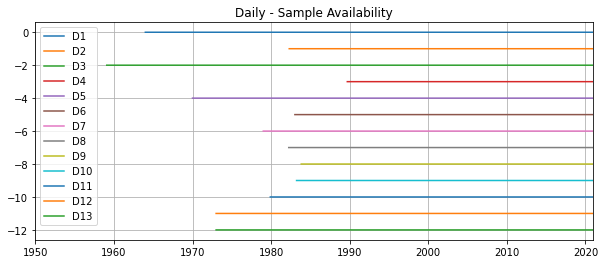

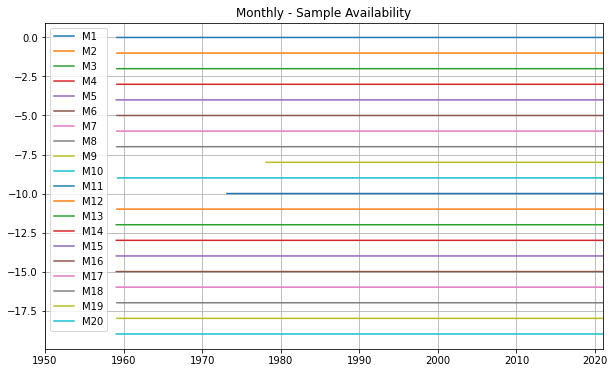

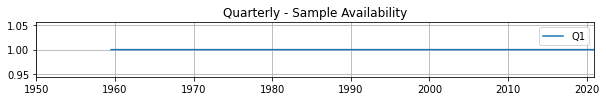

In [12]:
# Check data availability
preproc_data_filled = pd.read_csv(
    os.path.join(data_path, 'fullsample_output_filled_data.csv'),
    parse_dates = ["Date"]
).set_index("Date")

preproc_data_filled[~pd.isna(preproc_data_filled)] = 1

# Daily
plt.figure(figsize=(10,4))
for j, c in enumerate(list(map(lambda j : f"D{j}", range(1, 14)))):
    plt.plot(preproc_data_filled[[c]] * -j, label=c)
plt.xlim([pd.to_datetime('1950-01-01'), pd.to_datetime('2021-01-01')])
plt.grid()
plt.title("Daily - Sample Availability")
plt.legend()
plt.show()

## Weekly
#plt.figure(figsize=(10,3))
#for j, c in enumerate(list(map(lambda j : f"W{j}", range(1, 11)))):
#    plt.plot(preproc_data_filled[[c]] * -j, label=c)
#plt.xlim([pd.to_datetime('1950-01-01'), pd.to_datetime('2021-01-01')])
#plt.grid()
#plt.title("Weekly - Sample Availability")
#plt.legend()
#plt.show()

# Monthly
plt.figure(figsize=(10,6))
for j, c in enumerate(list(map(lambda j : f"M{j}", range(1, 21)))):
    plt.plot(preproc_data_filled[[c]] * -j, label=c)
plt.xlim([pd.to_datetime('1950-01-01'), pd.to_datetime('2021-01-01')])
plt.grid()
plt.title("Monthly - Sample Availability")
plt.legend()
plt.show()

# Quartely
plt.figure(figsize=(10,1))
plt.plot(preproc_data_filled["Q1"], label="Q1")
plt.xlim([pd.to_datetime('1950-01-01'), pd.to_datetime('2021-01-01')])
plt.grid()
plt.title("Quarterly - Sample Availability")
plt.legend()
plt.show()

In [13]:
preproc_data = pd.read_csv(
    os.path.join(data_path, 'fullsample_output_data.csv'), 
    parse_dates = ["Date"]
).set_index("Date")
data = preproc_data.loc[startSampleDate:endSampleDate]

In [14]:
# Non-filled data
d_data = data[['D'+str(i) for i in range(1, 14)]].dropna()
m_data = data[['M'+str(i) for i in range(1, 21)]].dropna()
GDP_data = data[['Q1']].dropna()

# Interpolate non-filled daily data
d_data_interp = pd.DataFrame()
for c in d_data.columns:
    d_data_interp = d_data_interp.join(
        daily_begginingInterp(d_data[c], length=24, endOfMonth=False).rename(columns={0: c}),
        how='right',
    )

In [15]:
# Filled data
m_data_prefill = preproc_data[['M'+str(i) for i in range(1, 21)]].loc[
    (startSampleDate - pd.offsets.MonthBegin()):endSampleDate
].dropna()
GDP_data_prefill = preproc_data[['Q1']].loc[
    (startSampleDate - pd.offsets.QuarterBegin()):endSampleDate
].dropna()

# Interpolate non-filled daily data to month end
d_data_fill_interp = pd.DataFrame()
for c in d_data.columns:
    d_data_fill_interp = d_data_fill_interp.join(
        daily_begginingInterp(d_data[c], length=24, endOfMonth=True).rename(columns={0: c}),
        how='right',
    )

# Aggregate interpolated daily to mean over 6 days windows
d_data_fill_interp_agg = daily_aggregateByIndex(d_data_fill_interp, window_size=6, endOfWindow=True)

# Shift monthly, quarterly data to solar end-of-month date
m_data_prefill.index = m_data_prefill.index + pd.offsets.MonthEnd(0)
GDP_data_prefill.index = GDP_data_prefill.index + pd.offsets.QuarterEnd(0)

# Re-align filled data to daily indexes, join dataframe
pre_index = pd.date_range(
    start=startSampleDate - pd.offsets.YearBegin(), end=endSampleDate, freq='D'
)
pre_data_interp = pd.DataFrame(
    data=np.full((len(pre_index), 1), np.nan), index=pre_index
)

m_data_interp = pre_data_interp.join(m_data_prefill).ffill()
#GDP_data_interp = pre_data_interp.join(GDP_data_prefill).ffill()

# Make a new dataframe for filled explanatory variables
md_fill_data = d_data_fill_interp.join(m_data_interp.iloc[:,1:])#.join(GDP_data_interp.iloc[:,1:])

md_fill_agg_data = d_data_fill_interp_agg.join(m_data_interp.iloc[:,1:])

# Shift target data
GDP_fill_data  = GDP_data
GDP_fill_data.index = GDP_fill_data.index + pd.offsets.QuarterEnd(0)

Function to build datasets:

In [16]:
def getMediumDatasets(trainTestSplitDate=None):
    assert not trainTestSplitDate is None, "Choose a slicing data for train/test datasets"

    #trainTestSplitDate = pd.to_datetime('2007-12-31')
    trainTestSplitDate = pd.to_datetime(trainTestSplitDate)

    # Split training and testing sample
    GDP_data_train = GDP_data.loc[startSampleDate:trainTestSplitDate]
    m_data_train = m_data.loc[startSampleDate:trainTestSplitDate]
    d_data_train = d_data_interp.loc[startSampleDate:trainTestSplitDate]
    GDP_fill_data_train  = GDP_fill_data.loc[startSampleDate:trainTestSplitDate]
    md_fill_data_train = md_fill_data.loc[startSampleDate:trainTestSplitDate]
    md_fill_agg_data_train = md_fill_agg_data.loc[startSampleDate:trainTestSplitDate]

    GDP_data_test = GDP_data.loc[(trainTestSplitDate + pd.offsets.Day()):endSampleDate]
    m_data_test = m_data.loc[(trainTestSplitDate - pd.offsets.MonthBegin(1)):endSampleDate]
    d_data_test = d_data_interp.loc[(trainTestSplitDate - pd.offsets.MonthBegin(1) + pd.offsets.Day(23)):endSampleDate]
    GDP_fill_data_test  = GDP_fill_data.loc[(trainTestSplitDate + pd.offsets.Day()):endSampleDate]
    md_fill_data_test = md_fill_data.loc[(trainTestSplitDate):endSampleDate]
    md_fill_agg_data_test = md_fill_agg_data.loc[(trainTestSplitDate):endSampleDate]

    # Normalize
    # NOTE: if adding normalization here, makes sure models forecasts are 
    #       properly adjusted and comparable
    #GDP_data_train, GDP_data_test = normalize_train_test(GDP_data_train, GDP_data_test)
    #m_data_train, m_data_test = normalize_train_test(m_data_train, m_data_test)
    #d_data_train, d_data_test = normalize_train_test(d_data_train, d_data_test)

    #GDP_fill_data_train, GDP_fill_data_test = normalize_train_test(GDP_fill_data_train, GDP_fill_data_test)
    #md_fill_data_train, md_fill_data_test = normalize_train_test(md_fill_data_train, md_fill_data_test)
    #md_fill_agg_data_train, md_fill_agg_data_test = normalize_train_test(md_fill_agg_data_train, md_fill_agg_data_test)

    # MIDAS data format
    GDP_data_midas = np.vstack((
        GDP_data_train.to_numpy(), 
        GDP_data_test.loc[(trainTestSplitDate + pd.offsets.Day()):].to_numpy()
    ))
    md_data_midas = (
        tuple(
            np.vstack((
                m_data_train[s].to_numpy()[:,None], 
                m_data_test[s].loc[(trainTestSplitDate + pd.offsets.Day()):].to_numpy()[:,None]
            )) for s in m_data_train.columns
        ) +
        (np.vstack((
            d_data_train.to_numpy(), 
            d_data_test.loc[(trainTestSplitDate + pd.offsets.Day()):].to_numpy()
        )), )
    )

    dataset = {
        'GDP_data_train':           GDP_data_train, 
        'GDP_data_test':            GDP_data_test, 
        'm_data_train':             m_data_train, 
        'm_data_test':              m_data_test, 
        'd_data_train':             d_data_train, 
        'd_data_test':              d_data_test,
        'GDP_fill_data_train':      GDP_fill_data_train, 
        'GDP_fill_data_test':       GDP_fill_data_test, 
        'md_fill_data_train':       md_fill_data_train, 
        'md_fill_data_test':        md_fill_data_test,
        'md_fill_agg_data_train':   md_fill_agg_data_train, 
        'md_fill_agg_data_test':    md_fill_agg_data_test,
        'GDP_data_midas':           GDP_data_midas, 
        'md_data_midas':            md_data_midas,
    }

    return dataset

In [17]:
def getMediumDatasets_extended(startSampleDate, endSampleDate, trainTestSplitDate=None):
    assert not trainTestSplitDate is None, "Choose a slicing data for train/test datasets"

    startSampleDate = pd.to_datetime(startSampleDate)
    endSampleDate = pd.to_datetime(endSampleDate)
    trainTestSplitDate = pd.to_datetime(trainTestSplitDate)

    data_ext = preproc_data.loc[startSampleDate:endSampleDate]
    # NOTE: unlike previous datasets, can not just always drop NAs, but instead 
    #       must slice data correctly according to date frequencies.

    # (i) Non-filled data
    d_data_ext = data_ext[['D'+str(i) for i in range(1, 14)]].replace(np.NaN, 0.)
    m_data_ext = data_ext[['M'+str(i) for i in range(1, 21)]].loc[
        pd.date_range(startSampleDate, endSampleDate, freq='BM'),
    ].replace(np.NaN, 0.)
    GDP_data_ext = data_ext[['Q1']].dropna()

    # Interpolate non-filled daily data
    d_data_ext_interp = pd.DataFrame()
    for c in d_data_ext.columns:
        d_data_ext_interp = d_data_ext_interp.join(
            daily_begginingInterp(d_data_ext[c], length=24, endOfMonth=False).rename(columns={0: c}),
            how='right',
        )

    # (ii) Filled data
    m_data_ext_prefill = preproc_data[['M'+str(i) for i in range(1, 21)]].loc[
    (startSampleDate - pd.offsets.MonthBegin()):endSampleDate
    ].loc[
        (startSampleDate - pd.offsets.MonthBegin()):endSampleDate
    ].loc[
        pd.date_range((startSampleDate - pd.offsets.MonthBegin()), endSampleDate, freq='BM'),
    ].replace(np.NaN, 0.)
    GDP_data_ext_prefill = preproc_data[['Q1']].loc[
        (startSampleDate - pd.offsets.QuarterBegin()):endSampleDate
    ].dropna()

    # Interpolate non-filled daily data to month end
    d_data_ext_fill_interp = pd.DataFrame()
    for c in d_data_ext.columns:
        d_data_ext_fill_interp = d_data_ext_fill_interp.join(
            daily_begginingInterp(d_data_ext[c], length=24, endOfMonth=True).rename(columns={0: c}),
            how='right',
        )

    # Aggregate interpolated daily to mean over 6 days windows
    d_data_ext_fill_interp_agg = daily_aggregateByIndex(
        d_data_ext_fill_interp, window_size=6, endOfWindow=True
    )

    # Shift monthly, quarterly data to solar end-of-month date
    m_data_ext_prefill.index = m_data_ext_prefill.index + pd.offsets.MonthEnd(0)
    GDP_data_ext_prefill.index = GDP_data_ext_prefill.index + pd.offsets.QuarterEnd(0)

    # Re-align filled data to daily indexes, join dataframe
    pre_index = pd.date_range(
        start=startSampleDate - pd.offsets.YearBegin(), end=endSampleDate, freq='D'
    )
    pre_data_interp = pd.DataFrame(
        data=np.full((len(pre_index), 1), np.nan), index=pre_index
    )

    # Make a new dataframe for filled explanatory variables
    m_data_ext_interp = pre_data_interp.join(m_data_ext_prefill).ffill()
    md_fill_data_ext = d_data_ext_fill_interp.join(m_data_ext_interp.iloc[:,1:])
    md_fill_agg_data_ext = d_data_ext_fill_interp_agg.join(m_data_ext_interp.iloc[:,1:])

    # Shift target data
    GDP_fill_data_ext = GDP_data_ext.copy()
    GDP_fill_data_ext.index = GDP_fill_data_ext.index + pd.offsets.QuarterEnd(0)
    
    # (iii) Split training and testing sample
    GDP_data_train = GDP_data_ext.loc[:trainTestSplitDate]
    m_data_train = m_data_ext.loc[:trainTestSplitDate]
    d_data_train = d_data_ext_interp.loc[:trainTestSplitDate]
    GDP_fill_data_train  = GDP_fill_data_ext.loc[:trainTestSplitDate]
    md_fill_data_train = md_fill_data_ext.loc[:trainTestSplitDate]
    md_fill_agg_data_train = md_fill_agg_data_ext.loc[:trainTestSplitDate]

    GDP_data_test = GDP_data_ext.loc[(trainTestSplitDate + pd.offsets.Day()):]
    m_data_test = m_data_ext.loc[(trainTestSplitDate - pd.offsets.MonthBegin(1)):]
    d_data_test = d_data_ext_interp.loc[(trainTestSplitDate - pd.offsets.MonthBegin(1) + pd.offsets.Day(23)):]
    GDP_fill_data_test  = GDP_fill_data_ext.loc[(trainTestSplitDate + pd.offsets.Day()):]
    md_fill_data_test = md_fill_data_ext.loc[(trainTestSplitDate):]
    md_fill_agg_data_test = md_fill_agg_data_ext.loc[(trainTestSplitDate):]

    # Normalize
    # NOTE: if adding normalization here, makes sure models forecasts are 
    #       properly adjusted and comparable
    #GDP_data_train, GDP_data_test = normalize_train_test(GDP_data_train, GDP_data_test)
    #m_data_train, m_data_test = normalize_train_test(m_data_train, m_data_test)
    #d_data_train, d_data_test = normalize_train_test(d_data_train, d_data_test)

    #GDP_fill_data_train, GDP_fill_data_test = normalize_train_test(GDP_fill_data_train, GDP_fill_data_test)
    #md_fill_data_train, md_fill_data_test = normalize_train_test(md_fill_data_train, md_fill_data_test)
    #md_fill_agg_data_train, md_fill_agg_data_test = normalize_train_test(md_fill_agg_data_train, md_fill_agg_data_test)

    # MIDAS data format
    GDP_data_midas = np.vstack((
        GDP_data_train.to_numpy(), 
        GDP_data_test.loc[(trainTestSplitDate + pd.offsets.Day()):].to_numpy()
    ))
    md_data_midas = (
        tuple(
            np.vstack((
                m_data_train[s].to_numpy()[:,None], 
                m_data_test[s].loc[(trainTestSplitDate + pd.offsets.Day()):].to_numpy()[:,None]
            )) for s in m_data_train.columns
        ) +
        (np.vstack((
            d_data_train.to_numpy(), 
            d_data_test.loc[(trainTestSplitDate + pd.offsets.Day()):].to_numpy()
        )), )
    )

    dataset = {
        'GDP_data_train':           GDP_data_train, 
        'GDP_data_test':            GDP_data_test, 
        'm_data_train':             m_data_train, 
        'm_data_test':              m_data_test, 
        'd_data_train':             d_data_train, 
        'd_data_test':              d_data_test,
        'GDP_fill_data_train':      GDP_fill_data_train, 
        'GDP_fill_data_test':       GDP_fill_data_test, 
        'md_fill_data_train':       md_fill_data_train, 
        'md_fill_data_test':        md_fill_data_test,
        'md_fill_agg_data_train':   md_fill_agg_data_train, 
        'md_fill_agg_data_test':    md_fill_agg_data_test,
        'GDP_data_midas':           GDP_data_midas, 
        'md_data_midas':            md_data_midas,
    }

    return dataset

In [18]:
# Export data to MATLAB
#GDP_fill_data_medium_train.to_csv(os.path.join(path_folder, "data", "GDP_fill_data_medium_train.csv"))
#GDP_fill_data_medium_test.to_csv(os.path.join(path_folder, "data", "GDP_fill_data_medium_test.csv"))
#md_fill_data_medium_train.to_csv(os.path.join(path_folder, "data", "md_fill_data_medium_train.csv"))
#md_fill_data_medium_test.to_csv(os.path.join(path_folder, "data", "md_fill_data_medium_test.csv"))

### Models

_[Note: all DFM model forecasts are external, read from CSV files]_

DFM:

In [19]:
def getDFMOneStepAheadForecast(model_name, date_slice=None):
    DFM_forecast_train = pd.read_csv(
        os.path.join(dfm_path, model_name, 'train_predictions_12.csv'),
    parse_dates = [0, 1]).set_index('Target.Date')
    DFM_forecast_test = pd.read_csv(
        os.path.join(dfm_path, model_name, 'test_predictions_12.csv'),
    parse_dates = [0, 1]).set_index('Target.Date')
    DFM_forecast = pd.concat([DFM_forecast_train, DFM_forecast_test])
    if not date_slice is None:
        DFM_forecast = DFM_forecast.loc[date_slice,]
    return DFM_forecast[['X0']]

In [20]:
def getDFMMultiStepAheadForecast(model_name, steps, date_slice=None):
    DFM_multistep_forecast = pd.DataFrame(
        data=None, columns=range(steps), index=date_slice,
    )
    for h in range(steps):
        # Read from files
        DFM_forecast_train_h = pd.read_csv(
            os.path.join(dfm_path, model_name, 'train_predictions_'+str(12*(h+1))+'.csv'),
        parse_dates = [0, 1]).set_index('Target.Date')
        DFM_forecast_test_h = pd.read_csv(
            os.path.join(dfm_path, model_name, 'test_predictions_'+str(12*(h+1))+'.csv'),
        parse_dates = [0, 1]).set_index('Target.Date')
        DFM_forecast_h = pd.concat([DFM_forecast_train_h, DFM_forecast_test_h])
        # Insert
        DFM_multistep_forecast.iloc[:,h] = DFM_forecast_h.loc[date_slice,'X0'].to_numpy()
    return DFM_multistep_forecast

MIDAS:

*NOTE: We do not apply MIDAS with the medium-sized data because the number of variables & lags is already too large.*

Single-reservoir ESN:

In [21]:
esn_S_A = ESN(
    N=30,
    A=stateMatrixGenerator(
        (30, 30), 
        dist='sparse_normal', sparsity=10/30, normalize='eig',
        seed=20220623
    ),
    C=stateMatrixGenerator(
        (30, int(m_data.shape[1] + d_data.shape[1])), 
        dist='sparse_uniform', sparsity=10/30, normalize='norm2',
        seed=20220623
    ),
    rho=0.5,
    gamma=1,
    leak_rate=0.1,
    activation=np.tanh,
)

esnSingle_A = ESNMultiFrequency((esn_S_A,), ar=False) 

In [22]:
esn_S_B = ESN(
    N=120,
    A=stateMatrixGenerator(
        (120, 120), 
        dist='sparse_normal', sparsity=10/120, normalize='eig',
        seed=19120623
    ),
    C=stateMatrixGenerator(
        (120, int(m_data.shape[1] + d_data.shape[1])), 
        dist='sparse_uniform', sparsity=10/120, normalize='norm2',
        seed=19120623
    ),
    rho=0.5,
    gamma=1,
    leak_rate=0.1,
    activation=np.tanh,
)

esnSingle_B = ESNMultiFrequency((esn_S_B,), ar=False) 

Multi-reservoir ESN:

In [23]:
esn_M_A = ESN(
    N=100,
    A=stateMatrixGenerator(
        (100, 100), 
        dist='sparse_normal', sparsity=10/100, normalize='eig',
        seed=20220623
    ),
    C=stateMatrixGenerator(
        (100, m_data.shape[1]), 
        dist='sparse_uniform', sparsity=10/100, normalize='norm2',
        seed=20220623
    ),
    rho=0.5,
    gamma=1.5,
    leak_rate=0,
    activation=np.tanh,
)

esn_D_A = ESN(
    N=20,
    A=stateMatrixGenerator(
        (20, 20), 
        dist='sparse_normal', sparsity=10/20, normalize='eig',
        seed=20220623
    ),
    C=stateMatrixGenerator(
        (20, d_data.shape[1]), 
        dist='sparse_uniform', sparsity=10/20, normalize='norm2',
        seed=20220623
    ),
    rho=0.5,
    gamma=0.5,
    leak_rate=0.1,
    activation=np.tanh,
)

esnMulti_A = ESNMultiFrequency((esn_M_A, esn_D_A), ar=False) 

In [24]:
esn_M_B = ESN(
    N=100,
    A=stateMatrixGenerator(
        (100, 100), 
        dist='sparse_normal', sparsity=10/100, normalize='eig',
        seed=19120623
    ),
    C=stateMatrixGenerator(
        (100, m_data.shape[1]), 
        dist='sparse_uniform', sparsity=10/100, normalize='norm2',
        seed=19120623
    ),
    rho=0.08,
    gamma=0.25,
    leak_rate=0.3,
    activation=np.tanh,
)

esn_D_B = ESN(
    N=20,
    A=stateMatrixGenerator(
        (20, 20), 
        dist='sparse_normal', sparsity=10/20, normalize='eig',
        seed=19120623
    ),
    C=stateMatrixGenerator(
        (20, d_data.shape[1]), 
        dist='sparse_uniform', sparsity=10/20, normalize='norm2',
        seed=19120623
    ),
    rho=0.01,
    gamma=0.01,
    leak_rate=0.99,
    activation=np.tanh,
)

esnMulti_B = ESNMultiFrequency((esn_M_B, esn_D_B), ar=False) 

### Pre-Crisis Model Evaluation

In [25]:
dataset2007 = getMediumDatasets('2007-12-31')

In [26]:
# Export data to MATLAB
#dataset2007['m_data_medium_train'].to_csv(os.path.join(path_folder, "data", "m_data_medium_train.csv"))
#dataset2007['m_data_medium_test'].to_csv(os.path.join(path_folder, "data", "m_data_medium_test.csv"))
#dataset2007['d_data_medium_train'].to_csv(os.path.join(path_folder, "data", "d_data_medium_train.csv"))
#dataset2007['d_data_medium_test'].to_csv(os.path.join(path_folder, "data", "d_data_medium_test.csv"))

##### ESN Ridge CV


In [27]:
dataset2007_ext = getMediumDatasets_extended(
    '1975-01-01', '2019-12-31', trainTestSplitDate='2007-12-31'
)

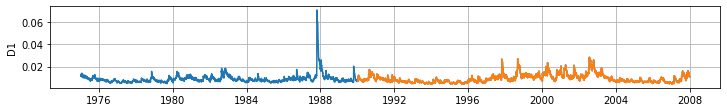

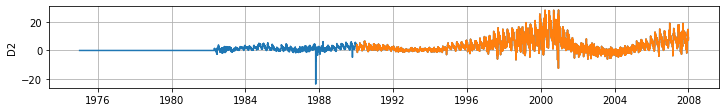

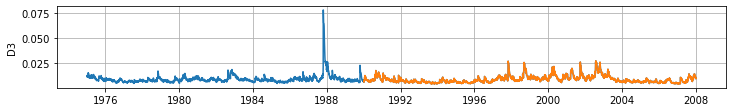

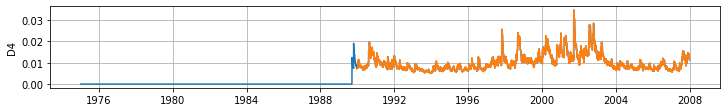

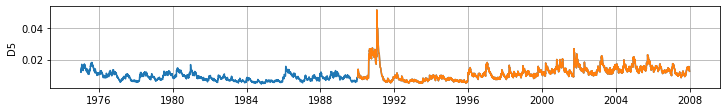

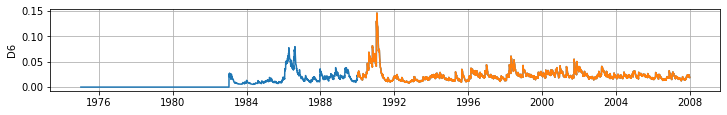

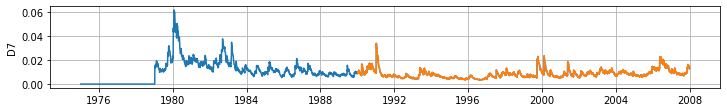

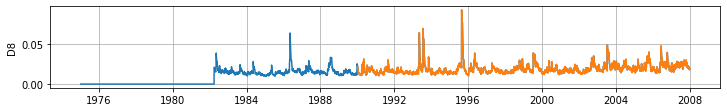

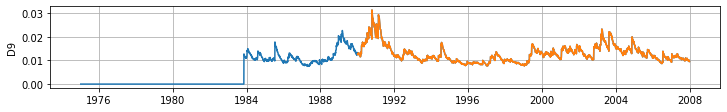

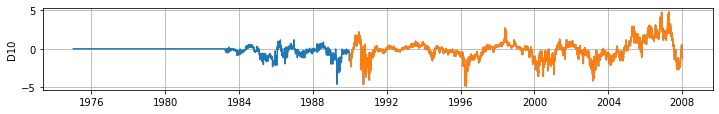

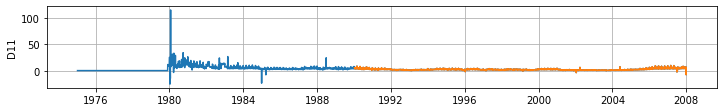

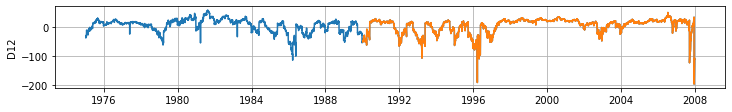

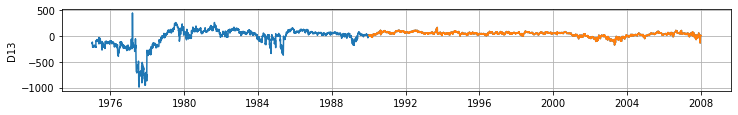

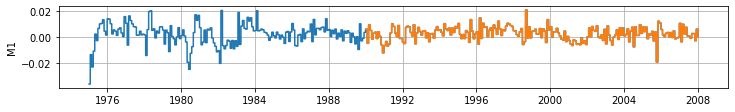

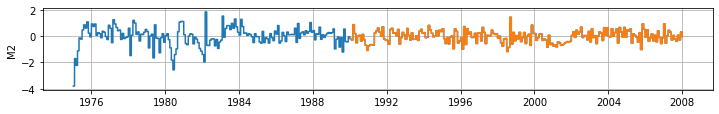

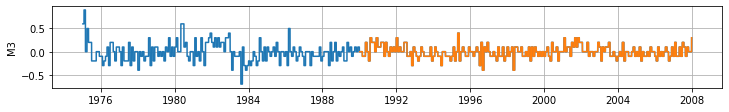

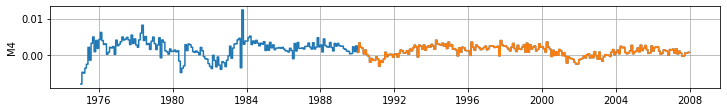

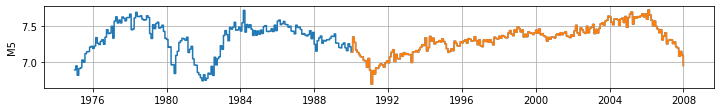

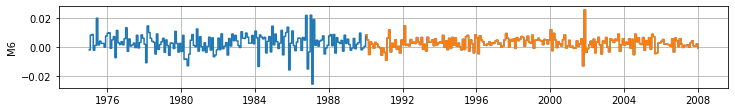

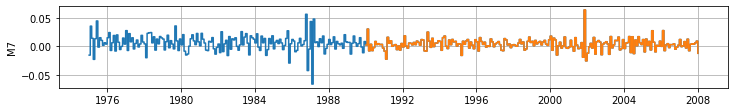

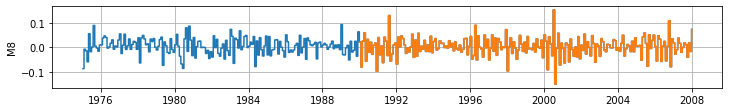

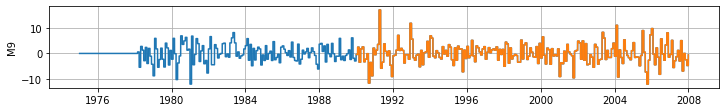

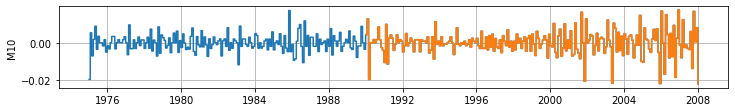

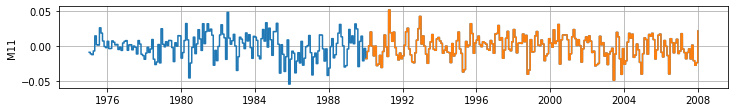

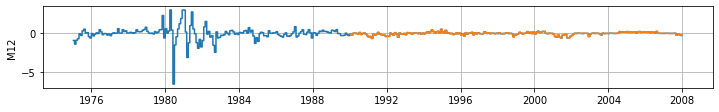

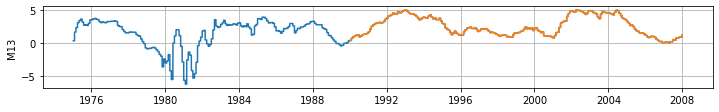

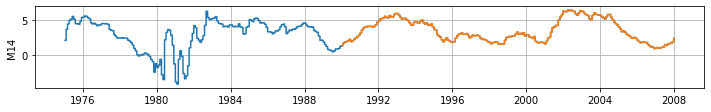

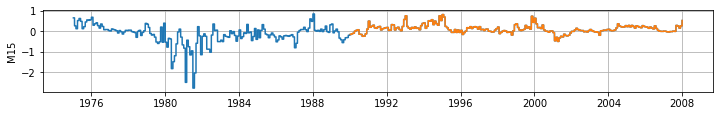

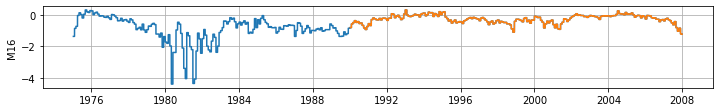

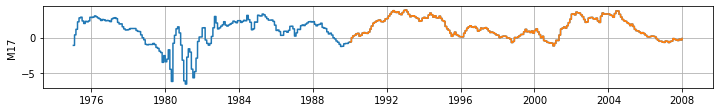

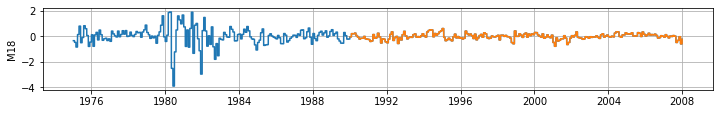

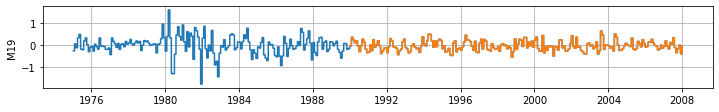

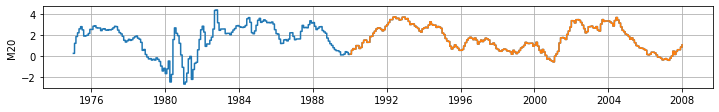

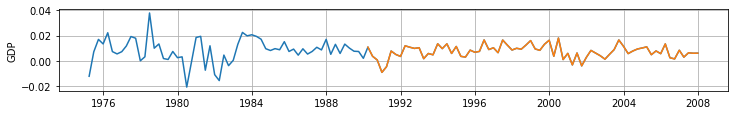

In [28]:
for c in dataset2007['md_fill_data_train'].columns:
    plt.figure(figsize=(12,1.5))
    plt.plot(dataset2007_ext['md_fill_data_train'][c], label=c)
    plt.plot(dataset2007['md_fill_data_train'][c], label=c)
    plt.ylabel(c)
    plt.grid()
    plt.show()

plt.figure(figsize=(12,1.5))
plt.plot(dataset2007_ext['GDP_fill_data_train'])
plt.plot(dataset2007['GDP_fill_data_train'])
plt.ylabel("GDP")
plt.grid()
plt.show()

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
. Folds built


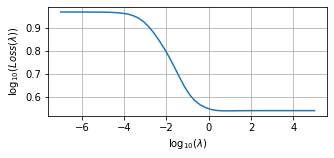

+ s = 0 --------------------
Best solution found:
lambda = [6.80405388]
F      = 3.45808337192086


In [29]:
# Aggregated
esnSingle_A_agg_cv10_lambda_2007 = esnSingle_A.ridge_lambda_cv(
    Y=dataset2007_ext['GDP_fill_data_train'], z=(dataset2007_ext['md_fill_agg_data_train'], ),
    method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    steps=1,
    debug=True,
)

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
. Folds built


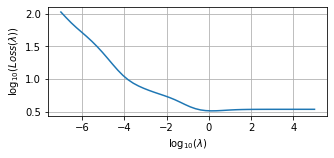

+ s = 0 --------------------
Best solution found:
lambda = [1.40855936]
F      = 3.2820974653096697


In [30]:
# Aggregated
esnSingle_B_agg_cv10_lambda_2007 = esnSingle_B.ridge_lambda_cv(
    Y=dataset2007_ext['GDP_fill_data_train'], z=(dataset2007_ext['md_fill_agg_data_train'], ),
    method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    steps=1,
    debug=True,
)

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
. Folds built


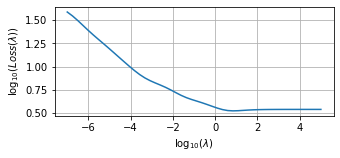

+ s = 0 --------------------
Best solution found:
lambda = [7.16982772]
F      = 3.3436970088993383


In [31]:
esnMulti_A_cv10_lambda_2007 = esnMulti_A.ridge_lambda_cv(
    Y=dataset2007_ext['GDP_data_train'], 
    z=(dataset2007_ext['m_data_train'], dataset2007_ext['d_data_train']),
    method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    #cv_options="-cv_min_split_size:80-cv_max_split_size:80-test_size:1",
    steps=1,
    debug=True,
)

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
. Folds built


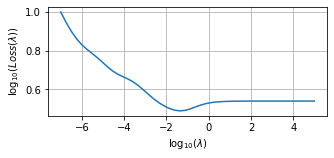

+ s = 0 --------------------
Best solution found:
lambda = [0.04559099]
F      = 3.0866522680700794


In [32]:
esnMulti_B_cv10_lambda_2007 = esnMulti_B.ridge_lambda_cv(
    Y=dataset2007_ext['GDP_data_train'], 
    z=(dataset2007_ext['m_data_train'], dataset2007_ext['d_data_train']),
    method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    steps=1,
    debug=True,
)

##### Check ridge penalty:

In [33]:
#def esnSingle_checkRidgeLambda(esnModel, Lambdas, data):
#    GDP_fill_data_train = data['GDP_fill_data_train']
#    GDP_fill_data_test = data['GDP_fill_data_test']
#    md_fill_data_train = data['md_fill_data_train']
#    md_fill_data_test = data['md_fill_data_test']
#
#    #fits      = np.zeros((len(Lambdas), 1))
#    forecasts = np.zeros((len(GDP_fill_data_test), len(Lambdas)))
#    for j in tqdm(range(len(Lambdas)), desc=" Lambda", position=1, leave=False):
#        esnSingle_fit = esnModel.fit(
#            Y=GDP_fill_data_train, z=(md_fill_data_train, ), 
#            method='ridge',
#            Lambda=[Lambdas[j], ],
#            full=False,
#            debug=False,
#        )
#
#        esnSingle_for = esnModel.fixedParamsForecast(
#            Yf=GDP_fill_data_test, zf=(md_fill_data_test, ), 
#            fit=esnSingle_fit
#        )
#
#        #fits.append(esnSingle_fit['fit_for'][0]['Y_fit'])
#        forecasts[:,j] = np.squeeze(esnSingle_for['Forecast'][0]['Y_for'])
#
#    return pd.DataFrame(data=forecasts, index=GDP_fill_data_test.index)

In [34]:
#L = 30
#Lambdas_grid = (10 ** np.linspace(-5, 5, L))
#
#esnMulti_A_checkLambda_for = esnSingle_checkRidgeLambda(
#    esnModel=esnSingle_A, 
#    Lambdas=Lambdas_grid,
#    data=dataset2007
#)
#
#esnMulti_B_checkLambda_for = esnSingle_checkRidgeLambda(
#    esnModel=esnSingle_B, 
#    Lambdas=Lambdas_grid,
#    data=dataset2007
#)

In [35]:
#plt.figure(figsize=(10,3))
#plt.plot(
#    Lambdas_grid, 
#    np.sum((esnMulti_A_checkLambda_for.to_numpy() - dataset2007['GDP_data_test'].to_numpy())**2, axis=0),
#    c='C0'
#)
#plt.axvline(x=esnSingle_A_Lambda_cv[0] / 10, c='k')
#plt.xscale('log')
##plt.yscale('log')
#plt.title("singleESN [A]")
#plt.grid()
#plt.show()
#
#plt.figure(figsize=(10,3))
#plt.plot(
#    Lambdas_grid, 
#    np.sum((esnMulti_B_checkLambda_for.to_numpy() - dataset2007['GDP_data_test'].to_numpy())**2, axis=0),
#    c='C1'
#)
#plt.axvline(x=esnSingle_B_Lambda_cv[0] / 10, c='k')
#plt.xscale('log')
##plt.yscale('log')
#plt.title("singleESN [B]")
#plt.grid()
#plt.show()

#### 1-step Ahead Point Forecast Comparison

##### Fixed Parameters

In [42]:
def uncondMean_1sa_fixParamsForecast(data):
    GDP_data_train = data['GDP_data_train']
    GDP_test_dates = data['GDP_data_test'].index

    return pd.DataFrame(
        data=np.ones((len(GDP_test_dates))) * GDP_data_train.mean().iloc[0],
        index=GDP_test_dates,
    )

In [43]:
UnMean_fix_for_1sa_2007 = uncondMean_1sa_fixParamsForecast(
    data=dataset2007,
)

In [40]:
#DFM_A_forecast = pd.read_csv(
#    os.path.join(dfm_path, 'stock__5__6__[1, 4, 12]_fixed__2007', 'q_test_12.csv'),
#    parse_dates = [0])
#DFM_A_forecast.columns.values[0] = 'Date'
#DFM_A_forecast_2007 = (DFM_A_forecast.set_index('Date')[:'2019-12-31'])[['Q1_test_pred']]
#
#DFM_B_forecast = pd.read_csv(
#    os.path.join(dfm_path, 'almon__10__6__[1, 4, 12]_fixed__2007', 'q_test_12.csv'),
#    parse_dates = [0])
#DFM_B_forecast.columns.values[0] = 'Date'
#DFM_B_forecast_2007 = (DFM_B_forecast.set_index('Date')[:'2019-12-31'])[['Q1_test_pred']]

DFM_slice_2007 = (
    pd.date_range('2008-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_fix_forecast_2007 = getDFMOneStepAheadForecast(
    'stock__10__6__[1]_fixed__2007', date_slice=DFM_slice_2007,
)

DFM_B_fix_forecast_2007 = getDFMOneStepAheadForecast(
    'almon__10__6__[1]_fixed__2007', date_slice=DFM_slice_2007,
)

In [44]:
def esnSingle_fix_fit_1sa(esnModel, Lambda, data, aggregate=False):
    GDP_fill_data_train = data['GDP_fill_data_train']
    GDP_fill_data_test = data['GDP_fill_data_test']
    if not aggregate:
        md_fill_data_train = data['md_fill_data_train']
        md_fill_data_test = data['md_fill_data_test']
    else:
        md_fill_data_train = data['md_fill_agg_data_train']
        md_fill_data_test = data['md_fill_agg_data_test']

    #GDP_test_dates = GDP_fill_data_test.index

    GDP_fill_data_train, GDP_fill_data_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_fill_data_train, GDP_fill_data_test,
            return_mu_sig=True)
    )
    md_fill_data_train, md_fill_data_test = normalize_train_test(md_fill_data_train, md_fill_data_test)

    esnSingle_fit = esnModel.fit(
        Y=GDP_fill_data_train, z=(md_fill_data_train, ), 
        method='ridge',
        Lambda=Lambda,
        full=False,
        debug=False,
    )

    plt.figure(figsize=(12,2))
    plt.plot(esnSingle_fit['fit_for'][0]['Y'], c='k')
    plt.plot(esnSingle_fit['fit_for'][0]['Y_fit'])
    plt.grid()
    plt.show()

    esnSingle_for = esnModel.fixedParamsForecast(
        Yf=GDP_fill_data_test, zf=(md_fill_data_test, ), 
        fit=esnSingle_fit
    )

    # Compute pointwise forecasts
    esnSingle_fix_forecast = (esnSingle_for['Forecast'][0]['Y_for'] * 
        GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy())

    return esnSingle_fix_forecast

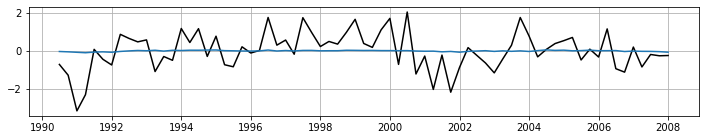

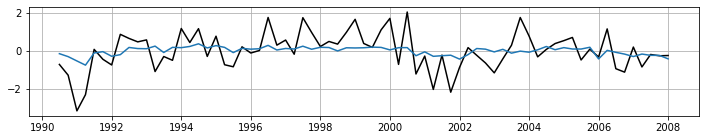

In [45]:
esnSingle_A_agg_fix_for_1sa_2007 = esnSingle_fix_fit_1sa(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2007, 
    #Lambda=[1e-2,],
    data=dataset2007,
    aggregate=True,
)

esnSingle_B_agg_fix_for_1sa_2007 = esnSingle_fix_fit_1sa(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2007, 
    #Lambda=[1e-2,],
    data=dataset2007,
    aggregate=True,
)

In [46]:
def esnMulti_fix_fit_1sa(esnModel, Lambda, data):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']
    m_data_train = data['m_data_train']
    m_data_test = data['m_data_test']
    d_data_train = data['d_data_train']
    d_data_test = data['d_data_test']

    #GDP_test_dates = GDP_data_test.index

    GDP_data_train, GDP_data_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_data_train, GDP_data_test,
            return_mu_sig=True)
    )
    m_data_train, m_data_test = normalize_train_test(m_data_train, m_data_test)
    d_data_train, d_data_test = normalize_train_test(d_data_train, d_data_test)

    esnMulti_fit = esnModel.fit(
        Y=GDP_data_train, z=(m_data_train, d_data_train), 
        method='ridge',
        Lambda=Lambda,
        full=False,
        debug=False,
    )

    plt.figure(figsize=(12,2))
    plt.plot(esnMulti_fit['fit_for'][0]['Y'], c='k')
    plt.plot(esnMulti_fit['fit_for'][0]['Y_fit'])
    plt.grid()
    plt.show()

    esnMulti_for = esnModel.fixedParamsForecast(
        Yf=GDP_data_test, zf=(m_data_test, d_data_test), 
        fit=esnMulti_fit
    )

    # Compute pointwise forecasts
    esnMulti_fix_forecast = (esnMulti_for['Forecast'][0]['Y_for'] * 
        GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy())

    return esnMulti_fix_forecast

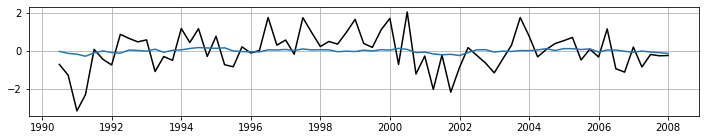

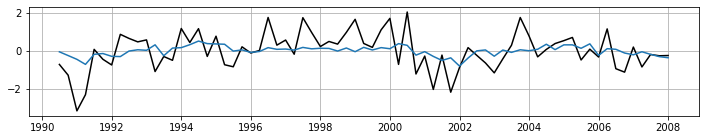

In [47]:
esnMulti_A_fix_for_1sa_2007 = esnMulti_fix_fit_1sa(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2007[0], esnMulti_A_cv10_lambda_2007[0]], 
    #Lambda=[1e-2, 1e-2],
    data=dataset2007,
)

esnMulti_B_fix_for_1sa_2007 = esnMulti_fix_fit_1sa(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2007[0], esnMulti_B_cv10_lambda_2007[0]], 
    data=dataset2007,
)

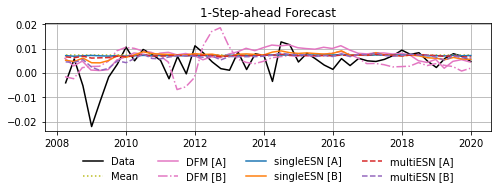

In [49]:
# Plot -- 1-Step-ahead Forecast
plt.figure(figsize=(8, 2))
plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
#
plt.plot(UnMean_fix_for_1sa_2007, label="Mean", c="C8", ls=':')
#
plt.plot(DFM_A_fix_forecast_2007, label="DFM [A]", c="C6") 
plt.plot(DFM_B_fix_forecast_2007, label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(esnSingle_A_agg_fix_for_1sa_2007, label="singleESN [A]", c="C0") 
plt.plot(esnSingle_B_agg_fix_for_1sa_2007, label="singleESN [B]", c="C1") 
#
plt.plot(esnMulti_A_fix_for_1sa_2007, label="multiESN [A]", c="C3", ls='--') 
plt.plot(esnMulti_B_fix_for_1sa_2007, label="multiESN [B]", c="C4", ls='--') 
#
plt.grid()
plt.title("1-Step-ahead Forecast")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_forecasts_2007.pdf'), bbox_inches="tight")
plt.show()

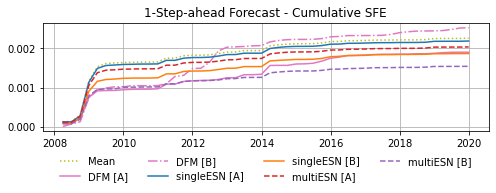

In [50]:
# Plot -- 1-Step-ahead Forecast - Cumulative SFE
cumulSFE_2007 = lambda forecast : np.cumsum(np.square(dataset2007['GDP_data_test'] - forecast.to_numpy()))

plt.figure(figsize=(8, 2))
plt.grid()
#
plt.plot(cumulSFE_2007(UnMean_fix_for_1sa_2007), label="Mean", c="C8", ls=':') 
#
plt.plot(cumulSFE_2007(DFM_A_fix_forecast_2007), label="DFM [A]", c="C6") 
plt.plot(cumulSFE_2007(DFM_B_fix_forecast_2007), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(cumulSFE_2007(esnSingle_A_agg_fix_for_1sa_2007), label="singleESN [A]", c="C0") 
plt.plot(cumulSFE_2007(esnSingle_B_agg_fix_for_1sa_2007), label="singleESN [B]", c="C1") 
#
plt.plot(cumulSFE_2007(esnMulti_A_fix_for_1sa_2007), label="multiESN [A]", c="C3", ls='--') 
plt.plot(cumulSFE_2007(esnMulti_B_fix_for_1sa_2007), label="multiESN [B]", c="C4", ls='--') 
#
#plt.yscale('log')
plt.title("1-Step-ahead Forecast - Cumulative SFE")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_cumulsfe_2007.pdf'), bbox_inches="tight")
plt.show()

In [51]:
def MSFE_2007(forecast, startDate=None):
    if not startDate is None:
        startDate = pd.to_datetime(startDate)
        msfe = np.mean(np.square(
                dataset2007['GDP_data_test'].loc[startDate:,].to_numpy() - 
                    forecast.loc[startDate:,].to_numpy()
            ))
    else:
        msfe = np.mean(np.square(
                dataset2007['GDP_data_test'].to_numpy() - forecast.to_numpy()
            ))
    return msfe

UnMean_MSE_fix_2007_td = MSFE_2007(UnMean_fix_for_1sa_2007) * 1e4
DFM_A_MSE_fix_2007_td = MSFE_2007(DFM_A_fix_forecast_2007) * 1e4
DMF_B_MSE_fix_2007_td = MSFE_2007(DFM_B_fix_forecast_2007) * 1e4
esnSingle_A_MSE_fix_2007_td = MSFE_2007(esnSingle_A_agg_fix_for_1sa_2007) * 1e4
esnSingle_B_MSE_fix_2007_td = MSFE_2007(esnSingle_B_agg_fix_for_1sa_2007) * 1e4
esnMulti_A_MSE_fix_2007_td = MSFE_2007(esnMulti_A_fix_for_1sa_2007) * 1e4
esnMulti_B_MSE_fix_2007_td = MSFE_2007(esnMulti_B_fix_for_1sa_2007) * 1e4

print("------------------- MSFE -------------- RMSFE -----")
print(f"Mean \t\t = {UnMean_MSE_fix_2007_td.round(4)} \t|\t"
        f"{np.sqrt(UnMean_MSE_fix_2007_td).round(4)}")
print(f"DFM [A]\t\t = {DFM_A_MSE_fix_2007_td.round(4)} \t|\t"
        f"{np.sqrt(DFM_A_MSE_fix_2007_td).round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_fix_2007_td.round(4)} \t|\t"
        f"{np.sqrt(DMF_B_MSE_fix_2007_td).round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_fix_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_A_MSE_fix_2007_td).round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_fix_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_B_MSE_fix_2007_td).round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_fix_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_A_MSE_fix_2007_td).round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_fix_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_B_MSE_fix_2007_td).round(4)}")

------------------- MSFE -------------- RMSFE -----
Mean 		 = 0.4702 	|	0.6857
DFM [A]		 = 0.3956 	|	0.629
DFM [B]		 = 0.5254 	|	0.7249
singleESN [A]	 = 0.4548 	|	0.6744
singleESN [B]	 = 0.3884 	|	0.6232
multiESN [A]	 = 0.4236 	|	0.6509
multiESN [B]	 = 0.3207 	|	0.5663


In [53]:
ref_MSE_2007_fix = UnMean_MSE_fix_2007_td
DFM_A_MSE_toRef_2007_fix = DFM_A_MSE_fix_2007_td / ref_MSE_2007_fix
DMF_B_MSE_toRef_2007_fix = DMF_B_MSE_fix_2007_td / ref_MSE_2007_fix
esnSingle_A_MSE_toRef_2007_fix = esnSingle_A_MSE_fix_2007_td / ref_MSE_2007_fix
esnSingle_B_MSE_toRef_2007_fix = esnSingle_B_MSE_fix_2007_td / ref_MSE_2007_fix
esnMulti_A_MSE_toRef_2007_fix = esnMulti_A_MSE_fix_2007_td / ref_MSE_2007_fix
esnMulti_B_MSE_toRef_2007_fix = esnMulti_B_MSE_fix_2007_td / ref_MSE_2007_fix

print("------------------ Relative MSFE -----------")
print(f"Mean \t\t = {1.0}")
print(f"DFM [A]\t\t = {DFM_A_MSE_toRef_2007_fix.round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_toRef_2007_fix.round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_toRef_2007_fix.round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_toRef_2007_fix.round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_toRef_2007_fix.round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_toRef_2007_fix.round(4)}")

------------------ Relative MSFE -----------
Mean 		 = 1.0
DFM [A]		 = 0.8414
DFM [B]		 = 1.1175
singleESN [A]	 = 0.9674
singleESN [B]	 = 0.8261
multiESN [A]	 = 0.901
multiESN [B]	 = 0.6821


In [54]:
mcs_data_2007_fix = pd.DataFrame(
    np.c_[UnMean_fix_for_1sa_2007,
        DFM_A_fix_forecast_2007,
        DFM_B_fix_forecast_2007,
        esnSingle_A_agg_fix_for_1sa_2007,
        esnSingle_B_agg_fix_for_1sa_2007,
        esnMulti_A_fix_for_1sa_2007,
        esnMulti_B_fix_for_1sa_2007,
    ],
    columns=['Mean','DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]']
)
mcs_data_2007_fix = (mcs_data_2007_fix - dataset2007['GDP_data_test'].to_numpy())

mcs_25_2007_fix = ModelConfidenceSet(
    data=np.square(mcs_data_2007_fix), alpha=0.25, B=10000, w=2, algorithm='R', seed=202209
).run()
mcs_10_2007_fix = ModelConfidenceSet(
    data=np.square(mcs_data_2007_fix), alpha=0.10, B=10000, w=2, algorithm='R', seed=202209
).run()

print(f"MCS 25 included: {mcs_25_2007_fix.included}")
print(f"MCS 10 included: {mcs_10_2007_fix.included}")

MCS 25 included: ['multiESN [B]']
MCS 10 included: ['multiESN [B]']


In [55]:
mcs_25_2007_fix.pvalues

DFM [B]          0.0716
Mean             0.0716
singleESN [A]    0.0716
multiESN [A]     0.0716
DFM [A]          0.0716
singleESN [B]    0.0716
multiESN [B]     1.0000
dtype: float64

In [134]:
mcs_data_2007_fix.to_csv(
    os.path.join(path_folder, "R", "mcs_medium_fix_2007.csv")
)

##### Expanding Windows

In [58]:
def uncondMean_ew_1sa_Forecast(data):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']

    GDP_test_dates = GDP_data_test.index

    forecast_ew = np.zeros((len(GDP_data_test), 1))
    for j in range(len(GDP_data_test)):
        if j > 0:
            GDP_data_train_j = pd.concat([
                GDP_data_train,
                GDP_data_test.iloc[0:j,]
            ])
        else:
            GDP_data_train_j = GDP_data_train

        forecast_ew[j] = GDP_data_train_j.mean().iloc[0]

    return pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)

In [59]:
UnMean_ew_1sa_forecast_2007 = uncondMean_ew_1sa_Forecast(
    data=dataset2007,
)

In [57]:
DFM_slice_2007 = (
    pd.date_range('2008-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_ew_forecast_2007 = getDFMOneStepAheadForecast(
    'stock__10__6__[1]_expanding__2007', date_slice=DFM_slice_2007,
)

DFM_B_ew_forecast_2007 = getDFMOneStepAheadForecast(
    'almon__10__6__[1]_expanding__2007', date_slice=DFM_slice_2007,
)

In [60]:
def esnSingle_ew_fit_1sa(esnModel, Lambda, data, retune=False, aggregate=False):
    GDP_fill_data_train = data['GDP_fill_data_train']
    GDP_fill_data_test = data['GDP_fill_data_test']
    if not aggregate:
        md_fill_data_train = data['md_fill_data_train']
        md_fill_data_test = data['md_fill_data_test']
    else:
        md_fill_data_train = data['md_fill_agg_data_train']
        md_fill_data_test = data['md_fill_agg_data_test']

    GDP_test_dates = GDP_fill_data_test.index

    if retune:  Lambdas = []

    forecast_ew = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc=" EW", position=1, leave=False):
        if j > 0:
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            md_fill_data_train_j = pd.concat([
                md_fill_data_train, 
                md_fill_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            md_fill_data_test_j = md_fill_data_test.loc[[GDP_test_dates[j-1]],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            md_fill_data_train_j = md_fill_data_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            md_fill_data_test_j = md_fill_data_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        md_fill_data_train_j, md_fill_data_test_j = (
            normalize_train_test(md_fill_data_train_j, md_fill_data_test_j)
        )

        #print(np.mean(GDP_fill_data_train_j))
        #print(np.mean(GDP_fill_data_train_j))

        #print(f"j = {j}")
        #print(f"{GDP_fill_data_train_j.index[-1]} | {GDP_fill_data_test_j.index[0]}")
        #print(f"{md_fill_data_train_j.index[-1]} | {md_fill_data_test_j.index[0]} -> {md_fill_data_test_j.index[-1]}")
        #print("-------------------------------")

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ),
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnSingle_fit = esnModel.fit(
            Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ), 
            method='ridge',
            Lambda=Lambda_j,
            full=False,
            debug=False,
        )

        esnSingle_for = esnModel.fixedParamsForecast(
            Yf=GDP_fill_data_test_j, zf=(md_fill_data_test_j, ), 
            fit=esnSingle_fit
        )

        forecast_ew[j] = np.squeeze(esnSingle_for['Forecast'][0]['Y_for']) * sig_j + mu_j

    if retune:
        plt.figure(figsize=(8,2))
        for l in range(len(Lambda_j)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

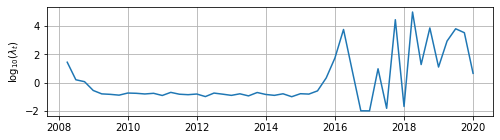

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

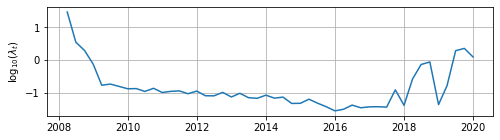

In [61]:
esnSingle_A_agg_ew_for_1sa_2007 = esnSingle_ew_fit_1sa(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2007, 
    data=dataset2007,
    retune=True,
    aggregate=True,
)

esnSingle_B_agg_ew_for_1sa_2007 = esnSingle_ew_fit_1sa(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2007, 
    data=dataset2007,
    retune=True,
    aggregate=True,
)

In [62]:
def esnMulti_ew_fit_1sa(esnModel, Lambda, data, retune=False):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']
    m_data_train = data['m_data_train']
    m_data_test = data['m_data_test']
    d_data_train = data['d_data_train']
    d_data_test = data['d_data_test']

    GDP_test_dates = GDP_data_test.index

    if retune:  Lambdas = []

    forecast_ew = np.zeros((len(GDP_data_test), 1))
    for j in tqdm(range(len(GDP_data_test)), desc=" EW", position=1, leave=False):
        if j > 0:
            GDP_data_train_j = pd.concat([
                GDP_data_train,
                GDP_data_test.iloc[0:j,]
            ])
            m_data_train_j = pd.concat([
                m_data_train,
                m_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            d_data_train_j = pd.concat([
                d_data_train,
                d_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            GDP_data_test_j = GDP_data_test.iloc[[j],]
            m_data_test_j = m_data_test.loc[[m_data_train_j.index[-1]],]
            d_data_test_j = d_data_test.loc[[d_data_train_j.index[-1]],]
        else:
            GDP_data_train_j = GDP_data_train
            m_data_train_j = m_data_train
            d_data_train_j = d_data_train
            GDP_data_test_j = GDP_data_test.iloc[[0],]
            m_data_test_j = m_data_test.iloc[[0],]
            d_data_test_j = d_data_test.iloc[[0],]

        # Normalize
        GDP_data_train_j, GDP_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_data_train_j, GDP_data_test_j,
                return_mu_sig=True)
        )
        m_data_train_j, m_data_test_j = (
            normalize_train_test(m_data_train_j, m_data_test_j)
        )
        d_data_train_j, d_data_test_j = (
            normalize_train_test(d_data_train_j, d_data_test_j)
        )

        #print(f"j = {j}")
        #print(f"{GDP_data_train_j.index[-1]} | {GDP_data_test_j.index[0]}")
        #print(f"{m_data_train_j.index[-1]} | {m_data_test_j.index[0]} -> {m_data_test_j.index[-1]}")
        #print(f"{d_data_train_j.index[-1]} | {d_data_test_j.index[0]} -> {d_data_test_j.index[-1]}")
        #print("-------------------------------")

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j), 
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambda_j = [Lambda_j[0], Lambda_j[0]]
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnMulti_fit = esnModel.fit(
            Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j), 
            method='ridge',
            Lambda=Lambda_j,
            full=False,
            debug=False,
        )

        esnMulti_for = esnModel.fixedParamsForecast(
            Yf=GDP_data_test_j, zf=(m_data_test_j, d_data_test_j), 
            fit=esnMulti_fit
        )

        forecast_ew[j] = np.squeeze(esnMulti_for['Forecast'][0]['Y_for']) * sig_j + mu_j

    if retune:
        plt.figure(figsize=(8,2))
        for l in range(len(Lambda_j)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

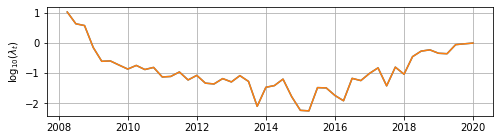

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

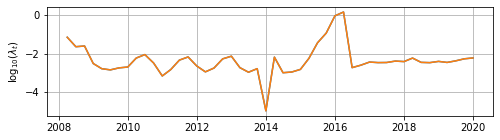

In [63]:
esnMulti_A_ew_for_1sa_2007 = esnMulti_ew_fit_1sa(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2007[0], esnMulti_A_cv10_lambda_2007[0]], 
    data=dataset2007,
    retune=True,
)

esnMulti_B_ew_for_1sa_2007 = esnMulti_ew_fit_1sa(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2007[0], esnMulti_B_cv10_lambda_2007[0]], 
    data=dataset2007,
    retune=True,
)

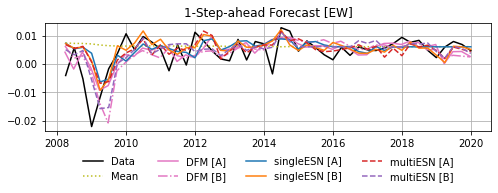

In [207]:
# Plot -- 1-Step-ahead Forecast
plt.figure(figsize=(8, 2))
plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
#
plt.plot(UnMean_ew_1sa_forecast_2007, label="Mean", c="C8", ls=':')
#
plt.plot(DFM_A_ew_forecast_2007, label="DFM [A]", c="C6") 
plt.plot(DFM_B_ew_forecast_2007, label="DFM [B]", c="C6", ls='-.')  
#
plt.plot(esnSingle_A_agg_ew_for_1sa_2007, label="singleESN [A]", c="C0") 
plt.plot(esnSingle_B_agg_ew_for_1sa_2007, label="singleESN [B]", c="C1") 
#
plt.plot(esnMulti_A_ew_for_1sa_2007, label="multiESN [A]", c="C3", ls='--') 
plt.plot(esnMulti_B_ew_for_1sa_2007, label="multiESN [B]", c="C4", ls='--') 
#
plt.grid()
plt.title("1-Step-ahead Forecast [EW]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_forecasts_ew_2007.pdf'), bbox_inches="tight")
plt.show()

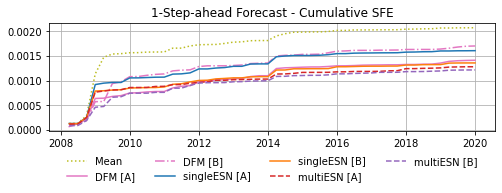

In [211]:
# Plot -- 1-Step-ahead Forecast - Cumulative SFE
plt.figure(figsize=(8, 2))
plt.grid()
#
plt.plot(cumulSFE_2007(UnMean_ew_1sa_forecast_2007), label="Mean", c="C8", ls=':')
#
plt.plot(cumulSFE_2007(DFM_A_ew_forecast_2007), label="DFM [A]", c="C6") 
plt.plot(cumulSFE_2007(DFM_B_ew_forecast_2007), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(cumulSFE_2007(esnSingle_A_agg_ew_for_1sa_2007), label="singleESN [A]", c="C0") 
plt.plot(cumulSFE_2007(esnSingle_B_agg_ew_for_1sa_2007), label="singleESN [B]", c="C1") 
#
plt.plot(cumulSFE_2007(esnMulti_A_ew_for_1sa_2007), label="multiESN [A]", c="C3", ls='--') 
plt.plot(cumulSFE_2007(esnMulti_B_ew_for_1sa_2007), label="multiESN [B]", c="C4", ls='--') 
#
#plt.yscale('log')
plt.title("1-Step-ahead Forecast - Cumulative SFE")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_cumulsfe_ew_2007.pdf'), bbox_inches="tight")
plt.show()

In [66]:
UnMean_MSE_ew_2007_td = MSFE_2007(UnMean_ew_1sa_forecast_2007) * 1e4
DFM_A_MSE_ew_2007_td = MSFE_2007(DFM_A_ew_forecast_2007) * 1e4
DMF_B_MSE_ew_2007_td = MSFE_2007(DFM_B_ew_forecast_2007) * 1e4
esnSingle_A_MSE_ew_2007_td = MSFE_2007(esnSingle_A_agg_ew_for_1sa_2007) * 1e4
esnSingle_B_MSE_ew_2007_td = MSFE_2007(esnSingle_B_agg_ew_for_1sa_2007) * 1e4
esnMulti_A_MSE_ew_2007_td = MSFE_2007(esnMulti_A_ew_for_1sa_2007) * 1e4
esnMulti_B_MSE_ew_2007_td = MSFE_2007(esnMulti_B_ew_for_1sa_2007) * 1e4

print("------------------- MSFE -------------- RMSFE -----")
print(f"Mean \t\t = {UnMean_MSE_ew_2007_td.round(4)} \t|\t"
        f"{np.sqrt(UnMean_MSE_ew_2007_td).round(4)}")
print(f"DFM [A]\t\t = {DFM_A_MSE_ew_2007_td.round(4)} \t|\t"
        f"{np.sqrt(DFM_A_MSE_ew_2007_td).round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_ew_2007_td.round(4)} \t|\t"
        f"{np.sqrt(DMF_B_MSE_ew_2007_td).round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_ew_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_A_MSE_ew_2007_td).round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_ew_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_B_MSE_ew_2007_td).round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_ew_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_A_MSE_ew_2007_td).round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_ew_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_B_MSE_ew_2007_td).round(4)}")

------------------- MSFE -------------- RMSFE -----
Mean 		 = 0.4325 	|	0.6577
DFM [A]		 = 0.2948 	|	0.543
DFM [B]		 = 0.3552 	|	0.596
singleESN [A]	 = 0.3353 	|	0.5791
singleESN [B]	 = 0.2834 	|	0.5323
multiESN [A]	 = 0.2672 	|	0.5169
multiESN [B]	 = 0.2538 	|	0.5038


In [67]:
ref_MSE_2007_ew = UnMean_MSE_ew_2007_td
DFM_A_MSE_toRef_2007_ew = DFM_A_MSE_ew_2007_td / ref_MSE_2007_ew
DMF_B_MSE_toRef_2007_ew = DMF_B_MSE_ew_2007_td / ref_MSE_2007_ew
esnSingle_A_MSE_toRef_2007_ew = esnSingle_A_MSE_ew_2007_td / ref_MSE_2007_ew
esnSingle_B_MSE_toRef_2007_ew = esnSingle_B_MSE_ew_2007_td / ref_MSE_2007_ew
esnMulti_A_MSE_toRef_2007_ew = esnMulti_A_MSE_ew_2007_td / ref_MSE_2007_ew
esnMulti_B_MSE_toRef_2007_ew = esnMulti_B_MSE_ew_2007_td / ref_MSE_2007_ew

print("------------------ Relative MSFE -----------")
print(f"Mean \t\t = {1.0}")
print(f"DFM [A]\t\t = {DFM_A_MSE_toRef_2007_ew.round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_toRef_2007_ew.round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_toRef_2007_ew.round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_toRef_2007_ew.round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_toRef_2007_ew.round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_toRef_2007_ew.round(4)}")

------------------ Relative MSFE -----------
Mean 		 = 1.0
DFM [A]		 = 0.6816
DFM [B]		 = 0.8212
singleESN [A]	 = 0.7753
singleESN [B]	 = 0.6552
multiESN [A]	 = 0.6177
multiESN [B]	 = 0.5868


In [82]:
mcs_data_2007_ew = pd.DataFrame(
    np.c_[UnMean_ew_1sa_forecast_2007,
        DFM_A_ew_forecast_2007,
        DFM_B_ew_forecast_2007,
        esnSingle_A_agg_ew_for_1sa_2007,
        esnSingle_B_agg_ew_for_1sa_2007,
        esnMulti_A_ew_for_1sa_2007,
        esnMulti_B_ew_for_1sa_2007,
    ],
    columns=['Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A] [EW]', 'singleESN [B] [EW]', 'multiESN [A] [EW]', 'multiESN [B] [EW]']
)
mcs_data_2007_ew = (mcs_data_2007_ew - dataset2007['GDP_data_test'].to_numpy())
#mcs_data_2007_ew = mcs_data_2007_ew.iloc[6:,:]

mcs_25_2007_ew = ModelConfidenceSet(
    data=np.square(mcs_data_2007_ew), alpha=0.25, B=10000, w=2, algorithm='R', seed=202209
).run()
mcs_10_2007_ew = ModelConfidenceSet(
    data=np.square(mcs_data_2007_ew), alpha=0.10, B=10000, w=2, algorithm='R', seed=202209
).run()

print(f"MCS 25 included: {mcs_25_2007_ew.included}")
print(f"MCS 10 included: {mcs_10_2007_ew.included}")

MCS 25 included: ['DFM [A]', 'singleESN [B] [EW]', 'multiESN [A] [EW]', 'multiESN [B] [EW]']
MCS 10 included: ['Mean', 'DFM [B]', 'singleESN [A] [EW]', 'DFM [A]', 'singleESN [B] [EW]', 'multiESN [A] [EW]', 'multiESN [B] [EW]']


In [83]:
mcs_25_2007_ew.pvalues

Mean                  0.2030
DFM [B]               0.2030
singleESN [A] [EW]    0.2188
DFM [A]               0.6199
singleESN [B] [EW]    0.6199
multiESN [A] [EW]     0.8231
multiESN [B] [EW]     1.0000
dtype: float64

In [135]:
mcs_data_2007_ew.to_csv(
    os.path.join(path_folder, "R", "mcs_medium_ew_2007.csv")
)

##### Rolling Window

In [69]:
def uncondMean_rw_1sa_Forecast(data):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']

    GDP_test_dates = GDP_data_test.index

    forecast_rw = np.zeros((len(GDP_data_test), 1))
    for j in range(len(GDP_data_test)):
        if j > 0:
            GDP_data_train_j = pd.concat([
                GDP_data_train.iloc[j:,],
                GDP_data_test.iloc[0:j,]
            ])
        else:
            GDP_data_train_j = GDP_data_train

        forecast_rw[j] = GDP_data_train_j.mean().iloc[0]

    return pd.DataFrame(data=forecast_rw, index=GDP_test_dates,)

In [70]:
UnMean_rw_1sa_forecast_2007 = uncondMean_rw_1sa_Forecast(
    data=dataset2007,
)

In [68]:
DFM_slice_2007 = (
    pd.date_range('2008-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_rw_forecast_2007 = getDFMOneStepAheadForecast(
    'stock__10__6__[1]_window__2007', date_slice=DFM_slice_2007,
)

DFM_B_rw_forecast_2007 = getDFMOneStepAheadForecast(
    'almon__10__6__[1]_window__2007', date_slice=DFM_slice_2007,
)

In [71]:
def esnSingle_rw_fit_1sa(esnModel, Lambda, data, retune=False, aggregate=False):
    GDP_fill_data_train = data['GDP_fill_data_train']
    GDP_fill_data_test = data['GDP_fill_data_test']
    if not aggregate:
        md_fill_data_train = data['md_fill_data_train']
        md_fill_data_test = data['md_fill_data_test']
    else:
        md_fill_data_train = data['md_fill_agg_data_train']
        md_fill_data_test = data['md_fill_agg_data_test']

    GDP_test_dates = GDP_fill_data_test.index
    GDP_dates = GDP_fill_data_train.index.append(GDP_fill_data_test.index)

    if retune:  Lambdas = []

    forecast_rw = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc=" RW", position=1, leave=False):
        if j > 0:
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train,
                GDP_fill_data_test.iloc[0:j,]
            ]).iloc[j:,]
            md_fill_data_train_j = pd.concat([
                md_fill_data_train,
                md_fill_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            md_fill_data_train_j = md_fill_data_train_j[GDP_dates[j-1]:]
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            md_fill_data_test_j = md_fill_data_test.loc[[GDP_test_dates[j-1]],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            md_fill_data_train_j = md_fill_data_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            md_fill_data_test_j = md_fill_data_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        md_fill_data_train_j, md_fill_data_test_j = (
            normalize_train_test(md_fill_data_train_j, md_fill_data_test_j)
        )

        #print(f"j = {j}")
        #print(f"{GDP_fill_data_train_j.index[-1]} | {GDP_fill_data_test_j.index[0]}")
        #print(f"{md_fill_data_train_j.index[-1]} | {md_fill_data_test_j.index[0]} -> {md_fill_data_test_j.index[-1]}")
        #print(f"{GDP_fill_data_train_j.index[0]} -> {GDP_fill_data_train_j.index[-1]}")
        #print(f"{md_fill_data_train_j.index[0]} -> {md_fill_data_train_j.index[-1]}")
        #print("-------------------------------")

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ),
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnSingle_fit = esnModel.fit(
            Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ), 
            method='ridge',
            Lambda=Lambda_j,
            full=False,
            debug=False,
        )

        esnSingle_for = esnModel.fixedParamsForecast(
            Yf=GDP_fill_data_test_j, zf=(md_fill_data_test_j, ), 
            fit=esnSingle_fit
        )

        forecast_rw[j] = np.squeeze(esnSingle_for['Forecast'][0]['Y_for']) * sig_j + mu_j

    if retune:
        plt.figure(figsize=(8,2))
        for l in range(len(Lambda_j)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_rw, index=GDP_test_dates,)

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

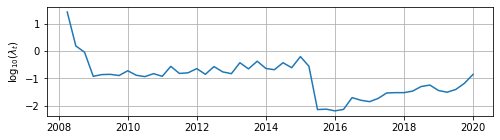

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

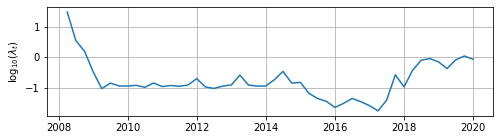

In [72]:
esnSingle_A_agg_rw_for_1sa_2007 = esnSingle_rw_fit_1sa(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2007, 
    data=dataset2007,
    retune=True,
    aggregate=True,
)

esnSingle_B_agg_rw_for_1sa_2007 = esnSingle_rw_fit_1sa(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2007,
    data=dataset2007,
    retune=True,
    aggregate=True,
)

In [73]:
def esnMulti_rw_fit_1sa(esnModel, Lambda, data, retune=False):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']
    m_data_train = data['m_data_train']
    m_data_test = data['m_data_test']
    d_data_train = data['d_data_train']
    d_data_test = data['d_data_test']

    GDP_test_dates = GDP_data_test.index
    GDP_dates = GDP_data_train.index.append(GDP_data_test.index)

    if retune:  Lambdas = []

    forecast_rw = np.zeros((len(GDP_data_test), 1))
    for j in tqdm(range(len(GDP_data_test)), desc=" RW", position=1, leave=False):
        if j > 0:
            GDP_data_train_j = pd.concat([
                GDP_data_train,
                GDP_data_test.iloc[0:j,]
            ]).iloc[j:,]
            m_data_train_j = pd.concat([
                m_data_train,
                m_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            d_data_train_j = pd.concat([
                d_data_train,
                d_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            m_data_train_j = m_data_train_j[GDP_dates[j-1]:]
            d_data_train_j = d_data_train_j[GDP_dates[j-1]:]
            GDP_data_test_j = GDP_data_test.iloc[[j],]
            m_data_test_j = m_data_test.loc[[m_data_train_j.index[-1]],]
            d_data_test_j = d_data_test.loc[[d_data_train_j.index[-1]],]
        else:
            GDP_data_train_j = GDP_data_train
            m_data_train_j = m_data_train
            d_data_train_j = d_data_train
            GDP_data_test_j = GDP_data_test.iloc[[0],]
            m_data_test_j = m_data_test.iloc[[0],]
            d_data_test_j = d_data_test.iloc[[0],]

        # Normalize
        GDP_data_train_j, GDP_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_data_train_j, GDP_data_test_j,
                return_mu_sig=True)
        )
        m_data_train_j, m_data_test_j = (
            normalize_train_test(m_data_train_j, m_data_test_j)
        )
        d_data_train_j, d_data_test_j = (
            normalize_train_test(d_data_train_j, d_data_test_j)
        )

        #print(f"j = {j}")
        #print(f"{GDP_data_train_j.index[-1]} | {GDP_data_test_j.index[0]}")
        #print(f"{m_data_train_j.index[-1]} | {m_data_test_j.index[0]} -> {m_data_test_j.index[-1]}")
        #print(f"{d_data_train_j.index[-1]} | {d_data_test_j.index[0]} -> {d_data_test_j.index[-1]}")
        #print(f"{GDP_data_train_j.index[0]} -> {GDP_data_train_j.index[-1]}")
        #print(f"{m_data_train_j.index[0]} -> {m_data_train_j.index[-1]}")
        #print(f"{d_data_train_j.index[0]} -> {d_data_train_j.index[-1]}")
        #print("-------------------------------")

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j), 
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambda_j = [Lambda_j[0], Lambda_j[0]]
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnMulti_fit = esnModel.fit(
            Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j), 
            method='ridge',
            Lambda=Lambda_j,
            full=False,
            debug=False,
        )

        esnMulti_for = esnModel.fixedParamsForecast(
            Yf=GDP_data_test_j, zf=(m_data_test_j, d_data_test_j), 
            fit=esnMulti_fit
        )

        forecast_rw[j] = np.squeeze(esnMulti_for['Forecast'][0]['Y_for']) * sig_j + mu_j

    if retune:
        plt.figure(figsize=(8,2))
        for l in range(len(Lambda_j)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_rw, index=GDP_test_dates,)

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

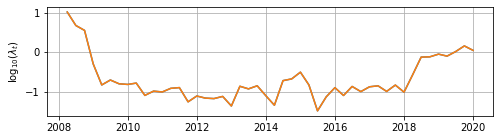

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

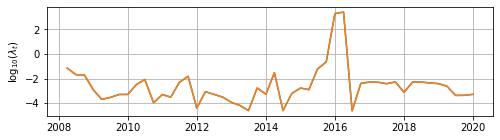

In [74]:
esnMulti_A_rw_for_1sa_2007 = esnMulti_rw_fit_1sa(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2007[0], esnMulti_A_cv10_lambda_2007[0]], 
    data=dataset2007,
    retune=True,
)

esnMulti_B_rw_for_1sa_2007 = esnMulti_rw_fit_1sa(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2007[0], esnMulti_B_cv10_lambda_2007[0]], 
    data=dataset2007,
    retune=True,
)

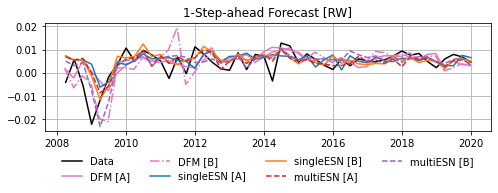

In [75]:
# Plot -- 1-Step-ahead Forecast
plt.figure(figsize=(8, 2))
plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
#
plt.plot(DFM_A_rw_forecast_2007, label="DFM [A]", c="C6") 
plt.plot(DFM_B_rw_forecast_2007, label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(esnSingle_A_agg_rw_for_1sa_2007, label="singleESN [A]", c="C0") 
plt.plot(esnSingle_B_agg_rw_for_1sa_2007, label="singleESN [B]", c="C1") 
#
plt.plot(esnMulti_A_rw_for_1sa_2007, label="multiESN [A]", c="C3", ls='--') 
plt.plot(esnMulti_B_rw_for_1sa_2007, label="multiESN [B]", c="C4", ls='--') 
#
plt.grid()
plt.title("1-Step-ahead Forecast [RW]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_forecasts_rw_2007.pdf'), bbox_inches="tight")
plt.show()

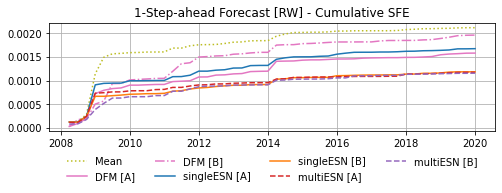

In [212]:
# Plot -- 1-Step-ahead Forecast - Cumulative SFE
plt.figure(figsize=(8, 2))
plt.grid()
#
plt.plot(cumulSFE_2007(UnMean_rw_1sa_forecast_2007), label="Mean", c="C8", ls=':')
#
plt.plot(cumulSFE_2007(DFM_A_rw_forecast_2007), label="DFM [A]", c="C6") 
plt.plot(cumulSFE_2007(DFM_B_rw_forecast_2007), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(cumulSFE_2007(esnSingle_A_agg_rw_for_1sa_2007), label="singleESN [A]", c="C0") 
plt.plot(cumulSFE_2007(esnSingle_B_agg_rw_for_1sa_2007), label="singleESN [B]", c="C1") 
#
plt.plot(cumulSFE_2007(esnMulti_A_rw_for_1sa_2007), label="multiESN [A]", c="C3", ls='--') 
plt.plot(cumulSFE_2007(esnMulti_B_rw_for_1sa_2007), label="multiESN [B]", c="C4", ls='--') 
#
#plt.yscale('log')
plt.title("1-Step-ahead Forecast [RW] - Cumulative SFE")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_cumulsfe_rw_2007.pdf'), bbox_inches="tight")
plt.show()

In [77]:
UnMean_MSE_rw_2007_td = MSFE_2007(UnMean_rw_1sa_forecast_2007) * 1e4
DFM_A_MSE_rw_2007_td = MSFE_2007(DFM_A_rw_forecast_2007) * 1e4
DMF_B_MSE_rw_2007_td = MSFE_2007(DFM_B_rw_forecast_2007) * 1e4
esnSingle_A_MSE_rw_2007_td = MSFE_2007(esnSingle_A_agg_rw_for_1sa_2007) * 1e4
esnSingle_B_MSE_rw_2007_td = MSFE_2007(esnSingle_B_agg_rw_for_1sa_2007) * 1e4
esnMulti_A_MSE_rw_2007_td = MSFE_2007(esnMulti_A_rw_for_1sa_2007) * 1e4
esnMulti_B_MSE_rw_2007_td = MSFE_2007(esnMulti_B_rw_for_1sa_2007) * 1e4

print("------------------- MSFE -------------- RMSFE -----")
print(f"Mean \t\t = {UnMean_MSE_rw_2007_td.round(4)} \t|\t"
        f"{np.sqrt(UnMean_MSE_rw_2007_td).round(4)}")
print(f"DFM [A]\t\t = {DFM_A_MSE_rw_2007_td.round(4)} \t|\t"
        f"{np.sqrt(DFM_A_MSE_rw_2007_td).round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_rw_2007_td.round(4)} \t|\t"
        f"{np.sqrt(DMF_B_MSE_rw_2007_td).round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_rw_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_A_MSE_rw_2007_td).round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_rw_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_B_MSE_rw_2007_td).round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_rw_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_A_MSE_rw_2007_td).round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_rw_2007_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_B_MSE_rw_2007_td).round(4)}")

------------------- MSFE -------------- RMSFE -----
Mean 		 = 0.4404 	|	0.6637
DFM [A]		 = 0.329 	|	0.5736
DFM [B]		 = 0.408 	|	0.6388
singleESN [A]	 = 0.3485 	|	0.5903
singleESN [B]	 = 0.2469 	|	0.4969
multiESN [A]	 = 0.2447 	|	0.4946
multiESN [B]	 = 0.241 	|	0.4909


In [78]:
ref_MSE_2007_rw = UnMean_MSE_rw_2007_td
DFM_A_MSE_toRef_2007_rw = DFM_A_MSE_rw_2007_td / ref_MSE_2007_rw
DMF_B_MSE_toRef_2007_rw = DMF_B_MSE_rw_2007_td / ref_MSE_2007_rw
esnSingle_A_MSE_toRef_2007_rw = esnSingle_A_MSE_rw_2007_td / ref_MSE_2007_rw
esnSingle_B_MSE_toRef_2007_rw = esnSingle_B_MSE_rw_2007_td / ref_MSE_2007_rw
esnMulti_A_MSE_toRef_2007_rw = esnMulti_A_MSE_rw_2007_td / ref_MSE_2007_rw
esnMulti_B_MSE_toRef_2007_rw = esnMulti_B_MSE_rw_2007_td / ref_MSE_2007_rw

print("------------------ Relative MSFE -----------")
print(f"Mean \t\t = {1.0}")
print(f"DFM [A]\t\t = {DFM_A_MSE_toRef_2007_rw.round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_toRef_2007_rw.round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_toRef_2007_rw.round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_toRef_2007_rw.round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_toRef_2007_rw.round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_toRef_2007_rw.round(4)}")

------------------ Relative MSFE -----------
Mean 		 = 1.0
DFM [A]		 = 0.7471
DFM [B]		 = 0.9264
singleESN [A]	 = 0.7912
singleESN [B]	 = 0.5605
multiESN [A]	 = 0.5555
multiESN [B]	 = 0.5471


In [80]:
mcs_data_2007_rw = pd.DataFrame(
    np.c_[UnMean_rw_1sa_forecast_2007,
        DFM_A_rw_forecast_2007,
        DFM_B_rw_forecast_2007,
        esnSingle_A_agg_rw_for_1sa_2007,
        esnSingle_B_agg_rw_for_1sa_2007,
        esnMulti_A_rw_for_1sa_2007,
        esnMulti_B_rw_for_1sa_2007,
    ],
    columns=['Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A] [RW]', 'singleESN [B] [RW]', 'multiESN [A] [RW]', 'multiESN [B] [RW]']
)
mcs_data_2007_rw = (mcs_data_2007_rw - dataset2007['GDP_data_test'].to_numpy())

mcs_25_2007_rw = ModelConfidenceSet(
    data=np.square(mcs_data_2007_rw), alpha=0.25, B=10000, w=2, algorithm='R', seed=202209
).run()
mcs_10_2007_rw = ModelConfidenceSet(
    data=np.square(mcs_data_2007_rw), alpha=0.10, B=10000, w=2, algorithm='R', seed=202209
).run()

print(f"MCS 25 included: {mcs_25_2007_rw.included}")
print(f"MCS 10 included: {mcs_10_2007_rw.included}")

MCS 25 included: ['singleESN [B] [RW]', 'multiESN [A] [RW]', 'multiESN [B] [RW]']
MCS 10 included: ['Mean', 'DFM [A]', 'singleESN [B] [RW]', 'multiESN [A] [RW]', 'multiESN [B] [RW]']


In [81]:
mcs_25_2007_rw.pvalues

DFM [B]               0.0917
singleESN [A] [RW]    0.0917
Mean                  0.1292
DFM [A]               0.1292
singleESN [B] [RW]    0.9908
multiESN [A] [RW]     0.9908
multiESN [B] [RW]     1.0000
dtype: float64

In [136]:
mcs_data_2007_rw.to_csv(
    os.path.join(path_folder, "R", "mcs_medium_rw_2007.csv")
)

#### Multi-step Point Forecast

##### Fixed Parameters

In [84]:
def UnMean_fix_fit_multistep(steps, data):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']

    GDP_test_dates = GDP_data_test.index

    forecast_fix_multistep = np.zeros((len(GDP_test_dates), steps))
    for s in range(steps):
        forecast_fix_multistep[:,s] = np.ones(len(GDP_test_dates)) * GDP_data_train.mean().to_numpy()

    return pd.DataFrame(data=forecast_fix_multistep, index=GDP_test_dates, columns=range(steps))

In [85]:
#UnMean_multistep_for_2007 = [ 
#    UnMean_1sa_forecast_2007
#for _ in range(8) ]

UnMean_fix_multistep_for_2007 = UnMean_fix_fit_multistep(
    data=dataset2007,
    steps=8,
)

In [87]:
#DFM_A_fix_multistep_for_2007 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2007['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_A_fix_multistep_for_2007.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'stock__5__6__[1, 4, 12]_fixed__2007', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )
#
#DFM_B_fix_multistep_for_2007 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2007['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_B_fix_multistep_for_2007.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'almon__5__6__[1, 4, 12]_fixed__2007', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )

DFM_slice_2007 = (
    pd.date_range('2008-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_fix_multistep_for_2007 = getDFMMultiStepAheadForecast(
    'stock__10__6__[1]_fixed__2007', steps=8, date_slice=DFM_slice_2007,
)

DFM_B_fix_multistep_for_2007 = getDFMMultiStepAheadForecast(
    'almon__10__6__[1]_fixed__2007', steps=8, date_slice=DFM_slice_2007,
)

In [88]:
def esnSingle_fix_fit_multistep(esnModel, Lambda, steps, data, direct=False, aggregate=False):
    GDP_fill_data_train = data['GDP_fill_data_train']
    GDP_fill_data_test = data['GDP_fill_data_test']
    if not aggregate:
        md_fill_data_train = data['md_fill_data_train']
        md_fill_data_test = data['md_fill_data_test']
    else:
        md_fill_data_train = data['md_fill_agg_data_train']
        md_fill_data_test = data['md_fill_agg_data_test']

    GDP_test_dates = GDP_fill_data_test.index

    GDP_fill_data_train, GDP_fill_data_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_fill_data_train, GDP_fill_data_test,
            return_mu_sig=True)
    )
    md_fill_data_train, md_fill_data_test = normalize_train_test(md_fill_data_train, md_fill_data_test)

    esnSingle_fit = esnModel.fit(
        Y=GDP_fill_data_train, z=(md_fill_data_train, ), 
        method='ridge',
        Lambda=Lambda,
        full=True,
        debug=False,
        steps=(steps if direct else 1)
    )

    if direct:
        esnSingle_for = esnModel.fixedParamsForecast(
            Yf=GDP_fill_data_test, zf=(md_fill_data_test, ),
            fit=esnSingle_fit,
        )
    else:
        esnSingle_for = esnModel.multistepForecast(
            Yf=GDP_fill_data_test, zf=(md_fill_data_test, ),
            fit=esnSingle_fit,
            steps=steps
        )

    forecast_fix_multistep = np.zeros((len(GDP_test_dates), steps))
    for s in range(steps):
        if direct:
            forecast_fix_multistep[:,s] = np.squeeze(esnSingle_for['Forecast'][s]['Y_for'].to_numpy())
        else:
            forecast_fix_multistep[:,s] = np.squeeze(esnSingle_for['multistepForecast'][s]['Y_for'].to_numpy())

    forecast_fix_multistep = forecast_fix_multistep * GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    return pd.DataFrame(data=forecast_fix_multistep, index=GDP_test_dates, columns=range(steps))

In [89]:
# Aggregated
esnSingle_A_agg_fix_multistep_for_2007 = esnSingle_fix_fit_multistep(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2007, 
    data=dataset2007,
    steps=8,
    direct=False,
    aggregate=True,
)

esnSingle_B_agg_fix_multistep_for_2007 = esnSingle_fix_fit_multistep(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2007, 
    data=dataset2007,
    steps=8,
    direct=False,
    aggregate=True,
)

In [90]:
def esnMulti_fix_fit_multistep(esnModel, Lambda, steps, data, direct=False):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']
    m_data_train = data['m_data_train']
    m_data_test = data['m_data_test']
    d_data_train = data['d_data_train']
    d_data_test = data['d_data_test']

    GDP_test_dates = GDP_data_test.index

    GDP_data_train, GDP_data_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_data_train, GDP_data_test,
            return_mu_sig=True)
    )
    m_data_train, m_data_test = normalize_train_test(m_data_train, m_data_test)
    d_data_train, d_data_test = normalize_train_test(d_data_train, d_data_test)

    esnMulti_fit = esnModel.fit(
        Y=GDP_data_train, z=(m_data_train, d_data_train),
        method='ridge',
        Lambda=Lambda,
        full=True,
        debug=False,
        steps=(steps if direct else 1)
    )

    if direct:
        esnMulti_for = esnModel.fixedParamsForecast(
            Yf=GDP_data_test, zf=(m_data_test, d_data_test),
            fit=esnMulti_fit,
        )
    else:
        esnMulti_for = esnModel.multistepForecast(
            Yf=GDP_data_test, zf=(m_data_test, d_data_test),
            fit=esnMulti_fit,
            steps=steps
        )

    forecast_fix_multistep = np.zeros((len(GDP_test_dates), steps))
    for s in range(steps):
        if direct:
            forecast_fix_multistep[:,s] = np.squeeze(esnMulti_for['Forecast'][s]['Y_for'].to_numpy())
        else:
            forecast_fix_multistep[:,s] = np.squeeze(esnMulti_for['multistepForecast'][s]['Y_for'].to_numpy())

    forecast_fix_multistep = forecast_fix_multistep * GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    return pd.DataFrame(data=forecast_fix_multistep, index=GDP_test_dates, columns=range(steps))

In [91]:
esnMulti_A_fix_multistep_for_2007 = esnMulti_fix_fit_multistep(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2007[0], esnMulti_A_cv10_lambda_2007[0]], 
    data=dataset2007,
    steps=8,
    direct=False,
)

esnMulti_B_fix_multistep_for_2007 = esnMulti_fix_fit_multistep(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2007[0], esnMulti_B_cv10_lambda_2007[0]], 
    data=dataset2007,
    steps=8,
    direct=False,
)

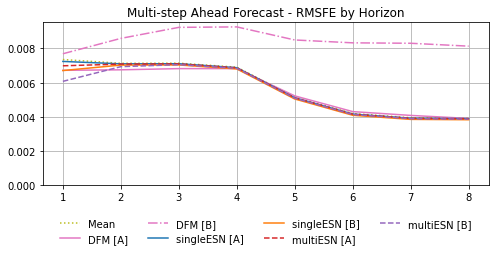

In [214]:
def hStepRMSFE_2007(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            dataset2007['GDP_data_test'].to_numpy() - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))

plt.figure(figsize=(8, 3))
plt.grid()
#
plt.plot(hStepRMSFE_2007(UnMean_fix_multistep_for_2007), label="Mean", c="C8", ls=':') 
#
plt.plot(hStepRMSFE_2007(DFM_A_fix_multistep_for_2007), label="DFM [A]", c="C6") 
plt.plot(hStepRMSFE_2007(DFM_B_fix_multistep_for_2007), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(hStepRMSFE_2007(esnSingle_A_agg_fix_multistep_for_2007), label="singleESN [A]", c="C0") 
plt.plot(hStepRMSFE_2007(esnSingle_B_agg_fix_multistep_for_2007), label="singleESN [B]", c="C1") 

plt.plot(hStepRMSFE_2007(esnMulti_A_fix_multistep_for_2007), label="multiESN [A]", c="C3", ls='--') 
plt.plot(hStepRMSFE_2007(esnMulti_B_fix_multistep_for_2007), label="multiESN [B]", c="C4", ls='--') 
#
plt.ylim(bottom=0.)
#plt.yscale('log')
plt.title("Multi-step Ahead Forecast - RMSFE by Horizon")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_msa_rmsfe-by-h_fix_2007.pdf'), bbox_inches="tight")
plt.show()

In [204]:
table_RMSFE_multistep_fix_2007 = pd.DataFrame(
    index=range(1,8)
)
table_RMSFE_multistep_fix_2007.index.name = "FIX_2007"
table_RMSFE_multistep_fix_2007["Model"] = ['Mean', 'DFM [A]', 'DFM [B]', 
        'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
    ]

for h in range(8):
    ref_h_hStepRMSFE_fix = hStepRMSFE_2007(UnMean_fix_multistep_for_2007).iat[h,0]
    table_RMSFE_multistep_fix_2007[str(h+1)] = [
        hStepRMSFE_2007(UnMean_fix_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2007(DFM_A_fix_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2007(DFM_B_fix_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2007(esnSingle_A_agg_fix_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2007(esnSingle_B_agg_fix_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2007(esnMulti_A_fix_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2007(esnMulti_B_fix_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_fix,
    ]

table_RMSFE_multistep_fix_2007.round(3)

Model      1      2      3      4      5      6      7  \
FIX_2007                                                                   
1                  Mean  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
2               DFM [A]  0.914  0.947  0.955  0.988  1.015  1.027  1.034   
3               DFM [B]  1.046  1.204  1.293  1.341  1.649  1.984  2.101   
4         singleESN [A]  0.985  0.995  0.995  0.995  0.994  0.992  0.992   
5         singleESN [B]  0.912  0.985  0.985  0.985  0.980  0.976  0.976   
6          multiESN [A]  0.950  0.993  0.994  0.994  0.992  0.990  0.990   
7          multiESN [B]  0.826  0.972  0.988  0.990  0.989  0.986  0.985   

              8  
FIX_2007         
1         1.000  
2         0.995  
3         2.070  
4         0.992  
5         0.976  
6         0.990  
7         0.985

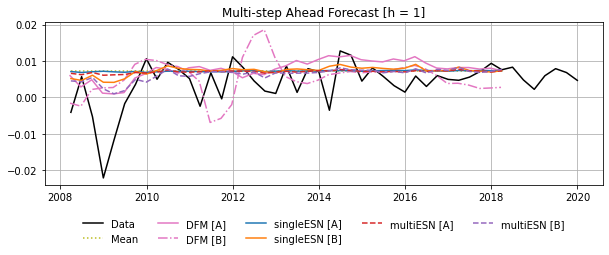

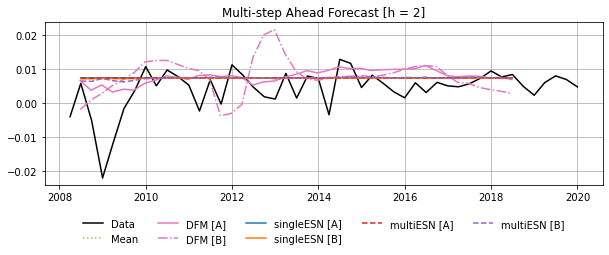

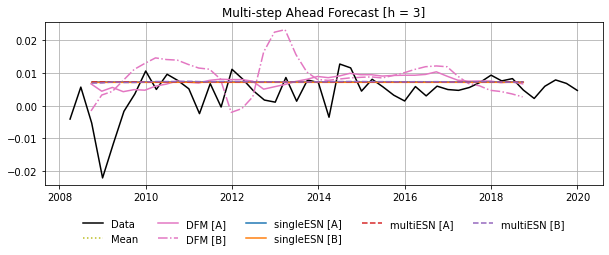

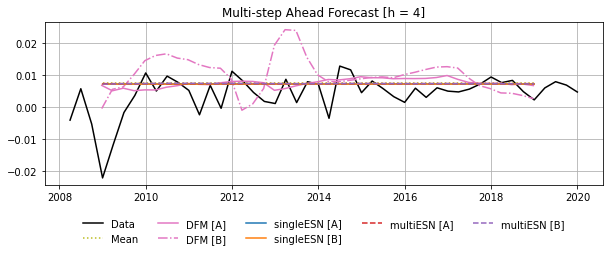

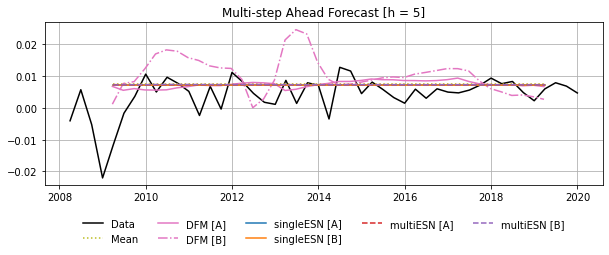

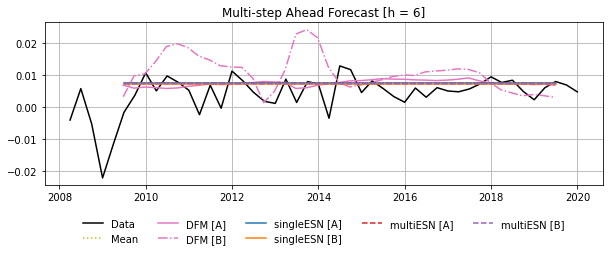

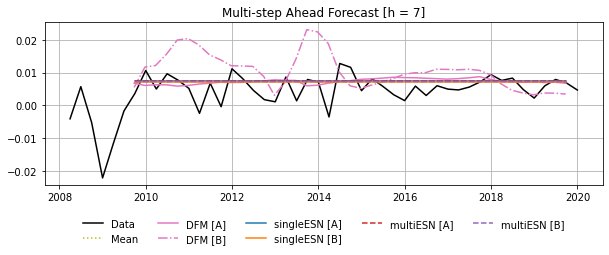

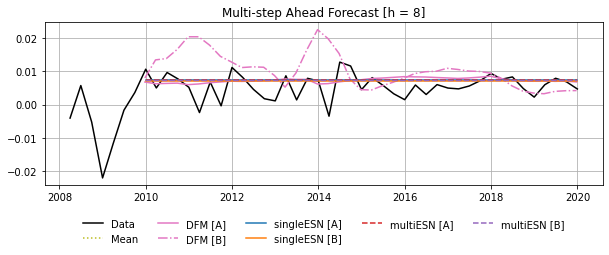

In [93]:
steps = 8
T = len(dataset2007['GDP_data_test'])
for h in range(steps):
    plt.figure(figsize=(10, 3))
    plt.grid()
    plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
    #
    plt.plot(UnMean_fix_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="Mean", c="C8", ls=':') 
    #
    plt.plot(DFM_A_fix_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="DFM [A]", c="C6") 
    plt.plot(DFM_B_fix_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="DFM [B]", c="C6", ls='-.') 
    #
    plt.plot(esnSingle_A_agg_fix_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="singleESN [A]", c="C0")
    plt.plot(esnSingle_B_agg_fix_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="singleESN [B]", c="C1") 
    #
    plt.plot(esnMulti_A_fix_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="multiESN [A]", c="C3", ls='--') 
    plt.plot(esnMulti_B_fix_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="multiESN [B]", c="C4", ls='--')
    #
    plt.title("Multi-step Ahead Forecast" + f" [h = {h+1}]")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                    frameon=False, fancybox=False, shadow=False, ncol=5)
    plt.show()

Export multi-horizon losses:

In [96]:
mhmcs_steps = 8
mhmcs_multistep_fix_2007 = xr.DataArray(
    data=np.zeros(
        (mhmcs_steps, len(dataset2007['GDP_data_test']) - mhmcs_steps, 7)
    ),
    dims=["H", "T", "M0"],
    coords={
        "M0": [
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    },
    attrs=dict(
        names=[
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    )
)

for h in range(mhmcs_steps):
    mhmcs_multistep_fix_2007[h, :, :] = np.square((
        np.c_[
            UnMean_fix_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            DFM_A_fix_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            DFM_B_fix_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_A_agg_fix_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_B_agg_fix_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_A_fix_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_B_fix_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
        ] - dataset2007['GDP_data_test'].iloc[h:(-mhmcs_steps+h),].to_numpy()))

In [97]:
mhmcs_multistep_fix_2007_df = mhmcs_multistep_fix_2007.to_dataframe(
    name="Loss", dim_order=['M0', 'H', 'T']
)
mhmcs_multistep_fix_2007_df.to_csv(
    os.path.join(path_folder, "R", "mhmcs_medium_multistep_fix_2007.csv")
)

##### Expanding Window

In [98]:
def UnMean_ew_fit_multistep(steps, data):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']

    GDP_test_dates = GDP_data_test.index

    forecast_ew_multistep = np.zeros((len(GDP_test_dates), steps))
    for j in tqdm(range(len(GDP_data_test)), desc=" EW", position=1, leave=False):
        if j > 0:
            GDP_data_train_j = pd.concat([
                GDP_data_train,
                GDP_data_test.iloc[0:j,]
            ])
        else:
            GDP_data_train_j = GDP_data_train

        for_j = np.zeros(steps)
        T_train = len(GDP_data_train_j)
        for s in range(steps):
            for_j[s] = GDP_data_train_j.iloc[:(T_train-s),:].mean().iloc[0]

        forecast_ew_multistep[j,:] = for_j

    return pd.DataFrame(data=forecast_ew_multistep, index=GDP_test_dates, columns=range(steps))

In [99]:
UnMean_ew_multistep_for_2007 = UnMean_ew_fit_multistep(
    data=dataset2007,
    steps=8,
)

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

In [100]:
#DFM_A_ew_multistep_for_2007 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2007['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_A_ew_multistep_for_2007.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'stock__5__6__[1, 4, 12]_expanding__2007', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )
#
#DFM_B_ew_multistep_for_2007 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2007['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_B_ew_multistep_for_2007.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'almon__5__6__[1, 4, 12]_expanding__2007', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )

DFM_slice_2007 = (
    pd.date_range('2008-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_ew_multistep_for_2007 = getDFMMultiStepAheadForecast(
    'stock__10__6__[1]_expanding__2007', steps=8, date_slice=DFM_slice_2007,
)

DFM_B_ew_multistep_for_2007 = getDFMMultiStepAheadForecast(
    'almon__10__6__[1]_expanding__2007', steps=8, date_slice=DFM_slice_2007,
)

In [101]:
def esnSingle_ew_fit_multistep(esnModel, Lambda, steps, data, direct=False, retune=False, aggregate=False):
    GDP_fill_data_train = data['GDP_fill_data_train']
    GDP_fill_data_test = data['GDP_fill_data_test']
    if not aggregate:
        md_fill_data_train = data['md_fill_data_train']
        md_fill_data_test = data['md_fill_data_test']
    else:
        md_fill_data_train = data['md_fill_agg_data_train']
        md_fill_data_test = data['md_fill_agg_data_test']

    GDP_test_dates = GDP_fill_data_test.index

    if retune:  Lambdas = []

    forecast_ew_multistep = np.zeros((len(GDP_test_dates), steps))
    W_list = []
    L_list = []
    for j in tqdm(range(len(GDP_fill_data_test)), desc=" EW", position=1, leave=False):
        if j > 0:
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            md_fill_data_train_j = pd.concat([
                md_fill_data_train, 
                md_fill_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            md_fill_data_test_j = md_fill_data_test.loc[[GDP_test_dates[j-1]],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            md_fill_data_train_j = md_fill_data_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            md_fill_data_test_j = md_fill_data_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, GDP_mu_train_j, GDP_sig_train_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        md_fill_data_train_j, md_fill_data_test_j = (
            normalize_train_test(md_fill_data_train_j, md_fill_data_test_j)
        )

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ),
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnSingle_fit = esnModel.fit(
            Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ), 
            method='ridge',
            Lambda=Lambda_j,
            full=True,
            debug=False,
            steps=(steps if direct else 1)
        )

        W_list.append(esnSingle_fit['fit_for'][0]['W'])
        L_list.append(np.max(np.abs(np.linalg.eig(
            esnModel.models_[0].A_ + esnModel.models_[0].C_ @ 
                esnSingle_fit['fit_comp_ar'][0][1:,:].T
        )[0])))

        if direct:
            esnSingle_for = esnModel.fixedParamsForecast(
                Yf=GDP_fill_data_test_j, zf=(md_fill_data_test_j, ),
                fit=esnSingle_fit,
            )
        else:
            esnSingle_for = esnModel.multistepForecast(
                Yf=GDP_fill_data_test_j, zf=(md_fill_data_test_j, ),
                fit=esnSingle_fit,
                steps=steps
            )

        for_j = np.zeros(steps)
        for s in range(steps):
            if direct:
                for_j[s] = esnSingle_for['Forecast'][s]['Y_for'][0]
            else:
                for_j[s] = esnSingle_for['multistepForecast'][s]['Y_for'][0]

        forecast_ew_multistep[j,:] = for_j * GDP_sig_train_j.to_numpy() + GDP_mu_train_j.to_numpy()

    _, axs = plt.subplots(1, 2, figsize=(8,2))
    axs[0].plot(np.array([np.linalg.norm(w) for w in W_list]), c="C0")
    axs[0].grid()
    axs[0].set_title("||W||")
    axs[1].plot(np.array(L_list), c="C1")
    axs[1].grid()
    axs[1].set_title("\lambda_1(A + CW')")

    if retune:
        plt.figure(figsize=(8,2))
        for l in range(len(Lambda_j)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_ew_multistep, index=GDP_test_dates, columns=range(steps))

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

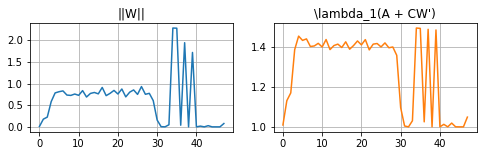

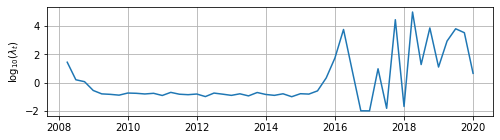

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

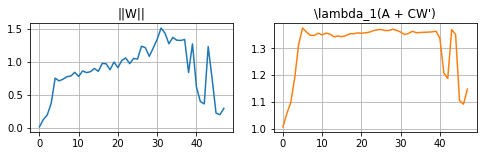

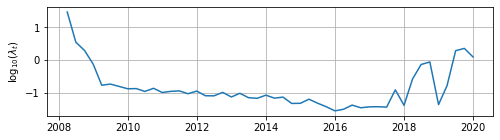

In [102]:
# Aggregated
esnSingle_A_agg_ew_multistep_for_2007 = esnSingle_ew_fit_multistep(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2007, 
    data=dataset2007,
    steps=8,
    direct=False,
    retune=True,
    aggregate=True,
)

esnSingle_B_agg_ew_multistep_for_2007 = esnSingle_ew_fit_multistep(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2007, 
    data=dataset2007,
    steps=8,
    direct=False,
    retune=True,
    aggregate=True,
)

In [103]:
def esnMulti_ew_fit_multistep(esnModel, Lambda, steps, data, direct=False, retune=False):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']
    m_data_train = data['m_data_train']
    m_data_test = data['m_data_test']
    d_data_train = data['d_data_train']
    d_data_test = data['d_data_test']

    GDP_test_dates = GDP_data_test.index

    if retune:  Lambdas = []

    forecast_ew_multistep = np.zeros((len(GDP_data_test), steps))
    W_list = []
    for j in tqdm(range(len(GDP_data_test)), desc=" EW", position=1, leave=False):
        if j > 0:
            GDP_data_train_j = pd.concat([
                GDP_data_train,
                GDP_data_test.iloc[0:j,]
            ])
            m_data_train_j = pd.concat([
                m_data_train,
                m_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            d_data_train_j = pd.concat([
                d_data_train,
                d_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            GDP_data_test_j = GDP_data_test.iloc[[j],]
            m_data_test_j = m_data_test.loc[[m_data_train_j.index[-1]],]
            d_data_test_j = d_data_test.loc[[d_data_train_j.index[-1]],]
        else:
            GDP_data_train_j = GDP_data_train
            m_data_train_j = m_data_train
            d_data_train_j = d_data_train
            GDP_data_test_j = GDP_data_test.iloc[[0],]
            m_data_test_j = m_data_test.iloc[[0],]
            d_data_test_j = d_data_test.iloc[[0],]

        # Normalize
        GDP_data_train_j, GDP_data_test_j, GDP_mu_train_j, GDP_sig_train_j = (
            normalize_train_test(GDP_data_train_j, GDP_data_test_j,
                return_mu_sig=True)
        )
        m_data_train_j, m_data_test_j = (
            normalize_train_test(m_data_train_j, m_data_test_j)
        )
        d_data_train_j, d_data_test_j = (
            normalize_train_test(d_data_train_j, d_data_test_j)
        )

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j), 
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambda_j = [Lambda_j[0], Lambda_j[0]]
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnMulti_fit = esnModel.fit(
            Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j),
            method='ridge',
            Lambda=Lambda_j,
            full=True,
            debug=False,
            steps=(steps if direct else 1)
        )

        W_list.append(esnMulti_fit['fit_for'][0]['W'])

        if direct:
            esnMulti_for = esnModel.fixedParamsForecast(
                Yf=GDP_data_test_j, zf=(m_data_test_j, d_data_test_j),
                fit=esnMulti_fit,
            )
        else:
            esnMulti_for = esnModel.multistepForecast(
                Yf=GDP_data_test_j, zf=(m_data_test_j, d_data_test_j),
                fit=esnMulti_fit,
                steps=steps
            )

        for_j = np.zeros(steps)
        for s in range(steps):
            if direct:
                for_j[s] = esnMulti_for['Forecast'][s]['Y_for'][0]
            else:
                for_j[s] = esnMulti_for['multistepForecast'][s]['Y_for'][0]

        forecast_ew_multistep[j,:] = for_j * GDP_sig_train_j.to_numpy() + GDP_mu_train_j.to_numpy()

    plt.figure(figsize=(8,2))
    plt.plot(np.array([np.linalg.norm(w) for w in W_list]))
    plt.grid()
    plt.title("||W||")

    if retune:
        plt.figure(figsize=(8,2))
        for l in range(len(Lambda_j)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_ew_multistep, index=GDP_test_dates, columns=range(steps))

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

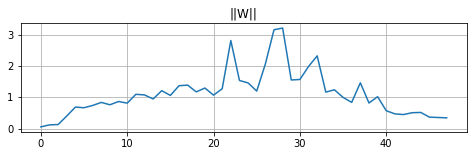

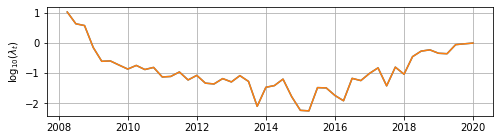

 EW:   0%|          | 0/48 [00:00<?, ?it/s]

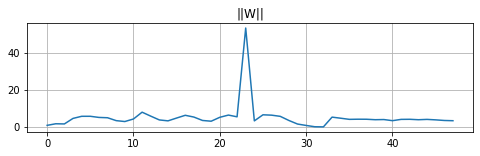

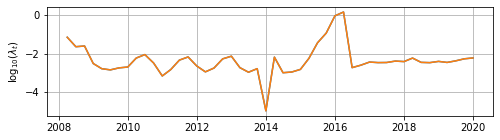

In [104]:
esnMulti_A_ew_multistep_for_2007 = esnMulti_ew_fit_multistep(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2007[0], esnMulti_A_cv10_lambda_2007[0]], 
    data=dataset2007,
    steps=8,
    direct=False,
    retune=True,
)

esnMulti_B_ew_multistep_for_2007 = esnMulti_ew_fit_multistep(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2007[0], esnMulti_B_cv10_lambda_2007[0]], 
    data=dataset2007,
    steps=8,
    direct=False,
    retune=True,
)

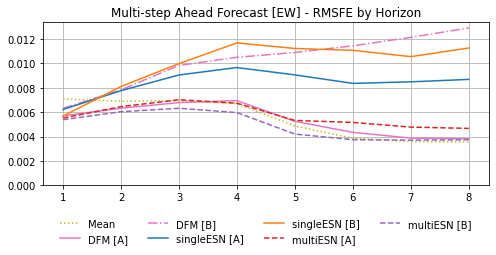

In [215]:
def hStepRMSFE_2007(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            dataset2007['GDP_data_test'].to_numpy() - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))

plt.figure(figsize=(8, 3))
plt.grid()
#
plt.plot(hStepRMSFE_2007(UnMean_ew_multistep_for_2007), label="Mean", c="C8", ls=':') 
#
plt.plot(hStepRMSFE_2007(DFM_A_ew_multistep_for_2007), label="DFM [A]", c="C6") 
plt.plot(hStepRMSFE_2007(DFM_B_ew_multistep_for_2007), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(hStepRMSFE_2007(esnSingle_A_agg_ew_multistep_for_2007), label="singleESN [A]", c="C0") 
plt.plot(hStepRMSFE_2007(esnSingle_B_agg_ew_multistep_for_2007), label="singleESN [B]", c="C1") 
#
plt.plot(hStepRMSFE_2007(esnMulti_A_ew_multistep_for_2007), label="multiESN [A]", c="C3", ls='--') 
plt.plot(hStepRMSFE_2007(esnMulti_B_ew_multistep_for_2007), label="multiESN [B]", c="C4", ls='--') 
#
plt.ylim(bottom=0.)
#plt.yscale('log')
plt.title("Multi-step Ahead Forecast [EW] - RMSFE by Horizon")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_msa_rmsfe-by-h_ew_2007.pdf'), bbox_inches="tight")
plt.show()

In [114]:
table_RMSFE_multistep_ew_2007 = pd.DataFrame(
    index=range(1,8)
)
table_RMSFE_multistep_ew_2007.index.name = "EW_2007"
table_RMSFE_multistep_ew_2007["Model"] = ['Mean', 'DFM [A]', 'DFM [B]', 
        'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
    ]

for h in range(8):
    ref_h_hStepRMSFE_ew = hStepRMSFE_2007(UnMean_ew_multistep_for_2007).iat[h,0]
    table_RMSFE_multistep_ew_2007[str(h+1)] = [
        hStepRMSFE_2007(UnMean_ew_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2007(DFM_A_ew_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2007(DFM_B_ew_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2007(esnSingle_A_agg_ew_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2007(esnSingle_B_agg_ew_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2007(esnMulti_A_ew_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2007(esnMulti_B_ew_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_ew,
    ]

table_RMSFE_multistep_ew_2007.round(3)

Model      1      2      3      4      5      6      7      8
EW_2007                                                                       
1                 Mean  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
2              DFM [A]  0.805  0.916  0.978  1.038  1.077  1.126  1.077  1.073
3              DFM [B]  0.893  1.134  1.418  1.567  2.238  2.964  3.375  3.629
4        singleESN [A]  0.879  1.125  1.305  1.442  1.860  2.166  2.361  2.443
5        singleESN [B]  0.802  1.174  1.439  1.744  2.305  2.869  2.935  3.167
6         multiESN [A]  0.780  0.935  1.012  1.005  1.093  1.337  1.328  1.313
7         multiESN [B]  0.760  0.874  0.911  0.891  0.863  0.971  1.030  1.051

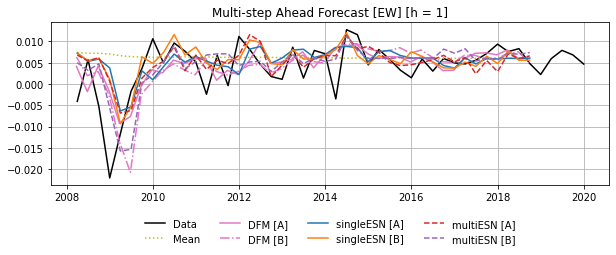

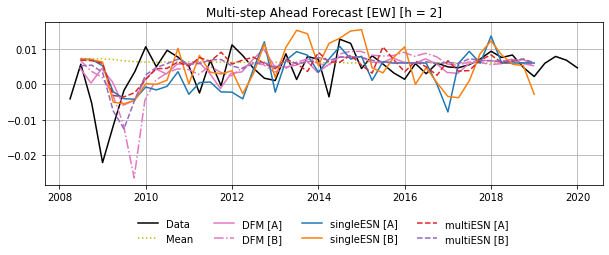

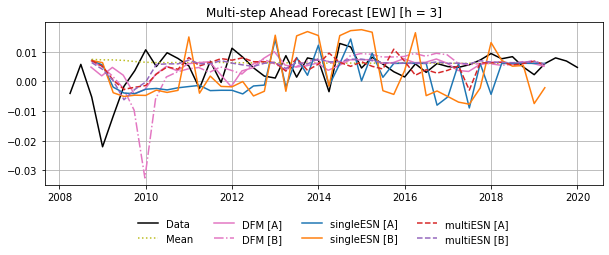

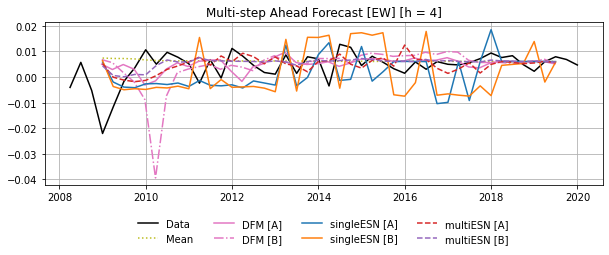

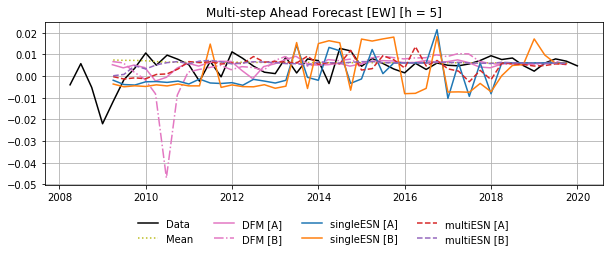

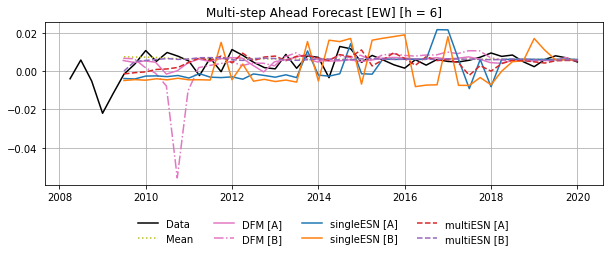

In [107]:
steps = 6
T = len(dataset2007['GDP_data_test'])
for h in range(steps):
    plt.figure(figsize=(10, 3))
    plt.grid()
    plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
    #
    plt.plot(UnMean_ew_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="Mean", c="C8", ls=':') 
    #
    plt.plot(DFM_A_ew_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="DFM [A]", c="C6") 
    plt.plot(DFM_B_ew_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="DFM [B]", c="C6", ls='-.') 
    #
    plt.plot(esnSingle_A_agg_ew_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="singleESN [A]", c="C0")
    plt.plot(esnSingle_B_agg_ew_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="singleESN [B]", c="C1") 
    #
    plt.plot(esnMulti_A_ew_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="multiESN [A]", c="C3", ls='--') 
    plt.plot(esnMulti_B_ew_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="multiESN [B]", c="C4", ls='--')
    #
    plt.title("Multi-step Ahead Forecast [EW]" + f" [h = {h+1}]")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                    frameon=False, fancybox=False, shadow=False, ncol=4)
    plt.show()

Export multi-horizon losses:

In [108]:
mhmcs_steps = 8
mhmcs_multistep_ew_2007 = xr.DataArray(
    data=np.zeros(
        (mhmcs_steps, len(dataset2007['GDP_data_test']) - mhmcs_steps, 7)
    ),
    dims=["H", "T", "M0"],
    coords={
        "M0": [
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    },
    attrs=dict(
        names=[
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    )
)

for h in range(mhmcs_steps):
    mhmcs_multistep_ew_2007[h, :, :] = np.square((
        np.c_[
            UnMean_ew_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            DFM_A_ew_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            DFM_B_ew_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_A_agg_ew_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_B_agg_ew_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_A_ew_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_B_ew_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
        ] - dataset2007['GDP_data_test'].iloc[h:(-mhmcs_steps+h),].to_numpy()))

In [109]:
mhmcs_multistep_ew_2007_df = mhmcs_multistep_ew_2007.to_dataframe(
    name="Loss", dim_order=['M0', 'H', 'T']
)
mhmcs_multistep_ew_2007_df.to_csv(
    os.path.join(path_folder, "R", "mhmcs_medium_multistep_ew_2007.csv")
)

##### Rolling Window

In [110]:
def UnMean_rw_fit_multistep(steps, data):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']

    GDP_test_dates = GDP_data_test.index

    forecast_rw_multistep = np.zeros((len(GDP_test_dates), steps))
    for j in tqdm(range(len(GDP_data_test)), desc=" RW", position=1, leave=False):
        if j > 0:
            GDP_data_train_j = pd.concat([
                GDP_data_train,
                GDP_data_test.iloc[0:j,]
            ]).iloc[j:,]
        else:
            GDP_data_train_j = GDP_data_train

        for_j = np.zeros(steps)
        T_train = len(GDP_data_train_j)
        for s in range(steps):
            js_idx = np.max((0,(j-s))) if j > 0 else 0
            for_j[s] = GDP_data_train_j.iloc[js_idx:(T_train-s),:].mean().iloc[0]

        forecast_rw_multistep[j,:] = for_j

    return pd.DataFrame(data=forecast_rw_multistep, index=GDP_test_dates, columns=range(steps))

In [122]:
UnMean_rw_multistep_for_2007 = UnMean_rw_fit_multistep(
    data=dataset2007,
    steps=8
)

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

In [115]:
#DFM_A_rw_multistep_for_2007 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2007['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_A_rw_multistep_for_2007.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'stock__5__6__[1, 4, 12]_window__2007', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )
#
#DFM_B_rw_multistep_for_2007 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2007['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_B_rw_multistep_for_2007.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'almon__5__6__[1, 4, 12]_window__2007', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )

DFM_slice_2007 = (
    pd.date_range('2008-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_rw_multistep_for_2007 = getDFMMultiStepAheadForecast(
    'stock__10__6__[1]_window__2007', steps=8, date_slice=DFM_slice_2007,
)

DFM_B_rw_multistep_for_2007 = getDFMMultiStepAheadForecast(
    'almon__10__6__[1]_window__2007', steps=8, date_slice=DFM_slice_2007,
)

In [116]:
def esnSingle_rw_fit_multistep(esnModel, Lambda, steps, data, direct=False, retune=False, aggregate=False):
    GDP_fill_data_train = data['GDP_fill_data_train']
    GDP_fill_data_test = data['GDP_fill_data_test']
    if not aggregate:
        md_fill_data_train = data['md_fill_data_train']
        md_fill_data_test = data['md_fill_data_test']
    else:
        md_fill_data_train = data['md_fill_agg_data_train']
        md_fill_data_test = data['md_fill_agg_data_test']

    GDP_test_dates = GDP_fill_data_test.index
    GDP_dates = GDP_fill_data_train.index.append(GDP_fill_data_test.index)

    if retune:  Lambdas = []

    forecast_rw_multistep = np.zeros((len(GDP_test_dates), steps))
    W_list = []
    L_list = []
    for j in tqdm(range(len(GDP_fill_data_test)), desc=" RW", position=1, leave=False):
        if j > 0:
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train,
                GDP_fill_data_test.iloc[0:j,]
            ]).iloc[j:,]
            md_fill_data_train_j = pd.concat([
                md_fill_data_train,
                md_fill_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            md_fill_data_train_j = md_fill_data_train_j[GDP_dates[j-1]:]
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            md_fill_data_test_j = md_fill_data_test.loc[[GDP_test_dates[j-1]],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            md_fill_data_train_j = md_fill_data_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            md_fill_data_test_j = md_fill_data_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, GDP_mu_train_j, GDP_sig_train_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        md_fill_data_train_j, md_fill_data_test_j = (
            normalize_train_test(md_fill_data_train_j, md_fill_data_test_j)
        )

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ),
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnSingle_fit = esnModel.fit(
            Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ), 
            method='ridge',
            Lambda=Lambda_j,
            full=True,
            debug=False,
            steps=(steps if direct else 1)
        )

        W_list.append(esnSingle_fit['fit_for'][0]['W'])
        L_list.append(np.max(np.abs(np.linalg.eig(
            esnModel.models_[0].A_ + esnModel.models_[0].C_ @ 
                esnSingle_fit['fit_comp_ar'][0][1:,:].T
        )[0])))

        if direct:
            esnSingle_for = esnModel.fixedParamsForecast(
                Yf=GDP_fill_data_test_j, zf=(md_fill_data_test_j, ),
                fit=esnSingle_fit,
            )
        else:
            esnSingle_for = esnModel.multistepForecast(
                Yf=GDP_fill_data_test_j, zf=(md_fill_data_test_j, ),
                fit=esnSingle_fit,
                steps=steps
            )

        for_j = np.zeros(steps)
        for s in range(steps):
            if direct:
                for_j[s] = esnSingle_for['Forecast'][s]['Y_for'][0]
            else:
                for_j[s] = esnSingle_for['multistepForecast'][s]['Y_for'][0]

        forecast_rw_multistep[j,:] = for_j * GDP_sig_train_j.to_numpy() + GDP_mu_train_j.to_numpy()

    _, axs = plt.subplots(1, 2, figsize=(8,2))
    axs[0].plot(np.array([np.linalg.norm(w) for w in W_list]), c="C0")
    axs[0].grid()
    axs[0].set_title("||W||")
    axs[1].plot(np.array(L_list), c="C1")
    axs[1].grid()
    axs[1].set_title("\lambda_1(A + CW')")

    if retune:
        plt.figure(figsize=(8,2))
        for l in range(len(Lambda_j)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_rw_multistep, index=GDP_test_dates, columns=range(steps))

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

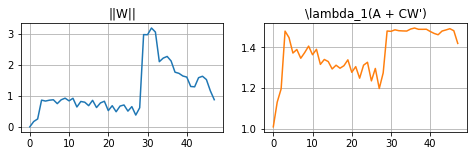

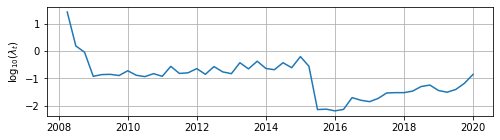

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

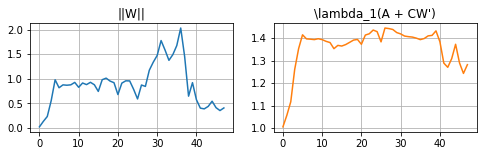

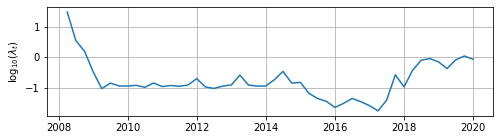

In [118]:
# Aggregated
esnSingle_A_agg_rw_multistep_for_2007 = esnSingle_rw_fit_multistep(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2007, 
    data=dataset2007,
    steps=8,
    direct=False,
    retune=True,
    aggregate=True,
)

esnSingle_B_agg_rw_multistep_for_2007 = esnSingle_rw_fit_multistep(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2007, 
    data=dataset2007,
    steps=8,
    direct=False,
    retune=True,
    aggregate=True,
)

In [119]:
def esnMulti_rw_fit_multistep(esnModel, Lambda, steps, data, direct=False, retune=False):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']
    m_data_train = data['m_data_train']
    m_data_test = data['m_data_test']
    d_data_train = data['d_data_train']
    d_data_test = data['d_data_test']

    GDP_test_dates = GDP_data_test.index
    GDP_dates = GDP_data_train.index.append(GDP_data_test.index)

    if retune:  Lambdas = []

    forecast_rw_multistep = np.zeros((len(GDP_data_test), steps))
    W_list = []
    for j in tqdm(range(len(GDP_data_test)), desc=" RW", position=1, leave=False):
        if j > 0:
            GDP_data_train_j = pd.concat([
                GDP_data_train,
                GDP_data_test.iloc[0:j,]
            ]).iloc[j:,]
            m_data_train_j = pd.concat([
                m_data_train,
                m_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            d_data_train_j = pd.concat([
                d_data_train,
                d_data_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            m_data_train_j = m_data_train_j[GDP_dates[j-1]:]
            d_data_train_j = d_data_train_j[GDP_dates[j-1]:]
            GDP_data_test_j = GDP_data_test.iloc[[j],]
            m_data_test_j = m_data_test.loc[[m_data_train_j.index[-1]],]
            d_data_test_j = d_data_test.loc[[d_data_train_j.index[-1]],]
        else:
            GDP_data_train_j = GDP_data_train
            m_data_train_j = m_data_train
            d_data_train_j = d_data_train
            GDP_data_test_j = GDP_data_test.iloc[[0],]
            m_data_test_j = m_data_test.iloc[[0],]
            d_data_test_j = d_data_test.iloc[[0],]

        # Normalize
        GDP_data_train_j, GDP_data_test_j, GDP_mu_train_j, GDP_sig_train_j = (
            normalize_train_test(GDP_data_train_j, GDP_data_test_j,
                return_mu_sig=True)
        )
        m_data_train_j, m_data_test_j = (
            normalize_train_test(m_data_train_j, m_data_test_j)
        )
        d_data_train_j, d_data_test_j = (
            normalize_train_test(d_data_train_j, d_data_test_j)
        )

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j), 
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambda_j = [Lambda_j[0], Lambda_j[0]]
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnMulti_fit = esnModel.fit(
            Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j),
            method='ridge',
            Lambda=Lambda_j,
            full=True,
            debug=False,
            steps=(steps if direct else 1)
        )

        W_list.append(esnMulti_fit['fit_for'][0]['W'])

        if direct:
            esnMulti_for = esnModel.fixedParamsForecast(
                Yf=GDP_data_test_j, zf=(m_data_test_j, d_data_test_j),
                fit=esnMulti_fit,
            )
        else:
            esnMulti_for = esnModel.multistepForecast(
                Yf=GDP_data_test_j, zf=(m_data_test_j, d_data_test_j),
                fit=esnMulti_fit,
                steps=steps
            )

        for_j = np.zeros(steps)
        for s in range(steps):
            if direct:
                for_j[s] = esnMulti_for['Forecast'][s]['Y_for'][0]
            else:
                for_j[s] = esnMulti_for['multistepForecast'][s]['Y_for'][0]

        forecast_rw_multistep[j,:] = for_j * GDP_sig_train_j.to_numpy() + GDP_mu_train_j.to_numpy()

    plt.figure(figsize=(8,2))
    plt.plot(np.array([np.linalg.norm(w) for w in W_list]))
    plt.grid()
    plt.title("||W||")

    if retune:
        plt.figure(figsize=(8,2))
        for l in range(len(Lambda_j)):
            plt.plot(GDP_test_dates, np.log10(np.array([lam[l] for lam in Lambdas])))
        plt.ylabel("$\log_{10}(\lambda_t)$")
        plt.grid()
        plt.show()

    return pd.DataFrame(data=forecast_rw_multistep, index=GDP_test_dates, columns=range(steps))

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

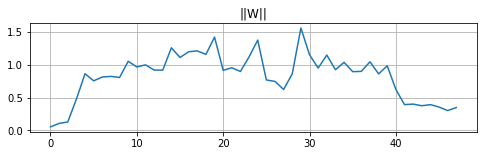

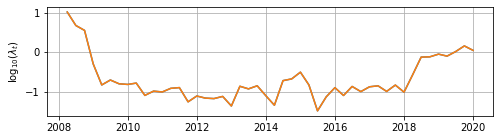

 RW:   0%|          | 0/48 [00:00<?, ?it/s]

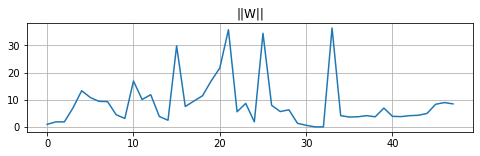

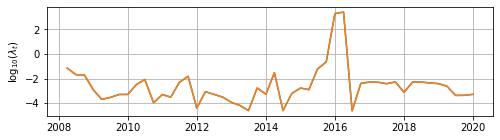

In [120]:
esnMulti_A_rw_multistep_for_2007 = esnMulti_rw_fit_multistep(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2007[0], esnMulti_A_cv10_lambda_2007[0]], 
    data=dataset2007,
    steps=8,
    direct=False,
    retune=True,
)

esnMulti_B_rw_multistep_for_2007 = esnMulti_rw_fit_multistep(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2007[0], esnMulti_B_cv10_lambda_2007[0]],
    data=dataset2007,
    steps=8,
    direct=False,
    retune=True,
)

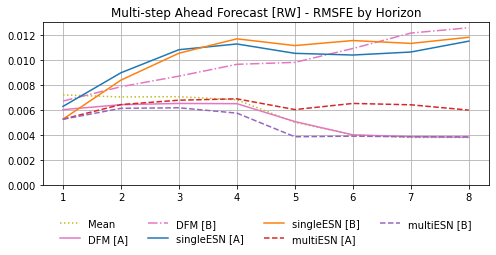

In [216]:
def hStepRMSFE_2007(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            dataset2007['GDP_data_test'].to_numpy() - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))

plt.figure(figsize=(8, 3))
plt.grid()
#
plt.plot(hStepRMSFE_2007(UnMean_rw_multistep_for_2007), label="Mean", c="C8", ls=':') 
#
plt.plot(hStepRMSFE_2007(DFM_A_rw_multistep_for_2007), label="DFM [A]", c="C6") 
plt.plot(hStepRMSFE_2007(DFM_B_rw_multistep_for_2007), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(hStepRMSFE_2007(esnSingle_A_agg_rw_multistep_for_2007), label="singleESN [A]", c="C0") 
plt.plot(hStepRMSFE_2007(esnSingle_B_agg_rw_multistep_for_2007), label="singleESN [B]", c="C1") 
#
plt.plot(hStepRMSFE_2007(esnMulti_A_rw_multistep_for_2007), label="multiESN [A]", c="C3", ls='--') 
plt.plot(hStepRMSFE_2007(esnMulti_B_rw_multistep_for_2007), label="multiESN [B]", c="C4", ls='--') 
#
plt.ylim(bottom=0.)
#plt.yscale('log')
plt.title("Multi-step Ahead Forecast [RW] - RMSFE by Horizon")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_msa_rmsfe-by-h_rw_2007.pdf'), bbox_inches="tight")
plt.show()

In [124]:
table_RMSFE_multistep_rw_2007 = pd.DataFrame(
    index=range(1,8)
)
table_RMSFE_multistep_rw_2007.index.name = "RW_2007"
table_RMSFE_multistep_rw_2007["Model"] = ['Mean', 'DFM [A]', 'DFM [B]', 
        'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
    ]

for h in range(8):
    ref_h_hStepRMSFE_rw = hStepRMSFE_2007(UnMean_rw_multistep_for_2007).iat[h,0]
    table_RMSFE_multistep_rw_2007[str(h+1)] = [
        hStepRMSFE_2007(UnMean_rw_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2007(DFM_A_rw_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2007(DFM_B_rw_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2007(esnSingle_A_agg_rw_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2007(esnSingle_B_agg_rw_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2007(esnMulti_A_rw_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2007(esnMulti_B_rw_multistep_for_2007).iat[h,0] / ref_h_hStepRMSFE_rw,
    ]

table_RMSFE_multistep_rw_2007.round(3)

Model      1      2      3      4      5      6      7      8
RW_2007                                                                       
1                 Mean  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
2              DFM [A]  0.837  0.913  0.924  0.954  1.012  0.997  1.018  1.005
3              DFM [B]  0.932  1.116  1.232  1.414  1.952  2.704  3.183  3.294
4        singleESN [A]  0.873  1.274  1.530  1.652  2.095  2.575  2.786  3.014
5        singleESN [B]  0.732  1.190  1.490  1.712  2.218  2.861  2.967  3.094
6         multiESN [A]  0.732  0.914  0.960  1.011  1.202  1.618  1.683  1.572
7         multiESN [B]  0.731  0.871  0.875  0.844  0.771  0.971  1.014  1.014

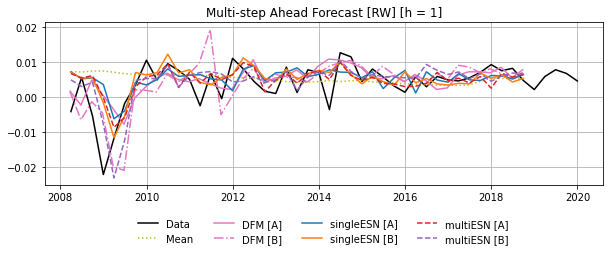

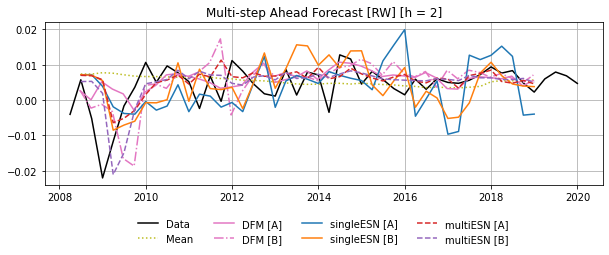

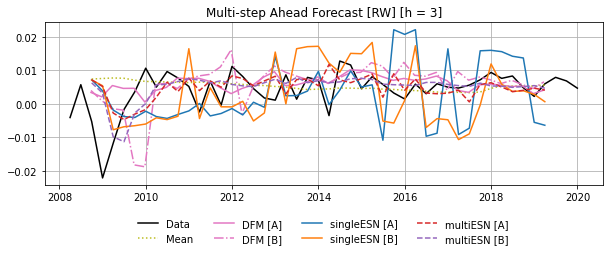

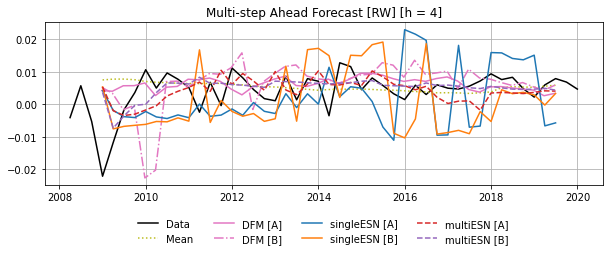

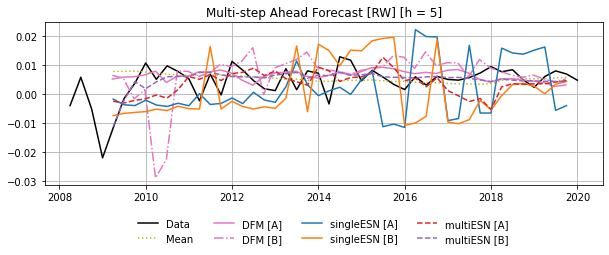

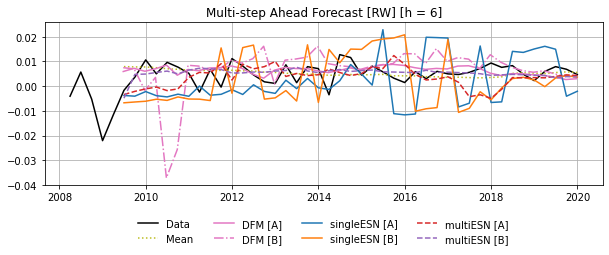

In [125]:
steps = 6
T = len(dataset2007['GDP_data_test'])
for h in range(steps):
    plt.figure(figsize=(10, 3))
    plt.grid()
    plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
    #
    plt.plot(UnMean_rw_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="Mean", c="C8", ls=':') 
    #
    plt.plot(DFM_A_rw_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="DFM [A]", c="C6") 
    plt.plot(DFM_B_rw_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="DFM [B]", c="C6", ls='-.') 
    #
    plt.plot(esnSingle_A_agg_rw_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="singleESN [A]", c="C0")
    plt.plot(esnSingle_B_agg_rw_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="singleESN [B]", c="C1") 
    #
    plt.plot(esnMulti_A_rw_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="multiESN [A]", c="C3", ls='--') 
    plt.plot(esnMulti_B_rw_multistep_for_2007[h].iloc[h:(T-steps+h+1),], label="multiESN [B]", c="C4", ls='--')
    #
    plt.title("Multi-step Ahead Forecast [RW]" + f" [h = {h+1}]")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                    frameon=False, fancybox=False, shadow=False, ncol=4)
    plt.show()

In [126]:
mhmcs_steps = 8
mhmcs_multistep_rw_2007 = xr.DataArray(
     data=np.zeros(
        (mhmcs_steps, len(dataset2007['GDP_data_test']) - mhmcs_steps, 7)
    ),
    dims=["H", "T", "M0"],
    coords={
        "M0": [
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    },
    attrs=dict(
        names=[
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    )
)

for h in range(mhmcs_steps):
    mhmcs_multistep_rw_2007[h, :, :] = (
        np.c_[
            UnMean_rw_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            DFM_A_rw_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            DFM_B_rw_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_A_agg_rw_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_B_agg_rw_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_A_rw_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_B_rw_multistep_for_2007[h].iloc[h:(-mhmcs_steps+h),],
        ] - dataset2007['GDP_data_test'].iloc[h:(-mhmcs_steps+h),].to_numpy())

In [127]:
mhmcs_multistep_rw_2007_df = mhmcs_multistep_rw_2007.to_dataframe(
    name="Loss", dim_order=['M0', 'H', 'T']
)
mhmcs_multistep_rw_2007_df.to_csv(
    os.path.join(path_folder, "R", "mhmcs_medium_multistep_rw_2007.csv")
)

### Post-Crisis Model Evaluation

In [128]:
dataset2011 = getMediumDatasets('2011-12-31')

##### ESN Ridge CV

Get 'extended' dataset to have enough CV data:

In [129]:
dataset2011_ext = getMediumDatasets_extended(
    '1975-01-01', '2019-12-31', trainTestSplitDate='2011-12-31'
)

Single ESN:

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
. Folds built


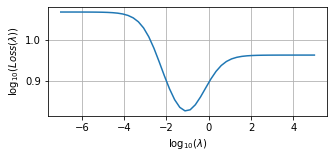

+ s = 0 --------------------
Best solution found:
lambda = [0.08734885]
F      = 6.694763070713011


In [130]:
# Aggregated
esnSingle_A_agg_cv10_lambda_2011 = esnSingle_A.ridge_lambda_cv(
    Y=dataset2011_ext['GDP_fill_data_train'], z=(dataset2011_ext['md_fill_agg_data_train'], ),
    method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    steps=1,
    debug=True,
)

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
. Folds built


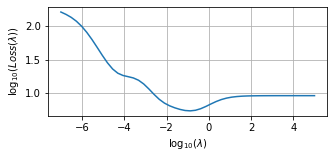

+ s = 0 --------------------
Best solution found:
lambda = [0.1254596]
F      = 5.45545452319712


In [131]:
esnSingle_B_agg_cv10_lambda_2011 = esnSingle_B.ridge_lambda_cv(
    Y=dataset2011_ext['GDP_fill_data_train'], z=(dataset2011_ext['md_fill_agg_data_train'], ),
    method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    steps=1,
    debug=True,
)

Multi ESN:

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
. Folds built


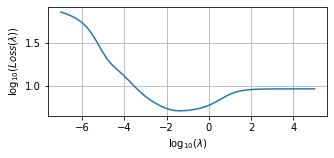

+ s = 0 --------------------
Best solution found:
lambda = [0.04250807]
F      = 5.063669584111346


In [132]:
esnMulti_A_cv10_lambda_2011 = esnMulti_A.ridge_lambda_cv(
    Y=dataset2011_ext['GDP_data_train'], 
    z=(dataset2011_ext['m_data_train'], dataset2011_ext['d_data_train']),
    method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    steps=1,
    debug=True,
)

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
. Folds built


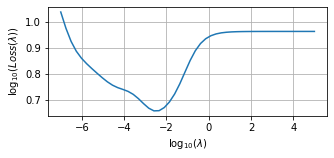

+ s = 0 --------------------
Best solution found:
lambda = [0.0032804]
F      = 4.527861277269479


In [133]:
esnMulti_B_cv10_lambda_2011 = esnMulti_B.ridge_lambda_cv(
    Y=dataset2011_ext['GDP_data_train'], 
    z=(dataset2011_ext['m_data_train'], dataset2011_ext['d_data_train']),
    method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    #cv_options="-cv_min_split_size:70-cv_max_split_size:70-test_size:1",
    steps=1,
    Lambda0=1e-2,
    debug=True,
)

#### 1-step Ahead Point Forecast Comparison

##### Fixed Parameters

In [137]:
UnMean_1sa_forecast_2011 = uncondMean_1sa_fixParamsForecast(
    data=dataset2011,
)

In [138]:
DFM_slice_2011 = (
    pd.date_range('2012-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_fix_forecast_2011 = getDFMOneStepAheadForecast(
    'stock__10__6__[1]_fixed__2011', date_slice=DFM_slice_2011,
)

DFM_B_fix_forecast_2011 = getDFMOneStepAheadForecast(
    'almon__10__6__[1]_fixed__2011', date_slice=DFM_slice_2011,
)

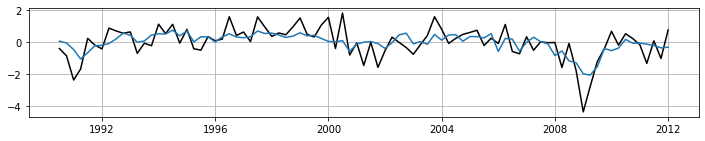

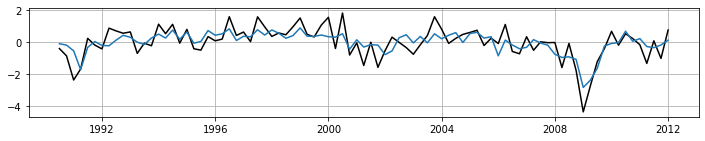

In [139]:
esnSingle_A_agg_fix_for_1sa_2011 = esnSingle_fix_fit_1sa(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2011, 
    #Lambda=[1e-2,],
    data=dataset2011,
    aggregate=True,
)

esnSingle_B_agg_fix_for_1sa_2011 = esnSingle_fix_fit_1sa(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2011, 
    #Lambda=[1e-2,],
    data=dataset2011,
    aggregate=True,
)

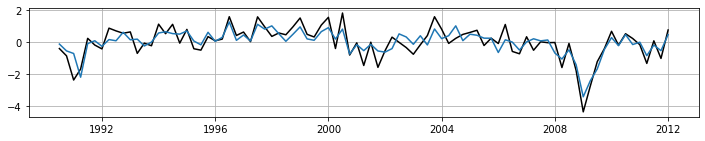

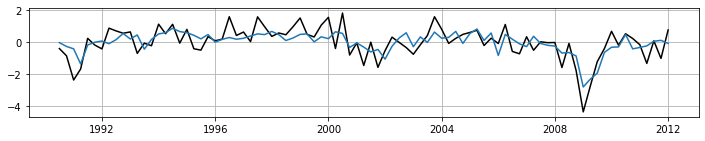

In [140]:
esnMulti_A_fix_for_1sa_2011 = esnMulti_fix_fit_1sa(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2011[0], esnMulti_A_cv10_lambda_2011[0]], 
    #Lambda=[1e-2, 1e-2],
    data=dataset2011,
)

esnMulti_B_fix_for_1sa_2011 = esnMulti_fix_fit_1sa(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2011[0], esnMulti_B_cv10_lambda_2011[0]], 
    data=dataset2011,
)

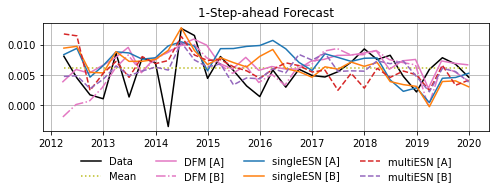

In [141]:
# Plot
plt.figure(figsize=(8, 2))
plt.plot(dataset2011['GDP_data_test'], c='k', label="Data")
#
plt.plot(UnMean_1sa_forecast_2011, label="Mean", c="C8", ls=':')
#
plt.plot(DFM_A_fix_forecast_2011, label="DFM [A]", c="C6") 
plt.plot(DFM_B_fix_forecast_2011, label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(esnSingle_A_agg_fix_for_1sa_2011, label="singleESN [A]", c="C0") 
plt.plot(esnSingle_B_agg_fix_for_1sa_2011, label="singleESN [B]", c="C1") 
#
plt.plot(esnMulti_A_fix_for_1sa_2011, label="multiESN [A]", c="C3", ls='--') 
plt.plot(esnMulti_B_fix_for_1sa_2011, label="multiESN [B]", c="C4", ls='--') 
#
plt.grid()
plt.title("1-Step-ahead Forecast")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_forecasts_2011.pdf'), bbox_inches="tight")
plt.show()

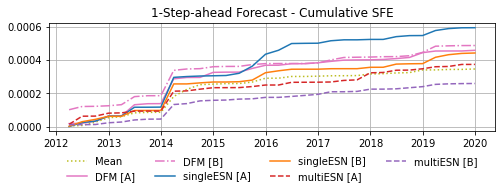

In [142]:
cumulSFE_2011 = lambda forecast : np.cumsum(np.square(dataset2011['GDP_data_test'] - forecast.to_numpy()))

plt.figure(figsize=(8, 2))
plt.grid()
#
plt.plot(cumulSFE_2011(UnMean_1sa_forecast_2011), label="Mean", c="C8", ls=':') 
#
plt.plot(cumulSFE_2011(DFM_A_fix_forecast_2011), label="DFM [A]", c="C6") 
plt.plot(cumulSFE_2011(DFM_B_fix_forecast_2011), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(cumulSFE_2011(esnSingle_A_agg_fix_for_1sa_2011), label="singleESN [A]", c="C0") 
plt.plot(cumulSFE_2011(esnSingle_B_agg_fix_for_1sa_2011), label="singleESN [B]", c="C1") 
#
plt.plot(cumulSFE_2011(esnMulti_A_fix_for_1sa_2011), label="multiESN [A]", c="C3", ls='--') 
plt.plot(cumulSFE_2011(esnMulti_B_fix_for_1sa_2011), label="multiESN [B]", c="C4", ls='--') 
#
#plt.yscale('log')
plt.title("1-Step-ahead Forecast - Cumulative SFE")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_cumulsfe_2011.pdf'), bbox_inches="tight")
plt.show()

In [143]:
def MSFE_2011(forecast, startDate=None):
    if not startDate is None:
        startDate = pd.to_datetime(startDate)
        msfe = np.mean(np.square(
                dataset2011['GDP_data_test'].loc[startDate:,].to_numpy() - 
                    forecast.loc[startDate:,].to_numpy()
            ))
    else:
        msfe = np.mean(np.square(
                dataset2011['GDP_data_test'].to_numpy() - forecast.to_numpy()
            ))
    return msfe

UnMean_MSE_fix_2011_td = MSFE_2011(UnMean_1sa_forecast_2011) * 1e4
DFM_A_MSE_fix_2011_td = MSFE_2011(DFM_A_fix_forecast_2011) * 1e4
DMF_B_MSE_fix_2011_td = MSFE_2011(DFM_B_fix_forecast_2011) * 1e4
esnSingle_A_MSE_fix_2011_td = MSFE_2011(esnSingle_A_agg_fix_for_1sa_2011) * 1e4
esnSingle_B_MSE_fix_2011_td = MSFE_2011(esnSingle_B_agg_fix_for_1sa_2011) * 1e4
esnMulti_A_MSE_fix_2011_td = MSFE_2011(esnMulti_A_fix_for_1sa_2011) * 1e4
esnMulti_B_MSE_fix_2011_td = MSFE_2011(esnMulti_B_fix_for_1sa_2011) * 1e4

print("------------------- MSFE -------------- RMSFE -----")
print(f"Mean \t\t = {UnMean_MSE_fix_2011_td.round(4)} \t|\t"
        f"{np.sqrt(UnMean_MSE_fix_2011_td).round(4)}")
print(f"DFM [A]\t\t = {DFM_A_MSE_fix_2011_td.round(4)} \t|\t"
        f"{np.sqrt(DFM_A_MSE_fix_2011_td).round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_fix_2011_td.round(4)} \t|\t"
        f"{np.sqrt(DMF_B_MSE_fix_2011_td).round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_fix_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_A_MSE_fix_2011_td).round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_fix_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_B_MSE_fix_2011_td).round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_fix_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_A_MSE_fix_2011_td).round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_fix_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_B_MSE_fix_2011_td).round(4)}")

------------------- MSFE -------------- RMSFE -----
Mean 		 = 0.1082 	|	0.3289
DFM [A]		 = 0.1433 	|	0.3786
DFM [B]		 = 0.1523 	|	0.3902
singleESN [A]	 = 0.1858 	|	0.431
singleESN [B]	 = 0.1382 	|	0.3718
multiESN [A]	 = 0.1168 	|	0.3418
multiESN [B]	 = 0.0809 	|	0.2845


In [144]:
ref_MSE_2011_fix = UnMean_MSE_fix_2011_td
DFM_A_MSE_toRef_2011_fix = DFM_A_MSE_fix_2011_td / ref_MSE_2011_fix
DMF_B_MSE_toRef_2011_fix = DMF_B_MSE_fix_2011_td / ref_MSE_2011_fix
esnSingle_A_MSE_toRef_2011_fix = esnSingle_A_MSE_fix_2011_td / ref_MSE_2011_fix
esnSingle_B_MSE_toRef_2011_fix = esnSingle_B_MSE_fix_2011_td / ref_MSE_2011_fix
esnMulti_A_MSE_toRef_2011_fix = esnMulti_A_MSE_fix_2011_td / ref_MSE_2011_fix
esnMulti_B_MSE_toRef_2011_fix = esnMulti_B_MSE_fix_2011_td / ref_MSE_2011_fix

print("------------------ Relative MSFE -----------")
print(f"Mean \t\t = {1.0}")
print(f"DFM [A]\t\t = {DFM_A_MSE_toRef_2011_fix.round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_toRef_2011_fix.round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_toRef_2011_fix.round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_toRef_2011_fix.round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_toRef_2011_fix.round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_toRef_2011_fix.round(4)}")

------------------ Relative MSFE -----------
Mean 		 = 1.0
DFM [A]		 = 1.325
DFM [B]		 = 1.4077
singleESN [A]	 = 1.717
singleESN [B]	 = 1.2779
multiESN [A]	 = 1.0798
multiESN [B]	 = 0.7481


In [145]:
mcs_data_2011_fix = pd.DataFrame(
    np.c_[UnMean_1sa_forecast_2011,
        DFM_A_fix_forecast_2011,
        DFM_B_fix_forecast_2011,
        esnSingle_A_agg_fix_for_1sa_2011,
        esnSingle_B_agg_fix_for_1sa_2011,
        esnMulti_A_fix_for_1sa_2011,
        esnMulti_B_fix_for_1sa_2011,
    ],
    columns=['Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]']
)
mcs_data_2011_fix = (mcs_data_2011_fix - dataset2011['GDP_data_test'].to_numpy())

mcs_25_2011_fix = ModelConfidenceSet(
    data=np.square(mcs_data_2011_fix), alpha=0.25, B=10000, w=2, algorithm='R', seed=202209
).run()
mcs_10_2011_fix = ModelConfidenceSet(
    data=np.square(mcs_data_2011_fix), alpha=0.10, B=10000, w=2, algorithm='R', seed=202209
).run()

print(f"MCS 25 included: {mcs_25_2011_fix.included}")
print(f"MCS 10 included: {mcs_10_2011_fix.included}")

MCS 25 included: ['multiESN [B]']
MCS 10 included: ['singleESN [A]', 'DFM [A]', 'DFM [B]', 'singleESN [B]', 'multiESN [A]', 'Mean', 'multiESN [B]']


In [146]:
mcs_25_2011_fix.pvalues

singleESN [A]    0.1012
DFM [A]          0.1649
DFM [B]          0.1844
singleESN [B]    0.1844
multiESN [A]     0.1844
Mean             0.1844
multiESN [B]     1.0000
dtype: float64

In [147]:
mcs_data_2011_fix.to_csv(
    os.path.join(path_folder, "R", "mcs_medium_fix_2011.csv")
)

##### Expanding Window

In [148]:
UnMean_ew_1sa_forecast_2011 = uncondMean_ew_1sa_Forecast(
    data=dataset2011,
)

In [151]:
DFM_slice_2011 = (
    pd.date_range('2012-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_ew_forecast_2011 = getDFMOneStepAheadForecast(
    'stock__10__6__[1]_expanding__2011', date_slice=DFM_slice_2011,
)

DFM_B_ew_forecast_2011 = getDFMOneStepAheadForecast(
    'almon__10__6__[1]_expanding__2011', date_slice=DFM_slice_2011,
)

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

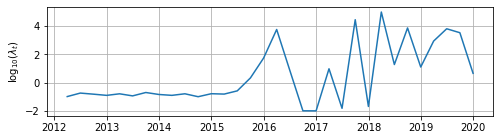

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

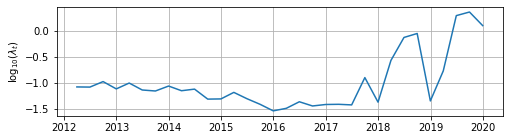

In [152]:
esnSingle_A_agg_ew_for_1sa_2011 = esnSingle_ew_fit_1sa(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2011, 
    data=dataset2011,
    retune=True,
    aggregate=True,
)

esnSingle_B_agg_ew_for_1sa_2011 = esnSingle_ew_fit_1sa(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2011, 
    data=dataset2011,
    retune=True,
    aggregate=True,
)

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

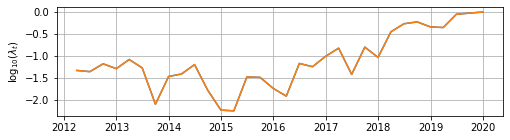

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

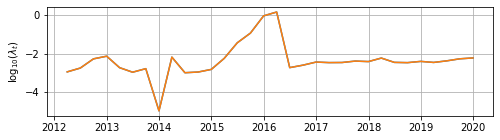

In [153]:
esnMulti_A_ew_for_1sa_2011 = esnMulti_ew_fit_1sa(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2011[0], esnMulti_A_cv10_lambda_2011[0]], 
    data=dataset2011,
    retune=True,
)

esnMulti_B_ew_for_1sa_2011 = esnMulti_ew_fit_1sa(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2011[0], esnMulti_B_cv10_lambda_2011[0]], 
    data=dataset2011,
    retune=True,
)

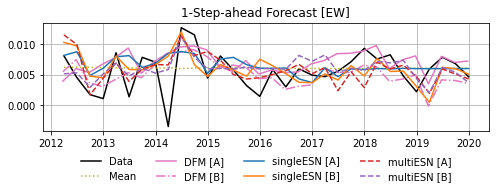

In [206]:
# Plot -- 1-Step-ahead Forecast
plt.figure(figsize=(8, 2))
plt.plot(dataset2011['GDP_data_test'], c='k', label="Data")
#
plt.plot(UnMean_ew_1sa_forecast_2011, label="Mean", c="C8", ls=':')
#
plt.plot(DFM_A_ew_forecast_2011, label="DFM [A]", c="C6") 
plt.plot(DFM_B_ew_forecast_2011, label="DFM [B]", c="C6", ls='-.')  
#
plt.plot(esnSingle_A_agg_ew_for_1sa_2011, label="singleESN [A]", c="C0") 
plt.plot(esnSingle_B_agg_ew_for_1sa_2011, label="singleESN [B]", c="C1") 
#
plt.plot(esnMulti_A_ew_for_1sa_2011, label="multiESN [A]", c="C3", ls='--') 
plt.plot(esnMulti_B_ew_for_1sa_2011, label="multiESN [B]", c="C4", ls='--') 
#
plt.grid()
plt.title("1-Step-ahead Forecast [EW]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_forecasts_ew_2011.pdf'), bbox_inches="tight")
plt.show()

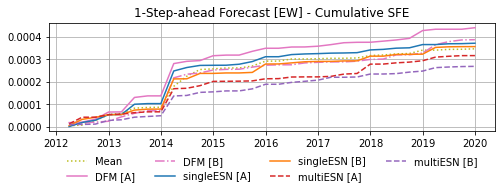

In [208]:
# Plot -- 1-Step-ahead Forecast - Cumulative SFE
plt.figure(figsize=(8, 2))
plt.grid()
#
plt.plot(cumulSFE_2011(UnMean_ew_1sa_forecast_2011), label="Mean", c="C8", ls=':')
#
plt.plot(cumulSFE_2011(DFM_A_ew_forecast_2011), label="DFM [A]", c="C6") 
plt.plot(cumulSFE_2011(DFM_B_ew_forecast_2011), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(cumulSFE_2011(esnSingle_A_agg_ew_for_1sa_2011), label="singleESN [A]", c="C0") 
plt.plot(cumulSFE_2011(esnSingle_B_agg_ew_for_1sa_2011), label="singleESN [B]", c="C1") 
#
plt.plot(cumulSFE_2011(esnMulti_A_ew_for_1sa_2011), label="multiESN [A]", c="C3", ls='--') 
plt.plot(cumulSFE_2011(esnMulti_B_ew_for_1sa_2011), label="multiESN [B]", c="C4", ls='--') 
#
#plt.yscale('log')
plt.title("1-Step-ahead Forecast [EW] - Cumulative SFE")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_cumulsfe_ew_2011.pdf'), bbox_inches="tight")
plt.show()

In [156]:
UnMean_MSE_ew_2011_td = MSFE_2011(UnMean_ew_1sa_forecast_2011) * 1e4
DFM_A_MSE_ew_2011_td = MSFE_2011(DFM_A_ew_forecast_2011) * 1e4
DMF_B_MSE_ew_2011_td = MSFE_2011(DFM_B_ew_forecast_2011) * 1e4
esnSingle_A_MSE_ew_2011_td = MSFE_2011(esnSingle_A_agg_ew_for_1sa_2011) * 1e4
esnSingle_B_MSE_ew_2011_td = MSFE_2011(esnSingle_B_agg_ew_for_1sa_2011) * 1e4
esnMulti_A_MSE_ew_2011_td = MSFE_2011(esnMulti_A_ew_for_1sa_2011) * 1e4
esnMulti_B_MSE_ew_2011_td = MSFE_2011(esnMulti_B_ew_for_1sa_2011) * 1e4

print("------------------- MSFE -------------- RMSFE -----")
print(f"Mean \t\t = {UnMean_MSE_ew_2011_td.round(4)} \t|\t"
        f"{np.sqrt(UnMean_MSE_ew_2011_td).round(4)}")
print(f"DFM [A]\t\t = {DFM_A_MSE_ew_2011_td.round(4)} \t|\t"
        f"{np.sqrt(DFM_A_MSE_ew_2011_td).round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_ew_2011_td.round(4)} \t|\t"
        f"{np.sqrt(DMF_B_MSE_ew_2011_td).round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_ew_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_A_MSE_ew_2011_td).round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_ew_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_B_MSE_ew_2011_td).round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_ew_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_A_MSE_ew_2011_td).round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_ew_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_B_MSE_ew_2011_td).round(4)}")

------------------- MSFE -------------- RMSFE -----
Mean 		 = 0.1082 	|	0.3289
DFM [A]		 = 0.1376 	|	0.3709
DFM [B]		 = 0.1209 	|	0.3477
singleESN [A]	 = 0.116 	|	0.3405
singleESN [B]	 = 0.1113 	|	0.3336
multiESN [A]	 = 0.0987 	|	0.3142
multiESN [B]	 = 0.0838 	|	0.2895


In [157]:
ref_MSE_2011_ew = UnMean_MSE_ew_2011_td
DFM_A_MSE_toRef_2011_ew = DFM_A_MSE_ew_2011_td / ref_MSE_2011_ew
DMF_B_MSE_toRef_2011_ew = DMF_B_MSE_ew_2011_td / ref_MSE_2011_ew
esnSingle_A_MSE_toRef_2011_ew = esnSingle_A_MSE_ew_2011_td / ref_MSE_2011_ew
esnSingle_B_MSE_toRef_2011_ew = esnSingle_B_MSE_ew_2011_td / ref_MSE_2011_ew
esnMulti_A_MSE_toRef_2011_ew = esnMulti_A_MSE_ew_2011_td / ref_MSE_2011_ew
esnMulti_B_MSE_toRef_2011_ew = esnMulti_B_MSE_ew_2011_td / ref_MSE_2011_ew

print("------------------ Relative MSFE -----------")
print(f"Mean \t\t = {1.0}")
print(f"DFM [A]\t\t = {DFM_A_MSE_toRef_2011_ew.round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_toRef_2011_ew.round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_toRef_2011_ew.round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_toRef_2011_ew.round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_toRef_2011_ew.round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_toRef_2011_ew.round(4)}")

------------------ Relative MSFE -----------
Mean 		 = 1.0
DFM [A]		 = 1.2715
DFM [B]		 = 1.1175
singleESN [A]	 = 1.0719
singleESN [B]	 = 1.0285
multiESN [A]	 = 0.9127
multiESN [B]	 = 0.7744


In [158]:
mcs_data_2011_ew = pd.DataFrame(
    np.c_[UnMean_ew_1sa_forecast_2011,
        DFM_A_ew_forecast_2011,
        DFM_B_ew_forecast_2011,
        esnSingle_A_agg_ew_for_1sa_2011,
        esnSingle_B_agg_ew_for_1sa_2011,
        esnMulti_A_ew_for_1sa_2011,
        esnMulti_B_ew_for_1sa_2011,
    ],
    columns=['Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A] [EW]', 'singleESN [B] [EW]', 'multiESN [A] [EW]', 'multiESN [B] [EW]']
)
mcs_data_2011_ew = (mcs_data_2011_ew - dataset2011['GDP_data_test'].to_numpy())

mcs_25_2011_ew = ModelConfidenceSet(
    data=np.square(mcs_data_2011_ew), alpha=0.25, B=10000, w=2, algorithm='R', seed=202209
).run()
mcs_10_2011_ew = ModelConfidenceSet(
    data=np.square(mcs_data_2011_ew), alpha=0.10, B=10000, w=2, algorithm='R', seed=202209
).run()

print(f"MCS 25 included: {mcs_25_2011_ew.included}")
print(f"MCS 10 included: {mcs_10_2011_ew.included}")

MCS 25 included: ['DFM [A]', 'DFM [B]', 'singleESN [A] [EW]', 'singleESN [B] [EW]', 'Mean', 'multiESN [A] [EW]', 'multiESN [B] [EW]']
MCS 10 included: ['DFM [A]', 'DFM [B]', 'singleESN [A] [EW]', 'singleESN [B] [EW]', 'Mean', 'multiESN [A] [EW]', 'multiESN [B] [EW]']


In [159]:
mcs_25_2011_ew.pvalues

DFM [A]               0.3215
DFM [B]               0.5576
singleESN [A] [EW]    0.5576
singleESN [B] [EW]    0.5576
Mean                  0.5576
multiESN [A] [EW]     0.5576
multiESN [B] [EW]     1.0000
dtype: float64

In [160]:
mcs_data_2011_ew.to_csv(
    os.path.join(path_folder, "R", "mcs_medium_ew_2011.csv")
)

##### Rolling Window

In [161]:
UnMean_rw_1sa_forecast_2011 = uncondMean_rw_1sa_Forecast(
    data=dataset2011,
)

In [162]:
DFM_slice_2011 = (
    pd.date_range('2012-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_rw_forecast_2011 = getDFMOneStepAheadForecast(
    'stock__10__6__[1]_window__2011', date_slice=DFM_slice_2011,
)

DFM_B_rw_forecast_2011 = getDFMOneStepAheadForecast(
    'almon__10__6__[1]_window__2011', date_slice=DFM_slice_2011,
)

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

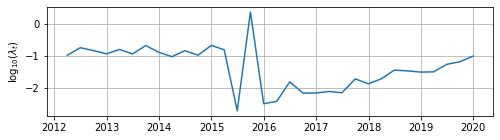

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

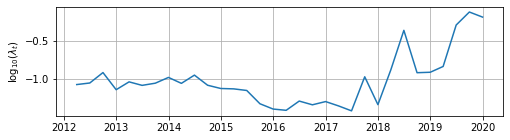

In [163]:
esnSingle_A_agg_rw_for_1sa_2011 = esnSingle_rw_fit_1sa(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2011, 
    data=dataset2011,
    retune=True,
    aggregate=True,
)

esnSingle_B_agg_rw_for_1sa_2011 = esnSingle_rw_fit_1sa(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2011,
    data=dataset2011,
    retune=True,
    aggregate=True,
)

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

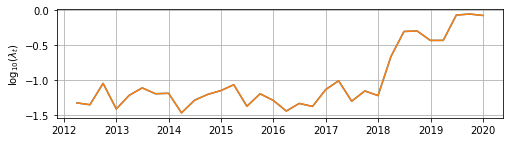

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

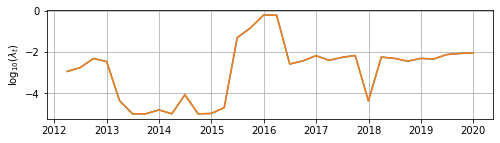

In [164]:
esnMulti_A_rw_for_1sa_2011 = esnMulti_rw_fit_1sa(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2011[0], esnMulti_A_cv10_lambda_2011[0]], 
    data=dataset2011,
    retune=True,
)

esnMulti_B_rw_for_1sa_2011 = esnMulti_rw_fit_1sa(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2011[0], esnMulti_B_cv10_lambda_2011[0]], 
    data=dataset2011,
    retune=True,
)

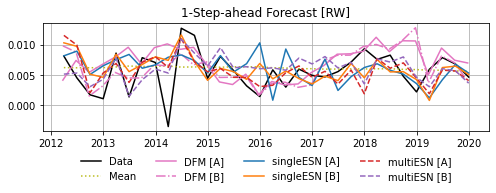

In [210]:
# Plot -- 1-Step-ahead Forecast
plt.figure(figsize=(8, 2))
plt.plot(dataset2011['GDP_data_test'], c='k', label="Data")
#
plt.plot(UnMean_rw_1sa_forecast_2011, label="Mean", c="C8", ls=':')
#
plt.plot(DFM_A_rw_forecast_2011, label="DFM [A]", c="C6") 
plt.plot(DFM_B_rw_forecast_2011, label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(esnSingle_A_agg_rw_for_1sa_2011, label="singleESN [A]", c="C0") 
plt.plot(esnSingle_B_agg_rw_for_1sa_2011, label="singleESN [B]", c="C1") 
#
plt.plot(esnMulti_A_rw_for_1sa_2011, label="multiESN [A]", c="C3", ls='--') 
plt.plot(esnMulti_B_rw_for_1sa_2011, label="multiESN [B]", c="C4", ls='--') 
#
plt.grid()
plt.title("1-Step-ahead Forecast [RW]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_forecasts_rw_2011.pdf'), bbox_inches="tight")
plt.show()

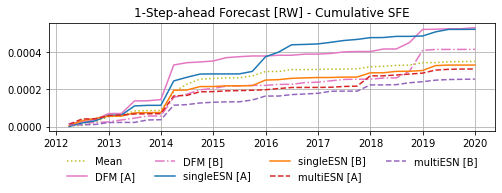

In [209]:
# Plot -- 1-Step-ahead Forecast - Cumulative SFE
plt.figure(figsize=(8, 2))
plt.grid()
#
plt.plot(cumulSFE_2011(UnMean_rw_1sa_forecast_2011), label="Mean", c="C8", ls=':')
#
plt.plot(cumulSFE_2011(DFM_A_rw_forecast_2011), label="DFM [A]", c="C6") 
plt.plot(cumulSFE_2011(DFM_B_rw_forecast_2011), label="DFM [B]", c="C6", ls='-.')
#
plt.plot(cumulSFE_2011(esnSingle_A_agg_rw_for_1sa_2011), label="singleESN [A]", c="C0") 
plt.plot(cumulSFE_2011(esnSingle_B_agg_rw_for_1sa_2011), label="singleESN [B]", c="C1") 
#
plt.plot(cumulSFE_2011(esnMulti_A_rw_for_1sa_2011), label="multiESN [A]", c="C3", ls='--') 
plt.plot(cumulSFE_2011(esnMulti_B_rw_for_1sa_2011), label="multiESN [B]", c="C4", ls='--') 
#
#plt.yscale('log')
plt.title("1-Step-ahead Forecast [RW] - Cumulative SFE")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_1sa_cumulsfe_rw_2011.pdf'), bbox_inches="tight")
plt.show()

In [167]:
UnMean_MSE_rw_2011_td = MSFE_2011(UnMean_rw_1sa_forecast_2011) * 1e4
DFM_A_MSE_rw_2011_td = MSFE_2011(DFM_A_rw_forecast_2011) * 1e4
DMF_B_MSE_rw_2011_td = MSFE_2011(DFM_B_rw_forecast_2011) * 1e4
esnSingle_A_MSE_rw_2011_td = MSFE_2011(esnSingle_A_agg_rw_for_1sa_2011) * 1e4
esnSingle_B_MSE_rw_2011_td = MSFE_2011(esnSingle_B_agg_rw_for_1sa_2011) * 1e4
esnMulti_A_MSE_rw_2011_td = MSFE_2011(esnMulti_A_rw_for_1sa_2011) * 1e4
esnMulti_B_MSE_rw_2011_td = MSFE_2011(esnMulti_B_rw_for_1sa_2011) * 1e4

print("------------------- MSFE -------------- RMSFE -----")
print(f"Mean \t\t = {UnMean_MSE_rw_2011_td.round(4)} \t|\t"
        f"{np.sqrt(UnMean_MSE_rw_2011_td).round(4)}")
print(f"DFM [A]\t\t = {DFM_A_MSE_rw_2011_td.round(4)} \t|\t"
        f"{np.sqrt(DFM_A_MSE_rw_2011_td).round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_rw_2011_td.round(4)} \t|\t"
        f"{np.sqrt(DMF_B_MSE_rw_2011_td).round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_rw_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_A_MSE_rw_2011_td).round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_rw_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnSingle_B_MSE_rw_2011_td).round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_rw_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_A_MSE_rw_2011_td).round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_rw_2011_td.round(4)} \t|\t"
        f"{np.sqrt(esnMulti_B_MSE_rw_2011_td).round(4)}")

------------------- MSFE -------------- RMSFE -----
Mean 		 = 0.1098 	|	0.3313
DFM [A]		 = 0.1666 	|	0.4081
DFM [B]		 = 0.1301 	|	0.3607
singleESN [A]	 = 0.1639 	|	0.4048
singleESN [B]	 = 0.1037 	|	0.322
multiESN [A]	 = 0.097 	|	0.3114
multiESN [B]	 = 0.0799 	|	0.2827


In [168]:
ref_MSE_2011_rw = UnMean_MSE_rw_2011_td
DFM_A_MSE_toRef_2011_rw = DFM_A_MSE_rw_2011_td / ref_MSE_2011_rw
DMF_B_MSE_toRef_2011_rw = DMF_B_MSE_rw_2011_td / ref_MSE_2011_rw
esnSingle_A_MSE_toRef_2011_rw = esnSingle_A_MSE_rw_2011_td / ref_MSE_2011_rw
esnSingle_B_MSE_toRef_2011_rw = esnSingle_B_MSE_rw_2011_td / ref_MSE_2011_rw
esnMulti_A_MSE_toRef_2011_rw = esnMulti_A_MSE_rw_2011_td / ref_MSE_2011_rw
esnMulti_B_MSE_toRef_2011_rw = esnMulti_B_MSE_rw_2011_td / ref_MSE_2011_rw

print("------------------ Relative MSFE -----------")
print(f"Mean \t\t = {1.0}")
print(f"DFM [A]\t\t = {DFM_A_MSE_toRef_2011_rw.round(4)}")
print(f"DFM [B]\t\t = {DMF_B_MSE_toRef_2011_rw.round(4)}")
print(f"singleESN [A]\t = {esnSingle_A_MSE_toRef_2011_rw.round(4)}")
print(f"singleESN [B]\t = {esnSingle_B_MSE_toRef_2011_rw.round(4)}")
print(f"multiESN [A]\t = {esnMulti_A_MSE_toRef_2011_rw.round(4)}")
print(f"multiESN [B]\t = {esnMulti_B_MSE_toRef_2011_rw.round(4)}")

------------------ Relative MSFE -----------
Mean 		 = 1.0
DFM [A]		 = 1.5174
DFM [B]		 = 1.1855
singleESN [A]	 = 1.493
singleESN [B]	 = 0.9445
multiESN [A]	 = 0.8836
multiESN [B]	 = 0.7283


In [169]:
mcs_data_2011_rw = pd.DataFrame(
    np.c_[UnMean_rw_1sa_forecast_2011,
        DFM_A_rw_forecast_2011,
        DFM_B_rw_forecast_2011,
        esnSingle_A_agg_rw_for_1sa_2011,
        esnSingle_B_agg_rw_for_1sa_2011,
        esnMulti_A_rw_for_1sa_2011,
        esnMulti_B_rw_for_1sa_2011,
    ],
    columns=['Mean', 'DFM [A]', 'DFM [B]',
                'singleESN [A] [RW]', 'singleESN [B] [RW]', 'multiESN [A] [RW]', 'multiESN [B] [RW]']
)
mcs_data_2011_rw = (mcs_data_2011_rw - dataset2011['GDP_data_test'].to_numpy())

mcs_25_2011_rw = ModelConfidenceSet(
    data=np.square(mcs_data_2011_rw), alpha=0.25, B=10000, w=2, algorithm='R', seed=202209
).run()
mcs_10_2011_rw = ModelConfidenceSet(
    data=np.square(mcs_data_2011_rw), alpha=0.10, B=10000, w=2, algorithm='R', seed=202209
).run()

print(f"MCS 25 included: {mcs_25_2011_rw.included}")
print(f"MCS 10 included: {mcs_10_2011_rw.included}")

MCS 25 included: ['DFM [A]', 'DFM [B]', 'Mean', 'singleESN [B] [RW]', 'multiESN [A] [RW]', 'multiESN [B] [RW]']
MCS 10 included: ['singleESN [A] [RW]', 'DFM [A]', 'DFM [B]', 'Mean', 'singleESN [B] [RW]', 'multiESN [A] [RW]', 'multiESN [B] [RW]']


In [170]:
mcs_25_2011_rw.pvalues

singleESN [A] [RW]    0.1113
DFM [A]               0.3293
DFM [B]               0.6327
Mean                  0.6327
singleESN [B] [RW]    0.6327
multiESN [A] [RW]     0.6327
multiESN [B] [RW]     1.0000
dtype: float64

In [171]:
mcs_data_2011_rw.to_csv(
    os.path.join(path_folder, "R", "mcs_medium_rw_2011.csv")
)

#### Multi-step Point Forecast

##### Fixed Parameters

In [172]:
UnMean_fix_multistep_for_2011 = UnMean_fix_fit_multistep(
    data=dataset2011,
    steps=8,
)

In [173]:
#DFM_A_fix_multistep_for_2011 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2011['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_A_fix_multistep_for_2011.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'stock__5__6__[1, 4, 12]_fixed__2011', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )
#
#DFM_B_fix_multistep_for_2011 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2011['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_B_fix_multistep_for_2011.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'almon__5__6__[1, 4, 12]_fixed__2011', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )

DFM_slice_2011 = (
    pd.date_range('2012-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_fix_multistep_for_2011 = getDFMMultiStepAheadForecast(
    'stock__10__6__[1]_fixed__2011', steps=8, date_slice=DFM_slice_2011,
)

DFM_B_fix_multistep_for_2011 = getDFMMultiStepAheadForecast(
    'almon__10__6__[1]_fixed__2011', steps=8, date_slice=DFM_slice_2011,
)

In [174]:
# Aggregated
esnSingle_A_agg_fix_multistep_for_2011 = esnSingle_fix_fit_multistep(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2011, 
    data=dataset2011,
    steps=8,
    direct=False,
    aggregate=True,
)

esnSingle_B_agg_fix_multistep_for_2011 = esnSingle_fix_fit_multistep(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2011, 
    data=dataset2011,
    steps=8,
    direct=False,
    aggregate=True,
)

In [175]:
esnMulti_A_fix_multistep_for_2011 = esnMulti_fix_fit_multistep(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2011[0], esnMulti_A_cv10_lambda_2011[0]], 
    data=dataset2011,
    steps=8,
    direct=False,
)

esnMulti_B_fix_multistep_for_2011 = esnMulti_fix_fit_multistep(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2011[0], esnMulti_B_cv10_lambda_2011[0]], 
    data=dataset2011,
    steps=8,
    direct=False,
)

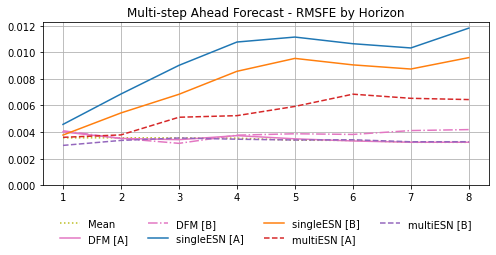

In [217]:
def hStepRMSFE_2011(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            dataset2011['GDP_data_test'].to_numpy() - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))

plt.figure(figsize=(8, 3))
plt.grid()
#
plt.plot(hStepRMSFE_2011(UnMean_fix_multistep_for_2011), label="Mean", c="C8", ls=':') 
#
plt.plot(hStepRMSFE_2011(DFM_A_fix_multistep_for_2011), label="DFM [A]", c="C6") 
plt.plot(hStepRMSFE_2011(DFM_B_fix_multistep_for_2011), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(hStepRMSFE_2011(esnSingle_A_agg_fix_multistep_for_2011), label="singleESN [A]", c="C0") 
plt.plot(hStepRMSFE_2011(esnSingle_B_agg_fix_multistep_for_2011), label="singleESN [B]", c="C1") 
#
plt.plot(hStepRMSFE_2011(esnMulti_A_fix_multistep_for_2011), label="multiESN [A]", c="C3", ls='--') 
plt.plot(hStepRMSFE_2011(esnMulti_B_fix_multistep_for_2011), label="multiESN [B]", c="C4", ls='--') 
#
plt.ylim(bottom=0.)
#plt.yscale('log')
plt.title("Multi-step Ahead Forecast - RMSFE by Horizon")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_msa_rmsfe-by-h_fix_2011.pdf'), bbox_inches="tight")
plt.show()

In [181]:
table_RMSFE_multistep_fix_2011 = pd.DataFrame(
    index=range(1,8)
)
table_RMSFE_multistep_fix_2011.index.name = "FIX_2011"
table_RMSFE_multistep_fix_2011["Model"] = ['Mean', 'DFM [A]', 'DFM [B]', 
        'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
    ]

for h in range(8):
    ref_h_hStepRMSFE_fix = hStepRMSFE_2011(UnMean_fix_multistep_for_2011).iat[h,0]
    table_RMSFE_multistep_fix_2011[str(h+1)] = [
        hStepRMSFE_2011(UnMean_fix_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2011(DFM_A_fix_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2011(DFM_B_fix_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2011(esnSingle_A_agg_fix_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2011(esnSingle_B_agg_fix_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2011(esnMulti_A_fix_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_fix,
        hStepRMSFE_2011(esnMulti_B_fix_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_fix,
    ]

table_RMSFE_multistep_fix_2011.round(3)

Model      1      2      3      4      5      6      7  \
FIX_2011                                                                   
1                  Mean  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
2               DFM [A]  1.126  0.987  0.962  1.054  1.031  0.988  1.001   
3               DFM [B]  1.149  0.987  0.885  1.064  1.142  1.134  1.273   
4         singleESN [A]  1.283  1.921  2.527  3.038  3.285  3.154  3.193   
5         singleESN [B]  1.059  1.523  1.918  2.417  2.812  2.683  2.703   
6          multiESN [A]  1.011  1.061  1.434  1.477  1.748  2.030  2.023   
7          multiESN [B]  0.841  0.945  0.997  0.978  1.004  1.015  1.013   

              8  
FIX_2011         
1         1.000  
2         1.002  
3         1.296  
4         3.655  
5         2.970  
6         1.994  
7         1.014

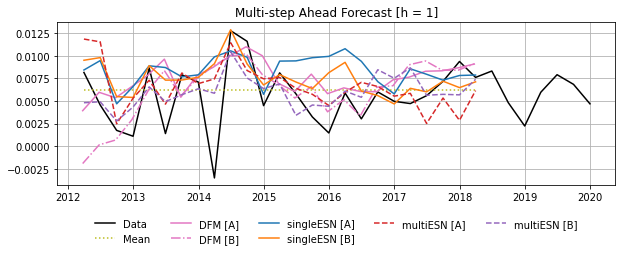

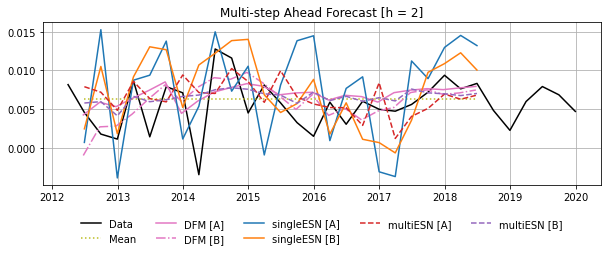

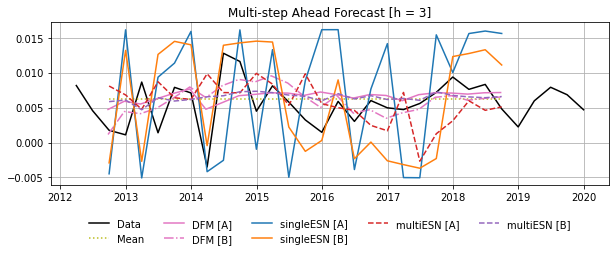

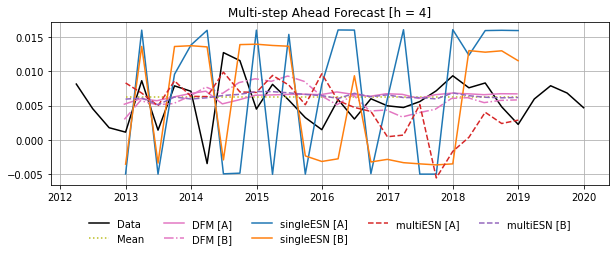

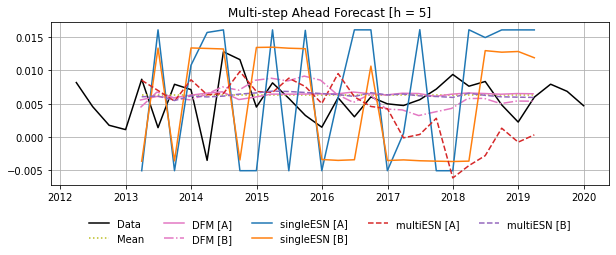

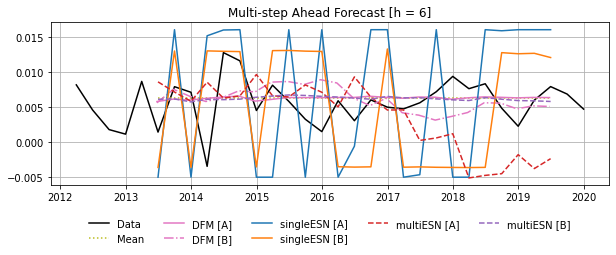

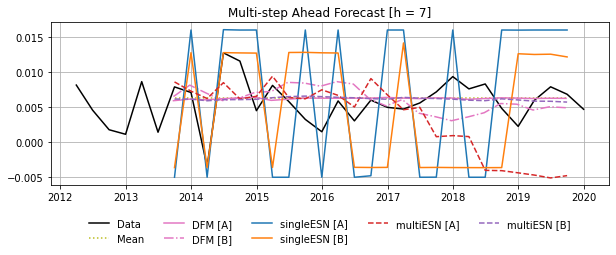

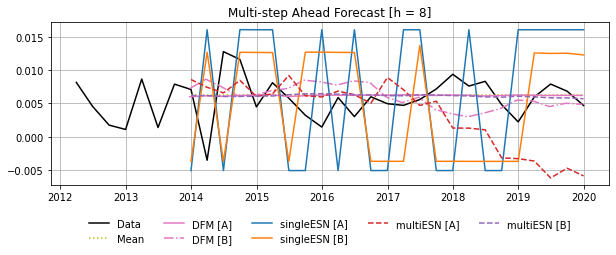

In [178]:
steps = 8
T = len(dataset2011['GDP_data_test'])
for h in range(steps):
    plt.figure(figsize=(10, 3))
    plt.grid()
    plt.plot(dataset2011['GDP_data_test'], c='k', label="Data")
    #
    plt.plot(UnMean_fix_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="Mean", c="C8", ls=':') 
    #
    plt.plot(DFM_A_fix_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="DFM [A]", c="C6") 
    plt.plot(DFM_B_fix_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="DFM [B]", c="C6", ls='-.') 
    #
    plt.plot(esnSingle_A_agg_fix_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="singleESN [A]", c="C0")
    plt.plot(esnSingle_B_agg_fix_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="singleESN [B]", c="C1") 
    #
    #plt.plot(esnSingle_A_directmultistep_for_2011[h].iloc[h:(T-steps+h+1),], label="singleESN [A] direct", c="C0", ls="-.")
    #plt.plot(esnSingle_B_directmultistep_for_2011[h].iloc[h:(T-steps+h+1),], label="singleESN [B] direct", c="C1", ls="-.")
    #
    plt.plot(esnMulti_A_fix_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="multiESN [A]", c="C3", ls='--') 
    plt.plot(esnMulti_B_fix_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="multiESN [B]", c="C4", ls='--')
    #
    plt.title("Multi-step Ahead Forecast" + f" [h = {h+1}]")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                    frameon=False, fancybox=False, shadow=False, ncol=5)
    plt.show()

Export multi-horizon losses:

In [179]:
mhmcs_steps = 8
mhmcs_multistep_fix_2011 = xr.DataArray(
    data=np.zeros(
        (mhmcs_steps, len(dataset2011['GDP_data_test']) - mhmcs_steps, 7)
    ),
    dims=["H", "T", "M0"],
    coords={
        "M0": [
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    },
    attrs=dict(
        names=[
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    )
)

for h in range(mhmcs_steps):
    mhmcs_multistep_fix_2011[h, :, :] = np.square((
        np.c_[
            UnMean_fix_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            DFM_A_fix_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            DFM_B_fix_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_A_agg_fix_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_B_agg_fix_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_A_fix_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_B_fix_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
        ] - dataset2011['GDP_data_test'].iloc[h:(-mhmcs_steps+h),].to_numpy()))

In [180]:
mhmcs_multistep_fix_2011_df = mhmcs_multistep_fix_2011.to_dataframe(
    name="Loss", dim_order=['M0', 'H', 'T']
)
mhmcs_multistep_fix_2011_df.to_csv(
    os.path.join(path_folder, "R", "mhmcs_medium_multistep_fix_2011.csv")
)

##### Expanding Window

In [182]:
UnMean_ew_multistep_for_2011 = UnMean_ew_fit_multistep(
    data=dataset2011,
    steps=8,
)

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

In [184]:
#DFM_A_ew_multistep_for_2011 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2011['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_A_ew_multistep_for_2011.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'stock__5__6__[1, 4, 12]_expanding__2011', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )
#
#DFM_B_ew_multistep_for_2011 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2011['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_B_ew_multistep_for_2011.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'almon__5__6__[1, 4, 12]_expanding__2011', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )

DFM_slice_2011 = (
    pd.date_range('2012-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_ew_multistep_for_2011 = getDFMMultiStepAheadForecast(
    'stock__10__6__[1]_expanding__2011', steps=8, date_slice=DFM_slice_2011,
)

DFM_B_ew_multistep_for_2011 = getDFMMultiStepAheadForecast(
    'almon__10__6__[1]_expanding__2011', steps=8, date_slice=DFM_slice_2011,
)

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

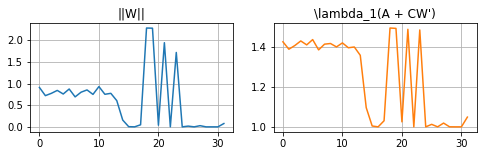

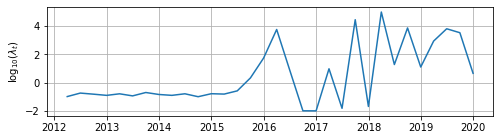

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

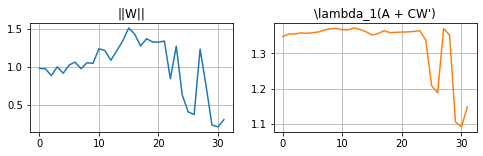

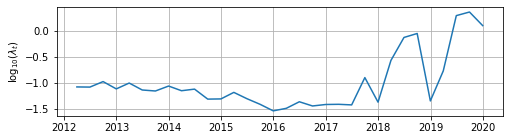

In [185]:
# Aggregated
esnSingle_A_agg_ew_multistep_for_2011 = esnSingle_ew_fit_multistep(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2011, 
    data=dataset2011,
    steps=8,
    direct=False,
    retune=True,
    aggregate=True,
)

esnSingle_B_agg_ew_multistep_for_2011 = esnSingle_ew_fit_multistep(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2011, 
    data=dataset2011,
    steps=8,
    direct=False,
    retune=True,
    aggregate=True,
)

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

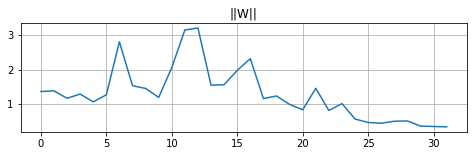

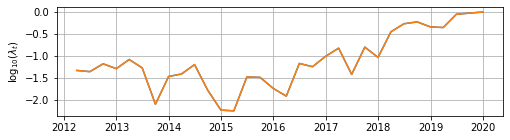

 EW:   0%|          | 0/32 [00:00<?, ?it/s]

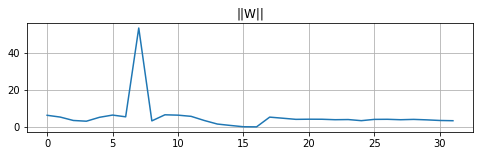

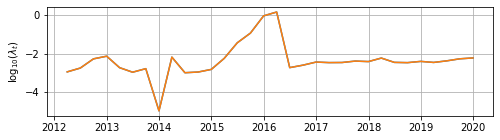

In [186]:
esnMulti_A_ew_multistep_for_2011 = esnMulti_ew_fit_multistep(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2011[0], esnMulti_A_cv10_lambda_2011[0]],  
    data=dataset2011,
    steps=8,
    direct=False,
    retune=True,
)

esnMulti_B_ew_multistep_for_2011 = esnMulti_ew_fit_multistep(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2011[0], esnMulti_B_cv10_lambda_2011[0]], 
    data=dataset2011,
    steps=8,
    direct=False,
    retune=True,
)

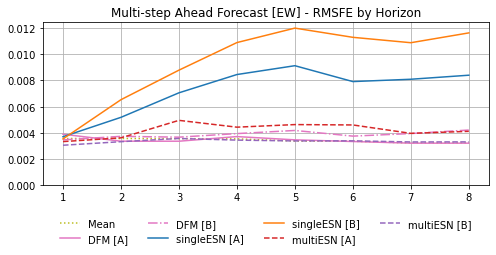

In [219]:
def hStepRMSFE_2011(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            dataset2011['GDP_data_test'].to_numpy() - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))

plt.figure(figsize=(8, 3))
plt.grid()
#
plt.plot(hStepRMSFE_2011(UnMean_ew_multistep_for_2011), label="Mean", c="C8", ls=':') 
#
plt.plot(hStepRMSFE_2011(DFM_A_ew_multistep_for_2011), label="DFM [A]", c="C6") 
plt.plot(hStepRMSFE_2011(DFM_B_ew_multistep_for_2011), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(hStepRMSFE_2011(esnSingle_A_agg_ew_multistep_for_2011), label="singleESN [A]", c="C0") 
plt.plot(hStepRMSFE_2011(esnSingle_B_agg_ew_multistep_for_2011), label="singleESN [B]", c="C1") 
#
plt.plot(hStepRMSFE_2011(esnMulti_A_ew_multistep_for_2011), label="multiESN [A]", c="C3", ls='--') 
plt.plot(hStepRMSFE_2011(esnMulti_B_ew_multistep_for_2011), label="multiESN [B]", c="C4", ls='--') 
#
plt.ylim(bottom=0.)
#plt.yscale('log')
plt.title("Multi-step Ahead Forecast [EW] - RMSFE by Horizon")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_msa_rmsfe-by-h_ew_2011.pdf'), bbox_inches="tight")
plt.show()

In [188]:
table_RMSFE_multistep_ew_2011 = pd.DataFrame(
    index=range(1,8)
)
table_RMSFE_multistep_ew_2011.index.name = "EW_2011"
table_RMSFE_multistep_ew_2011["Model"] = ['Mean', 'DFM [A]', 'DFM [B]', 
        'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
    ]

for h in range(8):
    ref_h_hStepRMSFE_ew = hStepRMSFE_2011(UnMean_ew_multistep_for_2011).iat[h,0]
    table_RMSFE_multistep_ew_2011[str(h+1)] = [
        hStepRMSFE_2011(UnMean_ew_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2011(DFM_A_ew_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2011(DFM_B_ew_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2011(esnSingle_A_agg_ew_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2011(esnSingle_B_agg_ew_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2011(esnMulti_A_ew_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_ew,
        hStepRMSFE_2011(esnMulti_B_ew_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_ew,
    ]

table_RMSFE_multistep_ew_2011.round(4)

Model       1       2       3       4       5       6  \
EW_2011                                                                  
1                 Mean  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
2              DFM [A]  1.0925  0.9418  0.9444  1.0493  1.0264  0.9936   
3              DFM [B]  0.9710  1.0459  1.0312  1.1135  1.2381  1.1162   
4        singleESN [A]  1.0385  1.4513  1.9802  2.3845  2.6991  2.3529   
5        singleESN [B]  0.9918  1.8276  2.4653  3.0724  3.5471  3.3565   
6         multiESN [A]  0.9344  1.0138  1.3908  1.2516  1.3707  1.3694   
7         multiESN [B]  0.8569  0.9315  1.0031  0.9732  1.0020  1.0091   

              7       8  
EW_2011                  
1        1.0000  1.0000  
2        0.9962  0.9987  
3        1.2231  1.3098  
4        2.5056  2.6079  
5        3.3684  3.6098  
6        1.2276  1.2790  
7        1.0247  1.0291

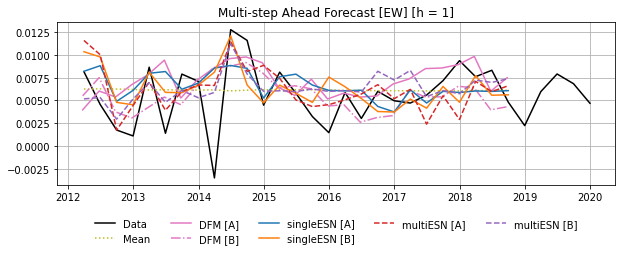

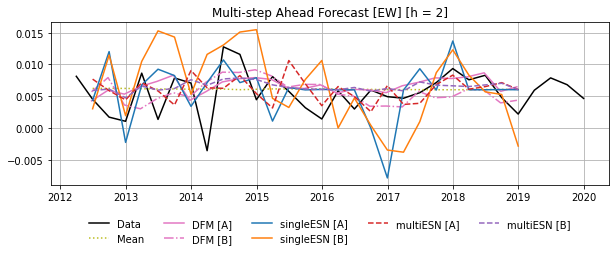

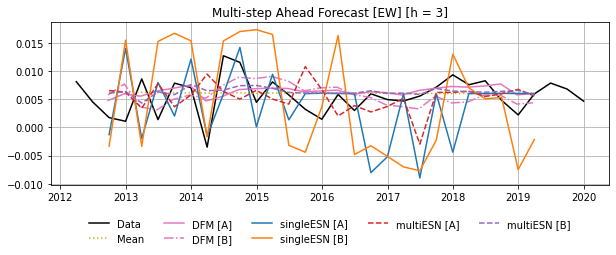

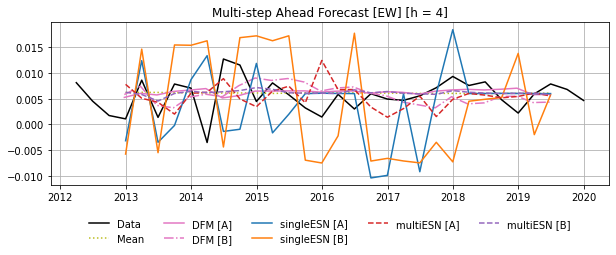

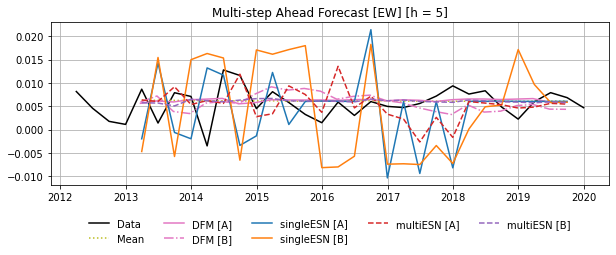

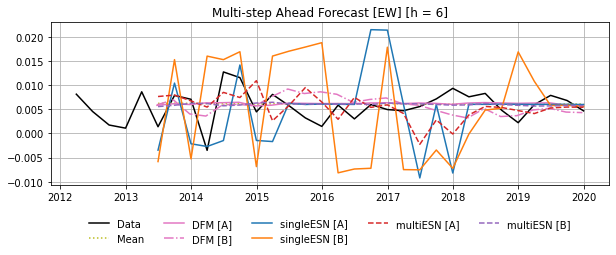

In [189]:
steps = 6
T = len(dataset2011['GDP_data_test'])
for h in range(steps):
    plt.figure(figsize=(10, 3))
    plt.grid()
    plt.plot(dataset2011['GDP_data_test'], c='k', label="Data")
    #
    plt.plot(UnMean_ew_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="Mean", c="C8", ls=':') 
    #
    plt.plot(DFM_A_ew_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="DFM [A]", c="C6") 
    plt.plot(DFM_B_ew_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="DFM [B]", c="C6", ls='-.') 
    #
    plt.plot(esnSingle_A_agg_ew_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="singleESN [A]", c="C0")
    plt.plot(esnSingle_B_agg_ew_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="singleESN [B]", c="C1") 
    #
    plt.plot(esnMulti_A_ew_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="multiESN [A]", c="C3", ls='--') 
    plt.plot(esnMulti_B_ew_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="multiESN [B]", c="C4", ls='--')
    #
    plt.title("Multi-step Ahead Forecast [EW]" + f" [h = {h+1}]")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                    frameon=False, fancybox=False, shadow=False, ncol=5)
    plt.show()

Export multi-horizon losses:

In [190]:
mhmcs_steps = 8
mhmcs_multistep_ew_2011 = xr.DataArray(
    data=np.zeros(
        (mhmcs_steps, len(dataset2011['GDP_data_test']) - mhmcs_steps, 7)
    ),
    dims=["H", "T", "M0"],
    coords={
        "M0": [
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    },
    attrs=dict(
        names=[
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    )
)

for h in range(mhmcs_steps):
    mhmcs_multistep_ew_2011[h, :, :] = np.square((
        np.c_[
            UnMean_ew_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            DFM_A_ew_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            DFM_B_ew_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_A_agg_ew_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_B_agg_ew_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_A_ew_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_B_ew_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
        ] - dataset2011['GDP_data_test'].iloc[h:(-mhmcs_steps+h),].to_numpy()))

In [191]:
mhmcs_multistep_ew_2011_df = mhmcs_multistep_ew_2011.to_dataframe(
    name="Loss", dim_order=['M0', 'H', 'T']
)
mhmcs_multistep_ew_2011_df.to_csv(
    os.path.join(path_folder, "R", "mhmcs_medium_multistep_ew_2011.csv")
)

##### Rolling Window

In [192]:
UnMean_rw_multistep_for_2011 = UnMean_rw_fit_multistep(
    data=dataset2011,
    steps=8
)

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

In [194]:
#DFM_A_rw_multistep_for_2011 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2011['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_A_rw_multistep_for_2011.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'stock__5__6__[1, 4, 12]_window__2011', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )
#
#DFM_B_rw_multistep_for_2011 = pd.DataFrame(
#    data=None, columns=range(6), index=dataset2011['GDP_data_test'].index,
#)
#for h in range(6):
#    DFM_B_rw_multistep_for_2011.iloc[:,h] = (
#        pd.read_csv(
#            os.path.join(dfm_path, 'almon__5__6__[1, 4, 12]_window__2011', 'q_test_'+str(12*(h+1))+'.csv'),
#            parse_dates = [0]
#        ).iloc[:,1].to_numpy()
#    )

DFM_slice_2011 = (
    pd.date_range('2012-01-01', '2019-12-31', freq="BQ") 
        - pd.tseries.offsets.MonthBegin(1) + pd.tseries.offsets.Day(23)
)

DFM_A_rw_multistep_for_2011 = getDFMMultiStepAheadForecast(
    'stock__10__6__[1]_window__2011', steps=8, date_slice=DFM_slice_2011,
)

DFM_B_rw_multistep_for_2011 = getDFMMultiStepAheadForecast(
    'almon__10__6__[1]_window__2011', steps=8, date_slice=DFM_slice_2011,
)

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

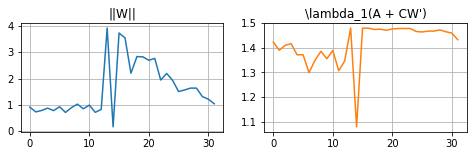

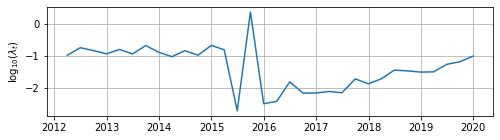

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

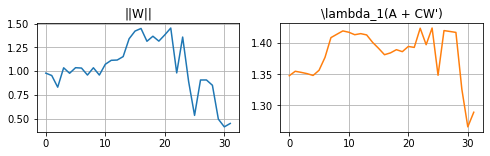

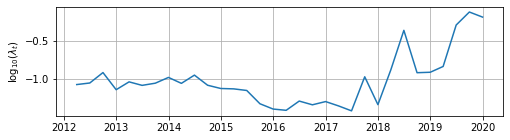

In [195]:
# Aggregated
esnSingle_A_agg_rw_multistep_for_2011 = esnSingle_rw_fit_multistep(
    esnModel=esnSingle_A, 
    Lambda=esnSingle_A_agg_cv10_lambda_2011,  
    data=dataset2011,
    steps=8,
    direct=False,
    retune=True,
    aggregate=True,
)

esnSingle_B_agg_rw_multistep_for_2011 = esnSingle_rw_fit_multistep(
    esnModel=esnSingle_B, 
    Lambda=esnSingle_B_agg_cv10_lambda_2011, 
    data=dataset2011, 
    steps=8,
    direct=False,
    retune=True,
    aggregate=True,
)

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

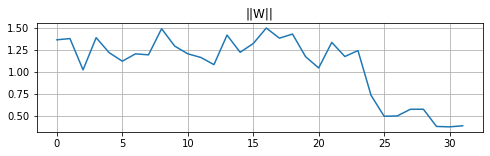

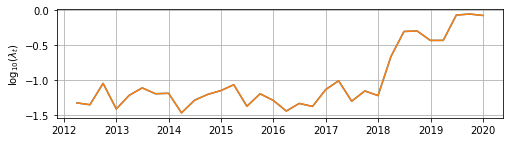

 RW:   0%|          | 0/32 [00:00<?, ?it/s]

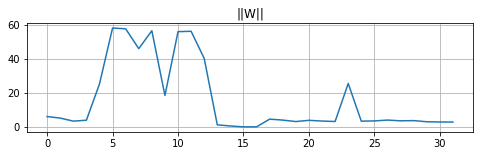

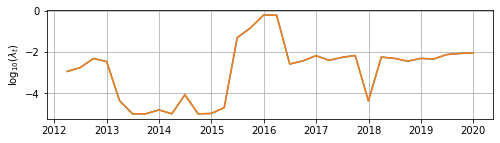

In [196]:
esnMulti_A_rw_multistep_for_2011 = esnMulti_rw_fit_multistep(
    esnModel=esnMulti_A, 
    Lambda=[esnMulti_A_cv10_lambda_2011[0], esnMulti_A_cv10_lambda_2011[0]], 
    data=dataset2011,
    steps=8,
    direct=False,
    retune=True,
)

esnMulti_B_rw_multistep_for_2011 = esnMulti_rw_fit_multistep(
    esnModel=esnMulti_B, 
    Lambda=[esnMulti_B_cv10_lambda_2011[0], esnMulti_B_cv10_lambda_2011[0]], 
    data=dataset2011,
    steps=8,
    direct=False,
    retune=True,
)

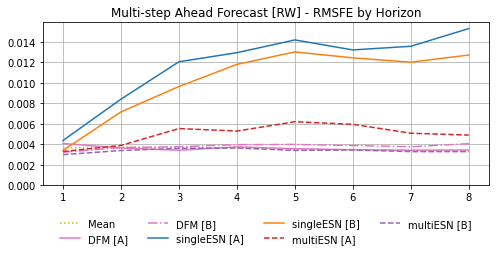

In [220]:
def hStepRMSFE_2011(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            dataset2011['GDP_data_test'].to_numpy() - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))

plt.figure(figsize=(8, 3))
plt.grid()
#
plt.plot(hStepRMSFE_2011(UnMean_rw_multistep_for_2011), label="Mean", c="C8", ls=':') 
#
plt.plot(hStepRMSFE_2011(DFM_A_rw_multistep_for_2011), label="DFM [A]", c="C6") 
plt.plot(hStepRMSFE_2011(DFM_B_rw_multistep_for_2011), label="DFM [B]", c="C6", ls='-.') 
#
plt.plot(hStepRMSFE_2011(esnSingle_A_agg_rw_multistep_for_2011), label="singleESN [A]", c="C0") 
plt.plot(hStepRMSFE_2011(esnSingle_B_agg_rw_multistep_for_2011), label="singleESN [B]", c="C1") 
#
plt.plot(hStepRMSFE_2011(esnMulti_A_rw_multistep_for_2011), label="multiESN [A]", c="C3", ls='--') 
plt.plot(hStepRMSFE_2011(esnMulti_B_rw_multistep_for_2011), label="multiESN [B]", c="C4", ls='--') 
#
plt.ylim(bottom=0.)
#plt.yscale('log')
plt.title("Multi-step Ahead Forecast [RW] - RMSFE by Horizon")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=4)
if savePlots: 
    plt.savefig(os.path.join(plots_folder, 'plot_msa_rmsfe-by-h_rw_2011.pdf'), bbox_inches="tight")
plt.show()

In [201]:
table_RMSFE_multistep_rw_2011 = pd.DataFrame(
    index=range(1,8)
)
table_RMSFE_multistep_rw_2011.index.name = "RW_2011"
table_RMSFE_multistep_rw_2011["Model"] = ['Mean', 'DFM [A]', 'DFM [B]', 
        'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
    ]

for h in range(8):
    ref_h_hStepRMSFE_rw = hStepRMSFE_2011(UnMean_rw_multistep_for_2011).iat[h,0]
    table_RMSFE_multistep_rw_2011[str(h+1)] = [
        hStepRMSFE_2011(UnMean_rw_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2011(DFM_A_rw_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2011(DFM_B_rw_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2011(esnSingle_A_agg_rw_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2011(esnSingle_B_agg_rw_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2011(esnMulti_A_rw_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_rw,
        hStepRMSFE_2011(esnMulti_B_rw_multistep_for_2011).iat[h,0] / ref_h_hStepRMSFE_rw,
    ]

table_RMSFE_multistep_rw_2011.round(4)

Model       1       2       3       4       5       6  \
RW_2011                                                                  
1                 Mean  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
2              DFM [A]  1.1133  0.9822  0.9274  1.0378  1.0298  0.9970   
3              DFM [B]  0.8805  0.9957  1.0212  1.0982  1.1500  1.1144   
4        singleESN [A]  1.1930  2.2674  3.2654  3.5798  4.0898  3.7896   
5        singleESN [B]  0.9271  1.9326  2.6117  3.2647  3.7530  3.5673   
6         multiESN [A]  0.9003  1.0494  1.5001  1.4648  1.7889  1.7073   
7         multiESN [B]  0.8161  0.9162  0.9769  1.0089  0.9821  0.9879   

              7       8  
RW_2011                  
1        1.0000  1.0000  
2        1.0161  1.0285  
3        1.1143  1.2122  
4        4.0150  4.5620  
5        3.5555  3.7922  
6        1.5049  1.4617  
7        0.9735  0.9808

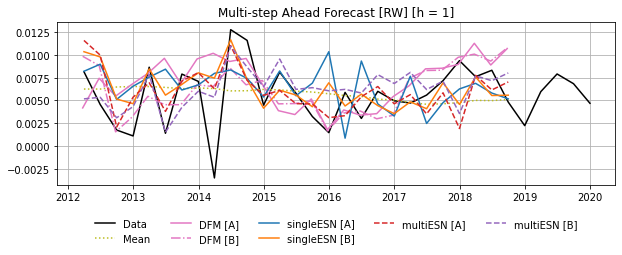

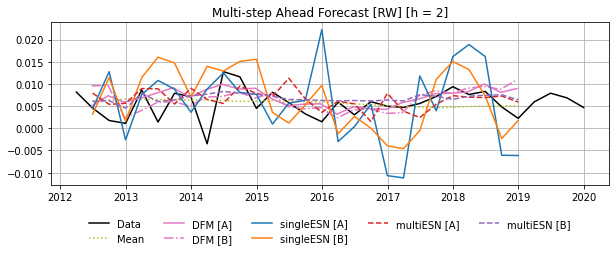

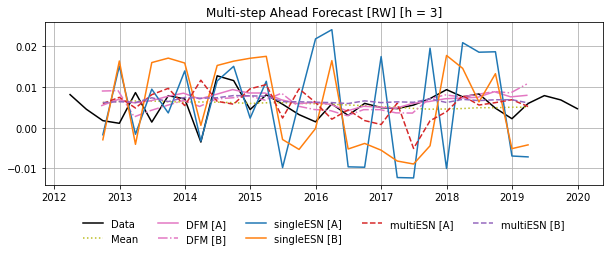

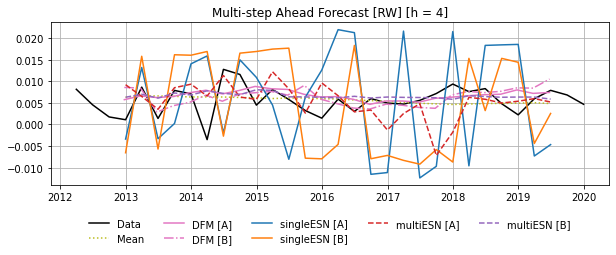

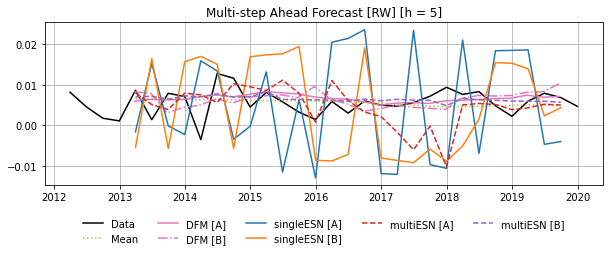

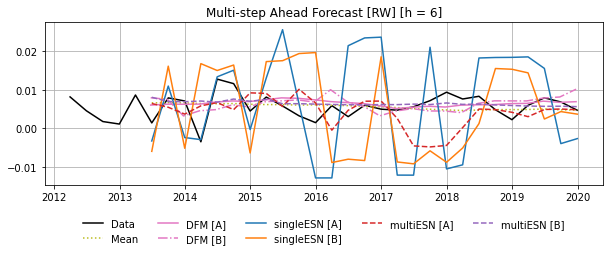

In [198]:
steps = 6
T = len(dataset2011['GDP_data_test'])
for h in range(steps):
    plt.figure(figsize=(10, 3))
    plt.grid()
    plt.plot(dataset2011['GDP_data_test'], c='k', label="Data")
    #
    plt.plot(UnMean_rw_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="Mean", c="C8", ls=':') 
    #
    plt.plot(DFM_A_rw_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="DFM [A]", c="C6") 
    plt.plot(DFM_B_rw_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="DFM [B]", c="C6", ls='-.') 
    #
    plt.plot(esnSingle_A_agg_rw_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="singleESN [A]", c="C0")
    plt.plot(esnSingle_B_agg_rw_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="singleESN [B]", c="C1") 
    #
    plt.plot(esnMulti_A_rw_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="multiESN [A]", c="C3", ls='--') 
    plt.plot(esnMulti_B_rw_multistep_for_2011[h].iloc[h:(T-steps+h+1),], label="multiESN [B]", c="C4", ls='--')
    #
    plt.title("Multi-step Ahead Forecast [RW]" + f" [h = {h+1}]")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                    frameon=False, fancybox=False, shadow=False, ncol=5)
    plt.show()

Export multi-horizon losses:

In [199]:
mhmcs_steps = 8
mhmcs_multistep_rw_2011 = xr.DataArray(
    data=np.zeros(
        (mhmcs_steps, len(dataset2011['GDP_data_test']) - mhmcs_steps, 7)
    ),
    dims=["H", "T", "M0"],
    coords={
        "M0": [
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    },
    attrs=dict(
        names=[
            'Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]'
        ]
    )
)

for h in range(mhmcs_steps):
    mhmcs_multistep_rw_2011[h, :, :] = np.square((
        np.c_[
            UnMean_rw_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            DFM_A_rw_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            DFM_B_rw_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_A_agg_rw_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnSingle_B_agg_rw_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_A_rw_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
            esnMulti_B_rw_multistep_for_2011[h].iloc[h:(-mhmcs_steps+h),],
        ] - dataset2011['GDP_data_test'].iloc[h:(-mhmcs_steps+h),].to_numpy()))

In [200]:
mhmcs_multistep_rw_2011_df = mhmcs_multistep_rw_2011.to_dataframe(
    name="Loss", dim_order=['M0', 'H', 'T']
)
mhmcs_multistep_rw_2011_df.to_csv(
    os.path.join(path_folder, "R", "mhmcs_medium_multistep_rw_2011.csv")
)

### Tables

#### 1-Step Ahead

In [202]:
# Export Relative-MFSE to CSV
method_names = ['Mean', 'DFM [A]', 'DFM [B]', 
                'singleESN [A]', 'singleESN [B]', 'multiESN [A]', 'multiESN [B]']

RelMSFE_results = pd.DataFrame(
    data=np.zeros((len(method_names), 6)), 
    columns=[
       "MCS MEDIUM FIX 2007", "MCS MEDIUM FIX 2011", 
       "MCS MEDIUM EW 2007" , "MCS MEDIUM EW 2011" , 
       "MCS MEDIUM RW 2007" , "MCS MEDIUM RW 2011"
    ]
)
RelMSFE_results.loc[:,"MCS MEDIUM FIX 2007"] = [
        1, 
        DFM_A_MSE_toRef_2007_fix, DMF_B_MSE_toRef_2007_fix, 
        esnSingle_A_MSE_toRef_2007_fix, esnSingle_B_MSE_toRef_2007_fix,
        esnMulti_A_MSE_toRef_2007_fix, esnMulti_B_MSE_toRef_2007_fix,
    ]
RelMSFE_results.loc[:,"MCS MEDIUM FIX 2011"] = [
        1, 
        DFM_A_MSE_toRef_2011_fix, DMF_B_MSE_toRef_2011_fix, 
        esnSingle_A_MSE_toRef_2011_fix, esnSingle_B_MSE_toRef_2011_fix,
        esnMulti_A_MSE_toRef_2011_fix, esnMulti_B_MSE_toRef_2011_fix,
    ]
RelMSFE_results.loc[:,"MCS MEDIUM EW 2007"] = [
        1, 
        DFM_A_MSE_toRef_2007_ew, DMF_B_MSE_toRef_2007_ew, 
        esnSingle_A_MSE_toRef_2007_ew, esnSingle_B_MSE_toRef_2007_ew,
        esnMulti_A_MSE_toRef_2007_ew, esnMulti_B_MSE_toRef_2007_ew,
    ]
RelMSFE_results.loc[:,"MCS MEDIUM EW 2011"] = [
        1,
        DFM_A_MSE_toRef_2011_ew, DMF_B_MSE_toRef_2011_ew, 
        esnSingle_A_MSE_toRef_2011_ew, esnSingle_B_MSE_toRef_2011_ew,
        esnMulti_A_MSE_toRef_2011_ew, esnMulti_B_MSE_toRef_2011_ew,
    ]
RelMSFE_results.loc[:,"MCS MEDIUM RW 2007"] = [
        1,
        DFM_A_MSE_toRef_2007_rw, DMF_B_MSE_toRef_2007_rw, 
        esnSingle_A_MSE_toRef_2007_rw, esnSingle_B_MSE_toRef_2007_rw,
        esnMulti_A_MSE_toRef_2007_rw, esnMulti_B_MSE_toRef_2007_rw,
    ]
RelMSFE_results.loc[:,"MCS MEDIUM RW 2011"] = [
        1,
        DFM_A_MSE_toRef_2011_rw, DMF_B_MSE_toRef_2011_rw, 
        esnSingle_A_MSE_toRef_2011_rw, esnSingle_B_MSE_toRef_2011_rw,
        esnMulti_A_MSE_toRef_2011_rw, esnMulti_B_MSE_toRef_2011_rw,
    ]

RelMSFE_results.round(3).to_csv(
    os.path.join(path_folder, "R", "RelMSFE_medium.csv")
)
RelMSFE_results.round(3)

MCS MEDIUM FIX 2007  MCS MEDIUM FIX 2011  MCS MEDIUM EW 2007  \
0                1.000                1.000               1.000   
1                0.841                1.325               0.682   
2                1.118                1.408               0.821   
3                0.967                1.717               0.775   
4                0.826                1.278               0.655   
5                0.901                1.080               0.618   
6                0.682                0.748               0.587   

   MCS MEDIUM EW 2011  MCS MEDIUM RW 2007  MCS MEDIUM RW 2011  
0               1.000               1.000               1.000  
1               1.272               0.747               1.517  
2               1.117               0.926               1.186  
3               1.072               0.791               1.493  
4               1.028               0.561               0.944  
5               0.913               0.556               0.884  
6               0.774               0.547               0.728

#### Multistep Ahead

In [205]:
pd.concat([
    pd.DataFrame(columns=["Model", ] +  [str(i) for i in range(1,9)]),
    table_RMSFE_multistep_fix_2007.rename_axis("FIX_2007").reset_index(),
    table_RMSFE_multistep_ew_2007.rename_axis("EW_2007").reset_index(),
    table_RMSFE_multistep_rw_2007.rename_axis("RW_2007").reset_index(),
    #
    table_RMSFE_multistep_fix_2011.rename_axis("FIX_2011").reset_index(),
    table_RMSFE_multistep_ew_2011.rename_axis("EW_2011").reset_index(),
    table_RMSFE_multistep_rw_2011.rename_axis("RW_2011").reset_index(),
]).to_csv(
    os.path.join(path_folder, "R", "RelRMSFE_MH_medium.csv")
)

### ---

#### EKF

In [107]:
[] = 0

TypeError: cannot unpack non-iterable int object

In [86]:
esn_M_A = ESN(
    N=10,
    A=stateMatrixGenerator(
        (10, 10), 
        dist='sparse_normal', sparsity=10/20, normalize='eig',
        seed=20220623
    ),
    C=stateMatrixGenerator(
        (10, m_data.shape[1]), 
        dist='sparse_uniform', sparsity=10/20, normalize='norm2',
        seed=20220623
    ),
    rho=0.5,
    gamma=1.5,
    leak_rate=0,
    activation=np.tanh,
)

esn_D_A = ESN(
    N=10,
    A=stateMatrixGenerator(
        (10, 10), 
        dist='sparse_normal', sparsity=10/20, normalize='eig',
        seed=20220623
    ),
    C=stateMatrixGenerator(
        (10, d_data.shape[1]), 
        dist='sparse_uniform', sparsity=10/20, normalize='norm2',
        seed=20220623
    ),
    rho=0.5,
    gamma=0.5,
    leak_rate=0.1,
    activation=np.tanh,
)

#esnMulti_A = ESNMultiFrequency((esn_M_A, ), ar=False) 

In [87]:
fitKF_out = esnMulti_A_fit_1sa_2007 = esnMulti_A.fitKF(
    Y=m_data_train, z=(m_data_train, ), 
    method='EKF_ridge',
    Lambda=[1e-2, ],
    full=False, 
    debug=False
)

NameError: name 'm_data_train' is not defined

In [ ]:
fitKF_out['fitKF_for'][0]['Sigma_eps']

[array([1.00000000e-20, 9.10288189e-01, 1.00000000e-20, 9.53376200e-01])]

In [ ]:
fitKF_out['fitKF_for'][0]['Sigma_eta']

array([], dtype=float64)

In [ ]:
esnMulti_A.models_[0].gamma_ * esnMulti_A.models_[0].C_ @ np.diag(np.sqrt(fitKF_out['fitKF_for'][0]['Sigma_eps'][0]))

array([[ 1.70702280e+00, -5.00101743e-07,  0.00000000e+00,
        -1.04575952e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.37362361e-07,  4.67131402e-07, -4.70957418e-07,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.59077941e-07, -2.99925360e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.66236617e-01,
         0.00000000e+00, -4.88426761e-07, -8.41110990e-08,
        -4.52594226e-07,  4.73737000e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.13214882e-08,  0.00000000e+00, -4.27968831e-07,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.000000

In [ ]:
esnMulti_KFfor_1sa_2007 = esnMulti_A.fixedParamsKFForecast(
    Yf=GDP_data_test, zf=(m_data_test, d_data_test), 
    fit=fitKF_out
)['Forecast'][0]['Y_for']

In [ ]:
#GDP_data_test.iloc[:3,]

In [ ]:
#m_data_test.iloc[:9,]

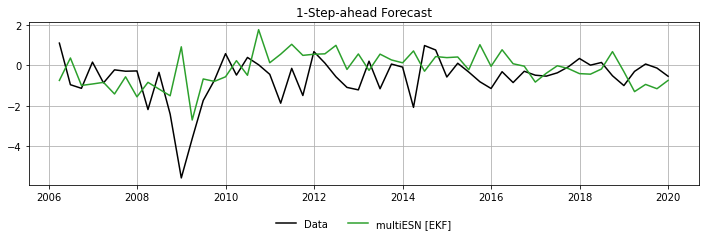

In [ ]:
# Plot -- 1-Step-ahead Forecast
plt.figure(figsize=(12, 3))
plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
#
plt.plot(esnMulti_KFfor_1sa_2007, label="multiESN [EKF]", c="C2")
#
plt.grid()
plt.title("1-Step-ahead Forecast")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=5)
plt.show()

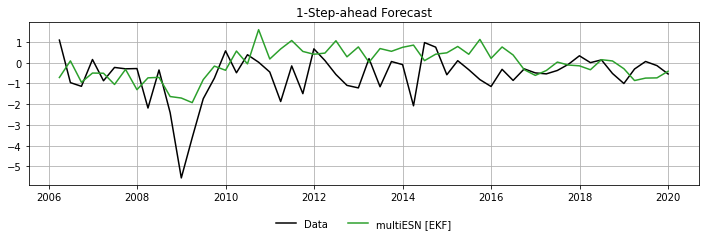

In [ ]:
# Plot -- 1-Step-ahead Forecast
plt.figure(figsize=(12, 3))
plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
#
plt.plot(esnMulti_KFfor_1sa_2007, label="multiESN [EKF]", c="C2")
#
plt.grid()
plt.title("1-Step-ahead Forecast")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=5)
plt.show()

#### As-you-go Variables Addition

In [ ]:
# Extended monthly data
data_ext = preproc_data.loc['1970-01-01':endSampleDate]

m_data_ext = data_ext[
        [f"M{j}" for j in range(1, 21)]
    ].loc[pd.date_range('1970-01-01', endSampleDate, freq='BM'),].replace(np.NaN, 0.)

In [ ]:
def esnMulti_ew_fit_1sa(esnModel, Lambda, data):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']
    m_data_train = data['m_data_train']
    m_data_test = data['m_data_test']
    d_data_train = data['d_data_train']
    d_data_test = data['d_data_test']

    GDP_test_dates = GDP_data_test.index

    forecast_ew = np.zeros((len(GDP_data_test), 1))
    for j in tqdm(range(len(GDP_data_test)), desc=" EW", position=1, leave=False):
        if j > 0:
            GDP_data_train_j = GDP_data_train.append(GDP_data_test.iloc[0:j,])
            m_data_train_j = m_data_train.append(
                        m_data_test[:GDP_test_dates[j-1]].iloc[1:,])
            d_data_train_j = d_data_train.append(
                        d_data_test[:GDP_test_dates[j-1]].iloc[1:,])
            GDP_data_test_j = GDP_data_test.iloc[[j],]
            m_data_test_j = m_data_test.loc[[m_data_train_j.index[-1]],]
            d_data_test_j = d_data_test.loc[[d_data_train_j.index[-1]],]
        else:
            GDP_data_train_j = GDP_data_train
            m_data_train_j = m_data_train
            d_data_train_j = d_data_train
            GDP_data_test_j = GDP_data_test.iloc[[0],]
            m_data_test_j = m_data_test.iloc[[0],]
            d_data_test_j = d_data_test.iloc[[0],]

        #print(f"j = {j}")
        #print(f"{GDP_data_train_j.index[-1]} | {GDP_data_test_j.index[0]}")
        #print(f"{m_data_train_j.index[-1]} | {m_data_test_j.index[0]} -> {m_data_test_j.index[-1]}")
        #print(f"{d_data_train_j.index[-1]} | {d_data_test_j.index[0]} -> {d_data_test_j.index[-1]}")
        #print("-------------------------------")

        esnSingle_fit = esnModel.fit(
            Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j), 
            method='ridge',
            Lambda=Lambda,
            full=False,
            debug=False,
        )

        esnSingle_for = esnModel.fixedParamsForecast(
            Yf=GDP_data_test_j, zf=(m_data_test_j, d_data_test_j), 
            fit=esnSingle_fit
        )

        forecast_ew[j] = np.squeeze(esnSingle_for['Forecast'][0]['Y_for'])

    return pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)

def esnMulti_rw_fit_1sa(esnModel, Lambda, data):
    GDP_data_train = data['GDP_data_train']
    GDP_data_test = data['GDP_data_test']
    m_data_train = data['m_data_train']
    m_data_test = data['m_data_test']
    d_data_train = data['d_data_train']
    d_data_test = data['d_data_test']

    GDP_test_dates = GDP_data_test.index
    GDP_dates = GDP_data_train.index.append(GDP_data_test.index)

    forecast_rw = np.zeros((len(GDP_data_test), 1))
    for j in tqdm(range(len(GDP_data_test)), desc=" RW", position=1, leave=False):
        if j > 0:
            GDP_data_train_j = GDP_data_train.append(
                        GDP_data_test.iloc[0:j,]).iloc[(1+j):,]
            m_data_train_j = m_data_train.append(
                        m_data_test[:GDP_test_dates[j-1]].iloc[1:,])
            d_data_train_j = d_data_train.append(
                        d_data_test[:GDP_test_dates[j-1]].iloc[1:,])
            m_data_train_j = m_data_train_j[GDP_dates[j]:]
            d_data_train_j = d_data_train_j[GDP_dates[j]:]
            GDP_data_test_j = GDP_data_test.iloc[[j],]
            m_data_test_j = m_data_test.loc[[m_data_train_j.index[-1]],]
            d_data_test_j = d_data_test.loc[[d_data_train_j.index[-1]],]
        else:
            GDP_data_train_j = GDP_data_train
            m_data_train_j = m_data_train
            d_data_train_j = d_data_train
            GDP_data_test_j = GDP_data_test.iloc[[0],]
            m_data_test_j = m_data_test.iloc[[0],]
            d_data_test_j = d_data_test.iloc[[0],]

        #print(f"j = {j}")
        #print(f"{GDP_data_train_j.index[-1]} | {GDP_data_test_j.index[0]}")
        #print(f"{m_data_train_j.index[-1]} | {m_data_test_j.index[0]} -> {m_data_test_j.index[-1]}")
        #print(f"{d_data_train_j.index[-1]} | {d_data_test_j.index[0]} -> {d_data_test_j.index[-1]}")
        #print("-------------------------------")

        esnSingle_fit = esnModel.fit(
            Y=GDP_data_train_j, z=(m_data_train_j, d_data_train_j), 
            method='ridge',
            Lambda=Lambda,
            full=False,
            debug=False,
        )

        esnSingle_for = esnModel.fixedParamsForecast(
            Yf=GDP_data_test_j, zf=(m_data_test_j, d_data_test_j), 
            fit=esnSingle_fit
        )

        forecast_rw[j] = np.squeeze(esnSingle_for['Forecast'][0]['Y_for'])

    return pd.DataFrame(data=forecast_rw, index=GDP_test_dates,)

In [ ]:
# Generate two monthly reservoir models
Am = stateMatrixGenerator(
        (100, 100), 
        dist='sparse_normal', sparsity=10/100, normalize='eig',
        seed=20220623
    )

# Model with "increasing" number of variables
Cm_1 = stateMatrixGenerator(
        (100, m_data_ext.shape[1]), 
        dist='sparse_uniform', sparsity=10/100, normalize='norm2',
        seed=20220623
    )

# Model with consistent number of variables
Cm_2 = Cm_1[:,0:(m_data.shape[1])]

esn_M_1 = ESN(
    N=100,
    A=Am,
    C=Cm_1,
    rho=0.5,
    gamma=1.5,
    leak_rate=0,
    activation=np.tanh,
)

esn_M_2 = ESN(
    N=100,
    A=Am,
    C=Cm_2,
    rho=0.5,
    gamma=1.5,
    leak_rate=0,
    activation=np.tanh,
)

esn_D = ESN(
    N=20,
    A=stateMatrixGenerator(
        (20, 20), 
        dist='sparse_normal', sparsity=10/20, normalize='eig',
        seed=20220623
    ),
    C=stateMatrixGenerator(
        (20, d_data.shape[1]), 
        dist='sparse_uniform', sparsity=10/20, normalize='norm2',
        seed=20220623
    ),
    rho=0.5,
    gamma=0.5,
    leak_rate=0.1,
    activation=np.tanh,
)

esnMulti_1 = ESNMultiFrequency((esn_M_1, esn_D), ar=False) 
esnMulti_2 = ESNMultiFrequency((esn_M_2, esn_D), ar=False) 

In [ ]:
esnMulti_ext_fit_1sa_2007 = esnMulti_1.fit(
    Y=dataset2007_ext['GDP_data_train'], 
    z=(dataset2007_ext['m_data_train'], dataset2007_ext['d_data_train']), 
    method='ridge',
    Lambda=[3*1e-2, 1e-2],
    full=False, 
    debug=False
)

esnMulti_ext_for_1sa_2007 = esnMulti_1.fixedParamsForecast(
    Yf=dataset2007_ext['GDP_data_test'], 
    zf=(dataset2007_ext['m_data_test'], dataset2007_ext['d_data_test']), 
    fit=esnMulti_ext_fit_1sa_2007
)['Forecast'][0]['Y_for']

In [ ]:
esnMulti_base_fit_1sa_2007 = esnMulti_2.fit(
    Y=dataset2007['GDP_data_train'], 
    z=(dataset2007['m_data_train'], dataset2007['d_data_train']), 
    method='ridge',
    Lambda=[1e-2, 1e-2],
    full=False, 
    debug=False
)

esnMulti_base_for_1sa_2007 = esnMulti_2.fixedParamsForecast(
    Yf=dataset2007['GDP_data_test'], 
    zf=(dataset2007['m_data_test'], dataset2007['d_data_test']), 
    fit=esnMulti_base_fit_1sa_2007
)['Forecast'][0]['Y_for']

In [ ]:
esnMulti_ext_ew_for_1sa_2007 = esnMulti_ew_fit_1sa(
    esnModel=esnMulti_1, Lambda=[3*1e-2, 1e-2], data=dataset2007_ext,
)

 EW:   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
esnMulti_base_ew_for_1sa_2007 = esnMulti_ew_fit_1sa(
    esnModel=esnMulti_2, Lambda=[1e-2, 1e-2], data=dataset2007,
)

 EW:   0%|          | 0/56 [00:00<?, ?it/s]

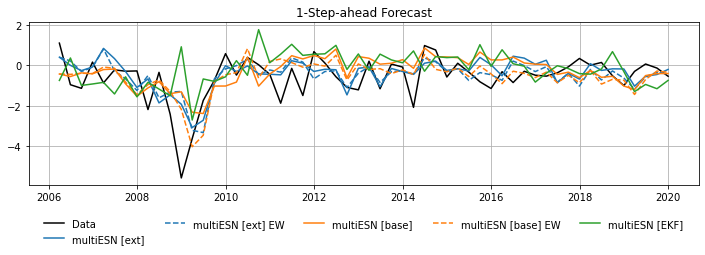

In [ ]:
# Plot -- 1-Step-ahead Forecast
plt.figure(figsize=(12, 3))
plt.plot(dataset2007['GDP_data_test'], c='k', label="Data")
#
plt.plot(esnMulti_ext_for_1sa_2007, label="multiESN [ext]", c="C0") 
plt.plot(esnMulti_ext_ew_for_1sa_2007, label="multiESN [ext] EW", c="C0", ls="--") 
#
plt.plot(esnMulti_base_for_1sa_2007, label="multiESN [base]", c="C1") 
plt.plot(esnMulti_base_ew_for_1sa_2007, label="multiESN [base] EW", c="C1", ls="--") 
#
plt.plot(esnMulti_KFfor_1sa_2007, label="multiESN [EKF]", c="C2")
#
plt.grid()
plt.title("1-Step-ahead Forecast")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                frameon=False, fancybox=False, shadow=False, ncol=5)
plt.show()